# GDPR Violation Decision Tree Model

A Jupyter Notebook for Predicting and Explaining GDPR Violations Using Decision Tree Algorithms.

## Contents

1. **Data Loading and Preprocessing**
2. **Exploratory Data Analysis**
3. **Feature Selection**
4. **Training the `violation_result` Model**
5. **Training the `violation_nature` Model**
6. **Training the `fine_amount` Model**
7. **Model Visualization and Interpretation**


In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
import os

In [184]:
np.random.seed(42)

# Step 1: Data Loading and Preprocessing

In [186]:
# Load data
file_path = "FINAL_dataset.csv"
df = pd.read_csv(file_path)

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Dataset columns: {df.columns.tolist()}")

# Check data types
print("\nData types:")
print(df.dtypes)

# Preview the first 5 rows
print("\nData preview:")
df.head()

Dataset shape: (2512, 26)
Dataset columns: ['Affected_data_volume', 'Criminal_investigation_exception', 'Date', 'company_industry', 'country', 'country_security_exception', 'data_category_Basic_personal_data', 'data_category_Children_data', 'data_category_Criminal_data', 'data_category_Financial_location_data', 'data_category_Special_category_data', 'data_processing_basis_Consent', 'data_processing_basis_Legal_obligation', 'data_processing_basis_Legitimate_interest', 'data_processing_basis_Performance_of_public_task', 'data_processing_basis_Protection_of_vital_interests', 'data_processing_basis_contract_performance', 'fine_amount', 'free_speech_exception', 'gdpr_clause', 'gdpr_conflict', 'violation_nature_Breach_of_Data_processing_principle', 'violation_nature_Breach_of_data_security', 'violation_nature_Violation_of_Data_processing_obligation', 'violation_nature_Violation_of_data_subject_rights', 'violation_result']

Data types:
Affected_data_volume                                     

,Affected_data_volume,Criminal_investigation_exception,Date,company_industry,country,country_security_exception,data_category_Basic_personal_data,data_category_Children_data,data_category_Criminal_data,data_category_Financial_location_data,...,data_processing_basis_contract_performance,fine_amount,free_speech_exception,gdpr_clause,gdpr_conflict,violation_nature_Breach_of_Data_processing_principle,violation_nature_Breach_of_data_security,violation_nature_Violation_of_Data_processing_obligation,violation_nature_Violation_of_data_subject_rights,violation_result
0,14000000,0,2020,Marketing,United Kingdom,0,0,0,0,0,...,0,105399,0,Article 21(1) GDPR,No conflict,0,0,0,1,1
1,9000,0,2020,Marketing,United Kingdom,0,0,0,0,0,...,0,45696,0,Article 21(1) GDPR,No conflict,1,0,0,0,1
2,16190,0,2020,Marketing,United Kingdom,0,0,0,0,0,...,0,68544,0,Article 21(1) GDPR,No conflict,0,0,0,1,1
3,80240,0,2024,Marketing,United Kingdom,0,0,0,0,0,...,0,114240,0,Article 21(1) GDPR,yes,0,0,1,1,1
4,unspecific,0,2019,Medical,Cyprus,0,0,0,0,0,...,0,14000,0,Article 6(1)(a) GDPR,No conflict,0,0,0,1,1


In [187]:
# Check for missing values
missing_values = df.isnull().sum()
print(f"Missing values summary:\n{missing_values[missing_values > 0]}")

# Handle missing values (if any)
if missing_values.sum() > 0:
    print("Handling missing values...")
    # Fill numeric columns with 0 and categorical columns with the mode
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna(df[col].mode()[0])


Missing values summary:
Series([], dtype: int64)


In [188]:
# %%
# Process the Affected_data_volume column (convert 'unspecific' to 0)
if 'Affected_data_volume' in df.columns:
    print("Original Affected_data_volume value distribution:")
    print(df['Affected_data_volume'].value_counts().head())
    
    # Check data type
    print(f"\nAffected_data_volume data type: {df['Affected_data_volume'].dtype}")
    
    # Convert 'unspecific' to 0
    if df['Affected_data_volume'].dtype == 'object':
        df['Affected_data_volume'] = pd.to_numeric(df['Affected_data_volume'].replace('unspecific', 0), errors='coerce').fillna(0)
        print("\nConverted Affected_data_volume value distribution:")
        print(df['Affected_data_volume'].value_counts().head())


Original Affected_data_volume value distribution:
unspecific    2058
1               22
2                8
1500000          6
1000000          6
Name: Affected_data_volume, dtype: int64

Affected_data_volume data type: object

Converted Affected_data_volume value distribution:
0          2058
1            22
2             8
1500000       6
1000000       6
Name: Affected_data_volume, dtype: int64


In [189]:
# %%
# Process categorical features
categorical_columns = df.select_dtypes(include=['object']).columns
print(f"Categorical features: {categorical_columns.tolist()}")

# Encode categorical features
label_encoders = {}
for col in categorical_columns:
    # Exclude columns that do not need encoding, such as comments or IDs
    if col not in ['gdpr_clause']:  # Exclude complex text fields
        print(f"Label encoding column '{col}'")
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Processed data preview
print("\nPreview of encoded data:")
df.head()

Categorical features: ['company_industry', 'country', 'gdpr_clause', 'gdpr_conflict']
Label encoding column 'company_industry'
Label encoding column 'country'
Label encoding column 'gdpr_conflict'

Preview of encoded data:


,Affected_data_volume,Criminal_investigation_exception,Date,company_industry,country,country_security_exception,data_category_Basic_personal_data,data_category_Children_data,data_category_Criminal_data,data_category_Financial_location_data,...,data_processing_basis_contract_performance,fine_amount,free_speech_exception,gdpr_clause,gdpr_conflict,violation_nature_Breach_of_Data_processing_principle,violation_nature_Breach_of_data_security,violation_nature_Violation_of_Data_processing_obligation,violation_nature_Violation_of_data_subject_rights,violation_result
0,14000000,0,2020,7,30,0,0,0,0,0,...,0,105399,0,Article 21(1) GDPR,0,0,0,0,1,1
1,9000,0,2020,7,30,0,0,0,0,0,...,0,45696,0,Article 21(1) GDPR,0,1,0,0,0,1
2,16190,0,2020,7,30,0,0,0,0,0,...,0,68544,0,Article 21(1) GDPR,0,0,0,0,1,1
3,80240,0,2024,7,30,0,0,0,0,0,...,0,114240,0,Article 21(1) GDPR,1,0,0,1,1,1
4,0,0,2019,8,4,0,0,0,0,0,...,0,14000,0,Article 6(1)(a) GDPR,0,0,0,0,1,1


# Step 2. Exploratory Data Analysis

Target variable 'violation_result' distribution:
1    2146
0     366
Name: violation_result, dtype: int64
Violation rate: 85.43%


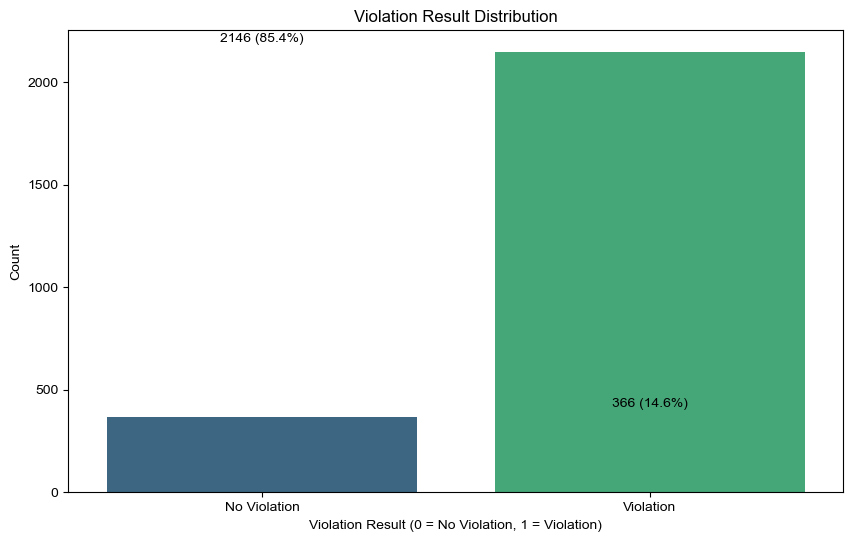

In [190]:
# %%
# View target variable distribution
print("Target variable 'violation_result' distribution:")
violation_result_counts = df['violation_result'].value_counts()
print(violation_result_counts)
print(f"Violation rate: {violation_result_counts[1] / len(df) * 100:.2f}%")

# Visualize target variable distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='violation_result', data=df, palette='viridis')
plt.title('Violation Result Distribution')
plt.xlabel('Violation Result (0 = No Violation, 1 = Violation)')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Violation', 'Violation'])
for i, count in enumerate(violation_result_counts.values):
    plt.text(i, count + 50, f'{count} ({count/len(df)*100:.1f}%)', ha='center')
plt.show()

Violation Nature Distribution:
violation_nature_Breach_of_Data_processing_principle: 1483 (59.04%)
violation_nature_Breach_of_data_security: 483 (19.23%)
violation_nature_Violation_of_Data_processing_obligation: 881 (35.07%)
violation_nature_Violation_of_data_subject_rights: 1485 (59.12%)


<Figure size 1400x800 with 0 Axes>

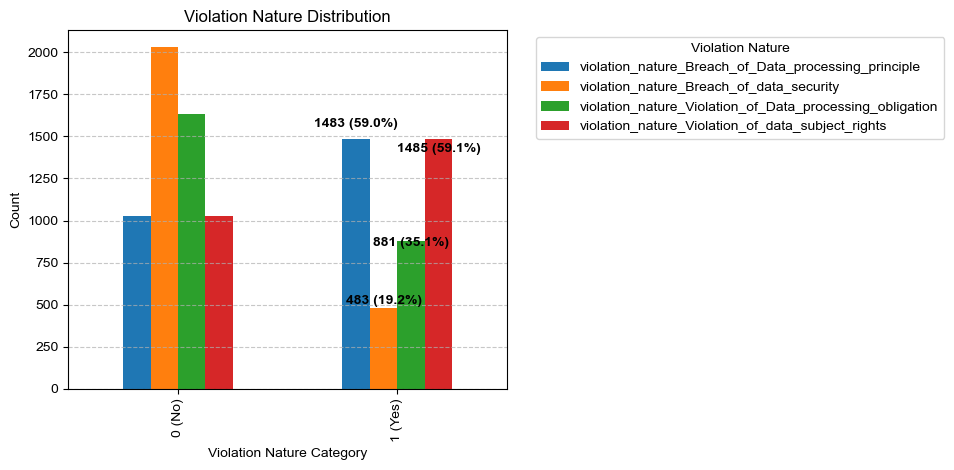

In [191]:

# View distribution of violation_nature related variables
violation_nature_cols = [col for col in df.columns if col.startswith('violation_nature_')]
if violation_nature_cols:
    print("Violation Nature Distribution:")
    
    # Create a DataFrame to store distributions
    nature_distribution = pd.DataFrame()
    
    for col in violation_nature_cols:
        positive_count = df[col].sum()
        negative_count = len(df) - positive_count
        
        nature_distribution[col] = [negative_count, positive_count]
        
        print(f"{col}: {positive_count} ({positive_count / len(df) * 100:.2f}%)")
    
    # Set index
    nature_distribution.index = ['0 (No)', '1 (Yes)']
    
    # Visualization
    plt.figure(figsize=(14, 8))
    ax = nature_distribution.plot(kind='bar', stacked=False)
    plt.title('Violation Nature Distribution')
    plt.xlabel('Violation Nature Category')
    plt.ylabel('Count')
    
    # 将图例放到图表区域外的右侧
    plt.legend(title='Violation Nature', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 垂直错开标签以避免重叠
    y_offsets = [50, 0, -50, -100]  # 不同的垂直偏移量
    
    # Add value labels with vertical offsets to avoid overlap
    for i, container in enumerate(ax.containers):
        for j, val in enumerate(container):
            # Only label the "Yes" category (index 1)
            if j == 1:  # This corresponds to '1 (Yes)' row
                height = val.get_height()
                count = nature_distribution.iloc[j, i]
                percentage = count / len(df) * 100
                
                # 使用不同的垂直偏移，避免标签重叠
                y_offset = y_offsets[i % len(y_offsets)]
                
                ax.text(
                    val.get_x() + val.get_width()/2, 
                    height + 20 + y_offset,  # 使用不同的垂直偏移
                    f'{int(count)} ({percentage:.1f}%)', 
                    ha='center',
                    fontweight='bold'
                )
    
    # 调整布局以适应右侧图例
    plt.tight_layout()
    plt.subplots_adjust(right=0.8)  # 给右侧的图例留出空间
    plt.show()

Fine Amount Distribution:
Mean: 7861630.02
Median: 0.00
Max: 3525870795.00
Zero fine count: 1391, Percentage: 55.37%


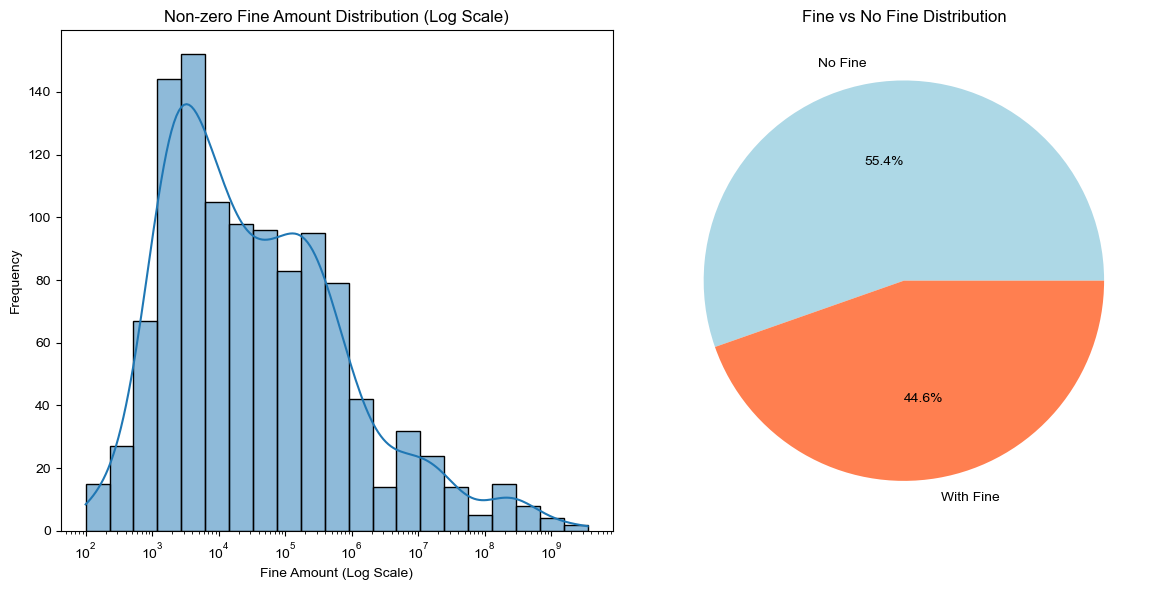

In [192]:
# %%
# View fine_amount distribution
print("Fine Amount Distribution:")
print(f"Mean: {df['fine_amount'].mean():.2f}")
print(f"Median: {df['fine_amount'].median():.2f}")
print(f"Max: {df['fine_amount'].max():.2f}")
print(f"Zero fine count: {(df['fine_amount'] == 0).sum()}, Percentage: {(df['fine_amount'] == 0).sum() / len(df) * 100:.2f}%")

# Visualize fine amount distribution using logarithmic scale
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df[df['fine_amount'] > 0]['fine_amount'], kde=True, log_scale=True)
plt.title('Non-zero Fine Amount Distribution (Log Scale)')
plt.xlabel('Fine Amount (Log Scale)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.pie([(df['fine_amount'] == 0).sum(), (df['fine_amount'] > 0).sum()], 
       labels=['No Fine', 'With Fine'], autopct='%1.1f%%', colors=['lightblue', 'coral'])
plt.title('Fine vs No Fine Distribution')

plt.tight_layout()
plt.show()


Calculating correlation matrix...

Features most correlated with violation_result:
violation_result                                            1.000000
violation_nature_Breach_of_Data_processing_principle        0.413178
violation_nature_Violation_of_data_subject_rights           0.301507
violation_nature_Violation_of_Data_processing_obligation    0.286968
violation_nature_Breach_of_data_security                    0.172860
gdpr_conflict                                               0.170546
data_category_Basic_personal_data                           0.099308
country                                                     0.086126
data_processing_basis_Consent                               0.074812
Date                                                        0.064313
data_category_Special_category_data                         0.023524
Name: violation_result, dtype: float64

Features most correlated with fine_amount:
fine_amount                                                 1.000000
gdpr_c

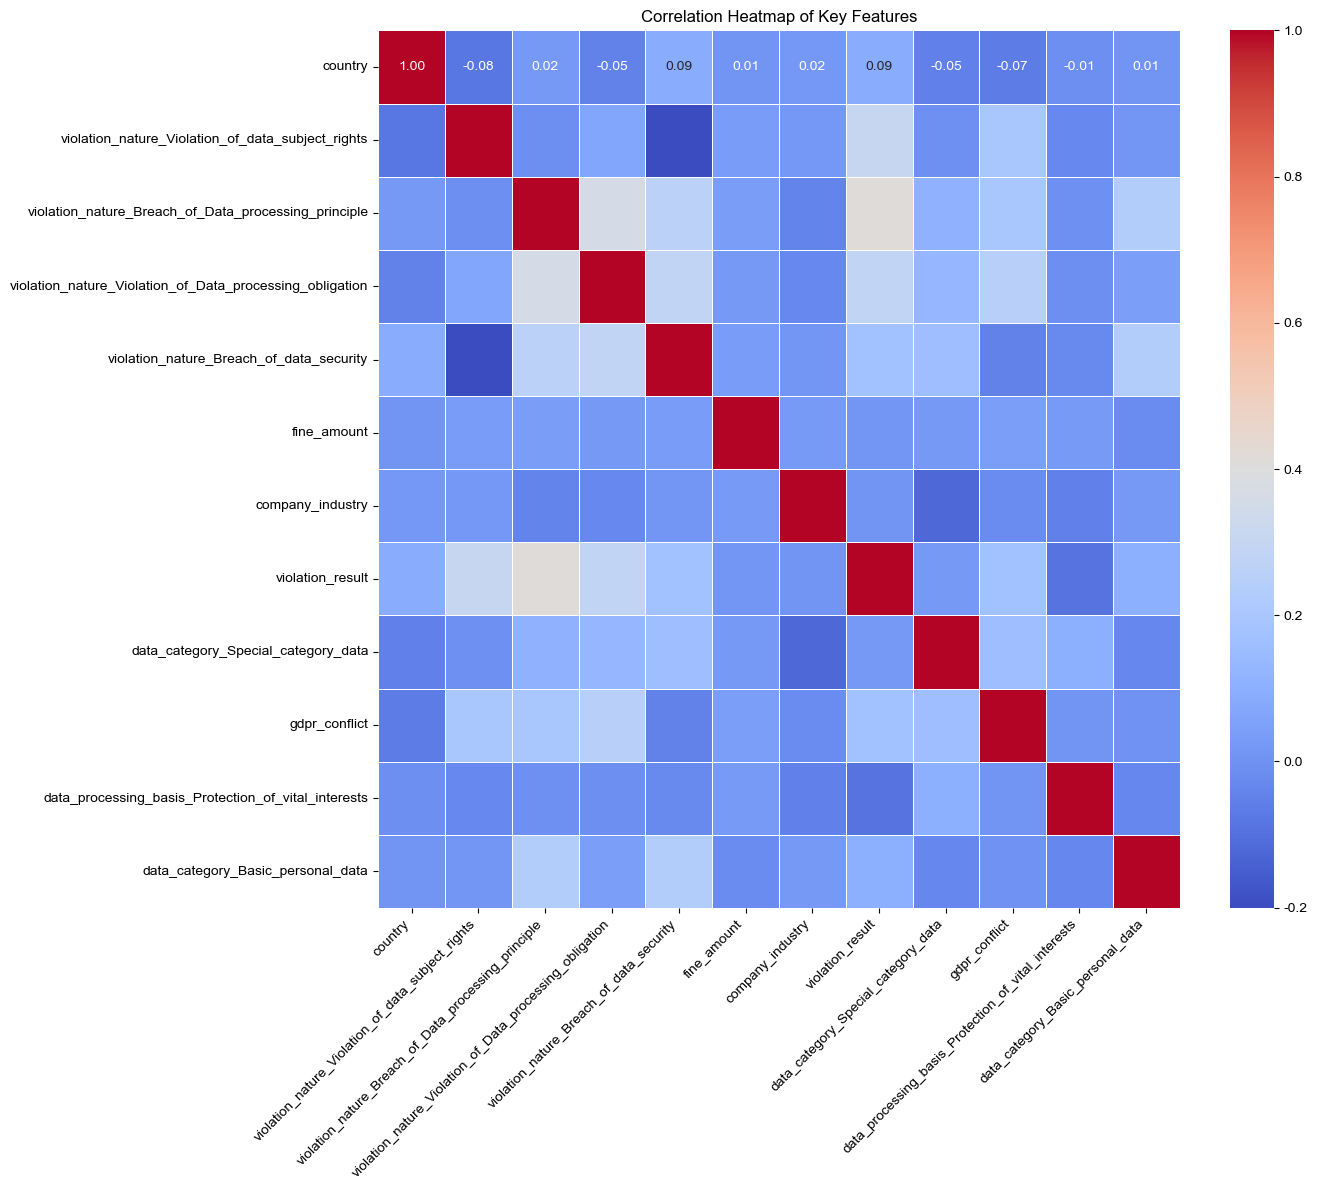

In [193]:
# %%
# Correlation analysis
print("Calculating correlation matrix...")
# Select numeric variables
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation = numeric_df.corr()

# Output top 10 features most correlated with the target variable
if 'violation_result' in correlation:
    violation_result_corr = correlation['violation_result'].sort_values(ascending=False)
    print("\nFeatures most correlated with violation_result:")
    print(violation_result_corr.head(11))  # Including itself

if 'fine_amount' in correlation:
    fine_amount_corr = correlation['fine_amount'].sort_values(ascending=False)
    print("\nFeatures most correlated with fine_amount:")
    print(fine_amount_corr.head(11))  # Including itself

# Visualize correlation heatmap
plt.figure(figsize=(14, 12))
# Get the top 15 most correlated features
top_features = set()
if 'violation_result' in correlation:
    top_features.update(violation_result_corr.head(8).index)
if 'fine_amount' in correlation:
    top_features.update(fine_amount_corr.head(8).index)

# Add target variables
target_vars = ['violation_result', 'fine_amount']
for col in target_vars:
    if col in correlation.columns:
        top_features.add(col)

for col in violation_nature_cols:
    if col in correlation.columns:
        top_features.add(col)

# Plot heatmap
sns.heatmap(correlation.loc[list(top_features), list(top_features)], 
           annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Key Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Step special: data preprocessing

In [194]:
# 通过类别加权解决不平衡问题
dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_classifier.fit(X_train, y_train)


DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Step 3. Feature Selection

In [196]:
# Select features and target variables for the model
# Exclude target variables and unrelated features
exclude_columns = ['violation_result', 'fine_amount']
exclude_columns.extend([col for col in df.columns if col.startswith('violation_nature_')])

# For high cardinality text features like gdpr_clause, we may need to exclude them
if 'gdpr_clause' in df.columns:
    exclude_columns.append('gdpr_clause')

# Feature matrix
X = df.drop(exclude_columns, axis=1)
print(f"Number of selected features: {X.shape[1]}")
print(f"Feature list: {X.columns.tolist()}")

# Target variable: violation_result
y_violation = df['violation_result']
print(f"\nViolation Result label distribution: {y_violation.value_counts().to_dict()}")

# Target variable: violation_nature_*
violation_nature_cols = [col for col in df.columns if col.startswith('violation_nature_')]
y_nature_dict = {}
for col in violation_nature_cols:
    y_nature_dict[col] = df[col]
    print(f"{col} label distribution: {df[col].value_counts().to_dict()}")

# Target variable: fine_amount
y_fine = df['fine_amount']
print(f"\nFine Amount range: {y_fine.min()} - {y_fine.max()}")


Number of selected features: 19
Feature list: ['Affected_data_volume', 'Criminal_investigation_exception', 'Date', 'company_industry', 'country', 'country_security_exception', 'data_category_Basic_personal_data', 'data_category_Children_data', 'data_category_Criminal_data', 'data_category_Financial_location_data', 'data_category_Special_category_data', 'data_processing_basis_Consent', 'data_processing_basis_Legal_obligation', 'data_processing_basis_Legitimate_interest', 'data_processing_basis_Performance_of_public_task', 'data_processing_basis_Protection_of_vital_interests', 'data_processing_basis_contract_performance', 'free_speech_exception', 'gdpr_conflict']

Violation Result label distribution: {1: 2146, 0: 366}
violation_nature_Breach_of_Data_processing_principle label distribution: {1: 1483, 0: 1029}
violation_nature_Breach_of_data_security label distribution: {0: 2029, 1: 483}
violation_nature_Violation_of_Data_processing_obligation label distribution: {0: 1631, 1: 881}
violatio

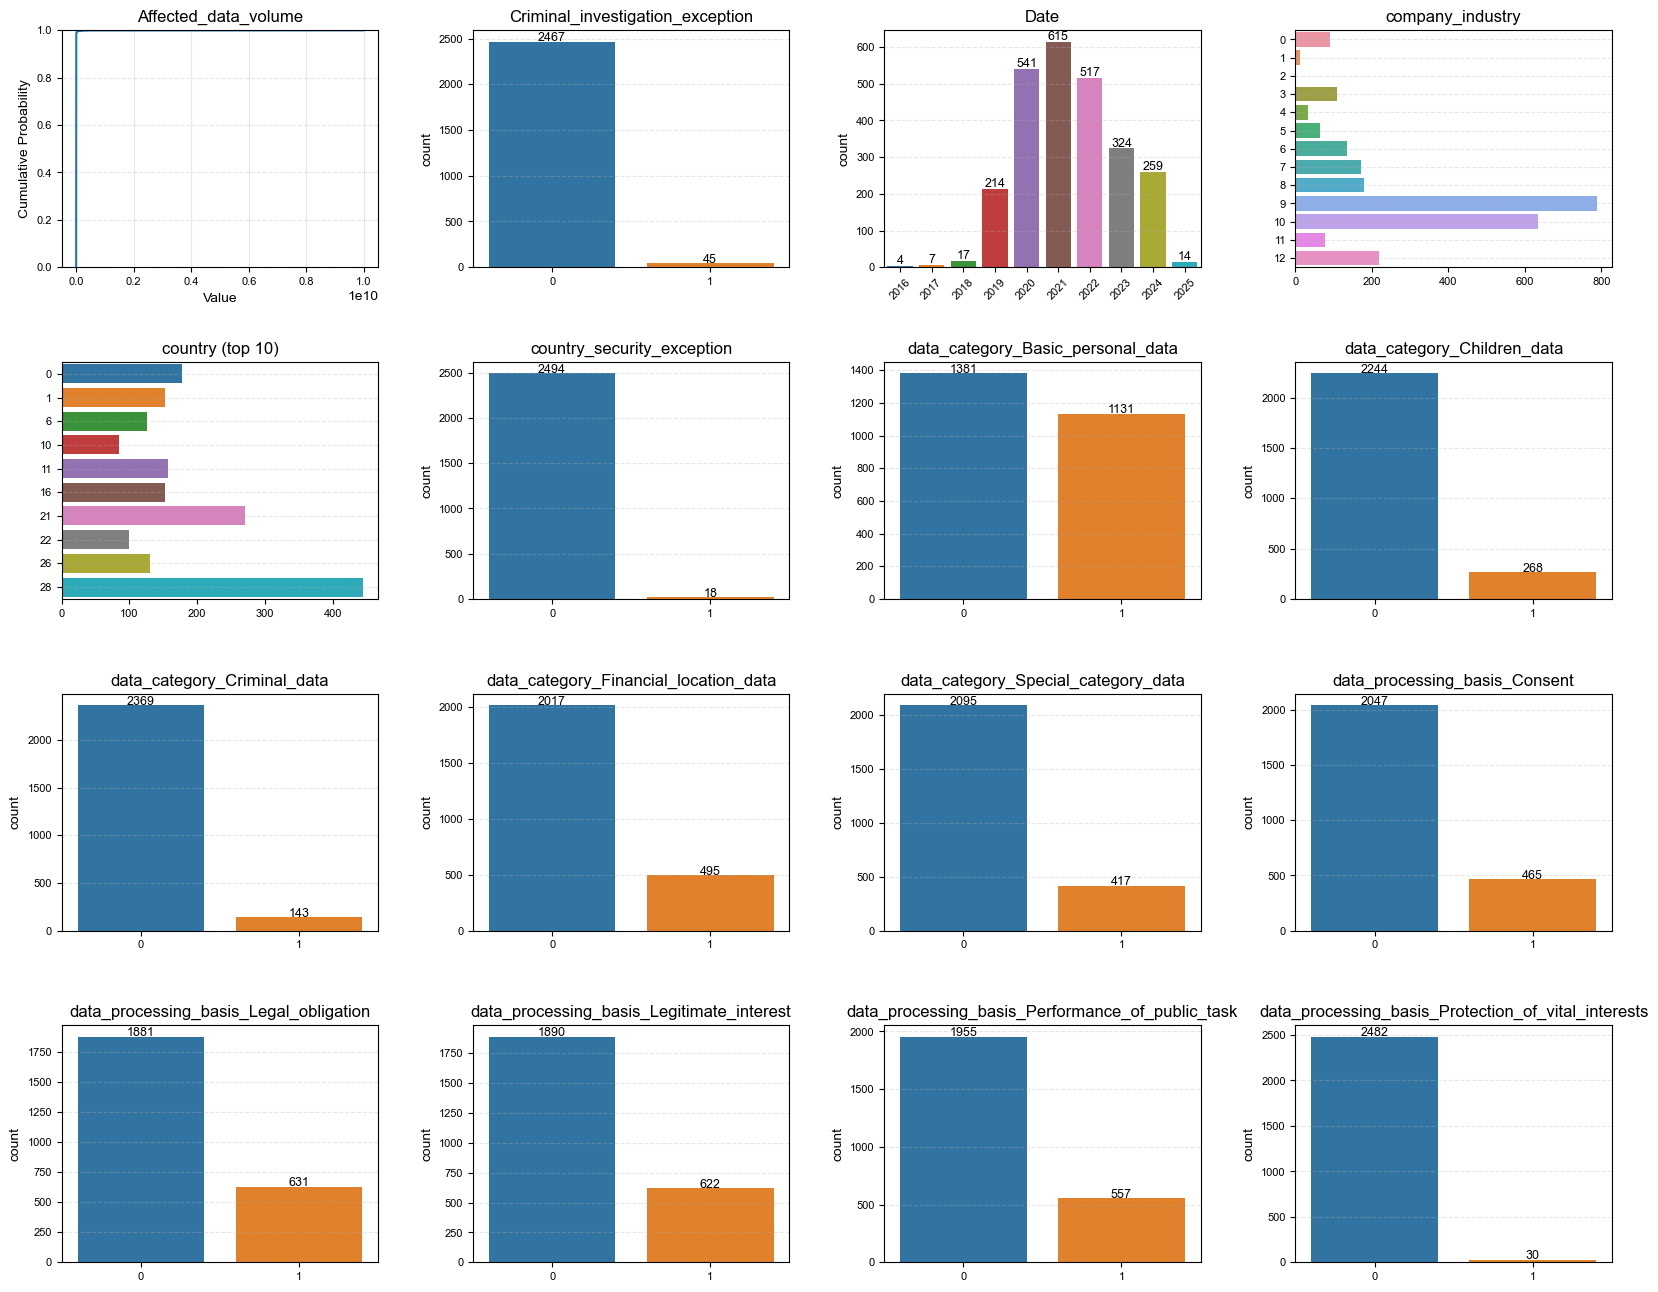

In [197]:
# View feature distribution with improved readability
plt.figure(figsize=(20, 16))  # Increase overall chart size

for i, col in enumerate(X.columns[:min(16, len(X.columns))]):
    ax = plt.subplot(4, 4, i+1)
    
    if col == 'Affected_data_volume':
        # Use CDF plot for Affected_data_volume
        sns.ecdfplot(x=X[col], ax=ax)
        plt.title(col, fontsize=12)
        plt.xlabel('Value')
        plt.ylabel('Cumulative Probability')
        # Add grid for better readability
        plt.grid(True, alpha=0.3)
        
    elif X[col].dtype in ['int64', 'int32', 'bool']:
        # For categorical variables, use countplot
        if col == 'country':
            # Special handling for country column as it has too many categories
            # Only display top 10 countries by count
            top_countries = X[col].value_counts().nlargest(10).index
            sns.countplot(y=col, data=X[X[col].isin(top_countries)])
            plt.title(f"{col} (top 10)", fontsize=12)
            plt.ylabel('')
        elif col == 'company_industry' or X[col].nunique() > 10:
            # For variables with multiple categories, use vertical bar chart and rotate labels
            ax = sns.countplot(y=col, data=X)
            plt.title(col, fontsize=12)
            plt.ylabel('')
        else:
            # For variables with fewer categories, use horizontal bar chart
            ax = sns.countplot(x=col, data=X)
            # Add count labels to each bar
            for p in ax.patches:
                height = p.get_height()
                if height > 0:  # Only add labels when height is greater than 0
                    ax.text(p.get_x() + p.get_width()/2, height + 5, 
                            f'{int(height)}', ha='center', fontsize=9)
            plt.title(col, fontsize=12)
            
    else:
        # For continuous variables, use histplot
        sns.histplot(X[col], kde=True)
        plt.title(col, fontsize=12)
    
    # Improve readability of x-axis labels
    if col == 'Date':
        plt.xticks(rotation=45, fontsize=8)
    elif plt.gca().get_xlabel() != '':  # Only adjust when x-axis has labels
        plt.xticks(fontsize=8)
        
    # Adjust y-axis for better readability
    plt.yticks(fontsize=8)
    
    # Keep x and y labels for CDF plot, remove for others
    if col != 'Affected_data_volume':
        plt.xlabel('')
    
    # Add grid lines to improve readability
    plt.grid(axis='y', linestyle='--', alpha=0.3)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.3)

plt.show()

# Step 4. Train the violation_result Model

In [198]:
# %%
# Split into training, validation, and test sets (60% train, 20% validation, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_violation, test_size=0.2, random_state=42, stratify=y_violation
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"Training set size: {X_train.shape}, Validation set size: {X_val.shape}, Test set size: {X_test.shape}")


Training set size: (1506, 19), Validation set size: (503, 19), Test set size: (503, 19)


In [199]:
# 1. **Baseline Model**
print("Training baseline model...")
baseline_classifier = DecisionTreeClassifier(random_state=42)
baseline_classifier.fit(X_train, y_train)
baseline_val_score = accuracy_score(y_val, baseline_classifier.predict(X_val))
print(f"Baseline model validation score: {baseline_val_score:.4f}")

Training baseline model...
Baseline model validation score: 0.7972


In [200]:
# Initialize DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Define the full parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, 25, 30, None],  # Expanded depth options
    'min_samples_split': [2, 5, 10, 15, 20, 30],       # Expanded split conditions
    'min_samples_leaf': [1, 2, 4, 8, 16],              # Expanded leaf node sample numbers
    'criterion': ['gini', 'entropy'],                  # Unchanged
    'splitter': ['best', 'random'],                    # Added splitting strategy
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7]   # Added feature selection methods
}

# Perform full parameter search on the validation set
best_score = 0
best_params = {}
best_violation_model = None

print("Evaluating all parameter combinations on the validation set...")
# Record the total number of combinations evaluated
total_combinations = (len(param_grid['max_depth']) * 
                     len(param_grid['min_samples_split']) * 
                     len(param_grid['min_samples_leaf']) * 
                     len(param_grid['criterion']) *
                     len(param_grid['splitter']) *
                     len(param_grid['max_features']))
print(f"Evaluating {total_combinations} parameter combinations")

# Track progress
combination_count = 0

# Iterate through all parameter combinations
for max_depth in param_grid['max_depth']:
    for min_samples_split in param_grid['min_samples_split']:
        for min_samples_leaf in param_grid['min_samples_leaf']:
            for criterion in param_grid['criterion']:
                for splitter in param_grid['splitter']:
                    for max_features in param_grid['max_features']:
                        # Update progress counter
                        combination_count += 1
                        if combination_count % 50 == 0:
                            print(f"Evaluated {combination_count}/{total_combinations} combinations ({combination_count/total_combinations*100:.1f}%)")
                        
                        # Configure current parameter combination
                        dt_classifier = DecisionTreeClassifier(
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            criterion=criterion,
                            splitter=splitter,
                            max_features=max_features,
                            random_state=42
                        )
                        
                        try:
                            # Train the model on the training set
                            dt_classifier.fit(X_train, y_train)
                            
                            # Evaluate on the validation set
                            val_score = accuracy_score(y_val, dt_classifier.predict(X_val))
                            
                            # If a better parameter combination is found, update the best parameters
                            if val_score > best_score:
                                best_score = val_score
                                best_params = {
                                    'max_depth': max_depth,
                                    'min_samples_split': min_samples_split,
                                    'min_samples_leaf': min_samples_leaf,
                                    'criterion': criterion,
                                    'splitter': splitter,
                                    'max_features': max_features
                                }
                                best_violation_model = dt_classifier
                                print(f"New best combination found: {best_params}, score: {best_score:.4f}")
                        except Exception as e:
                            print(f"Error with parameter combination, skipping: {e}")
                            continue

print("\nParameter search completed")
print(f"Best parameters: {best_params}")
print(f"Best validation score: {best_score:.4f}")



Evaluating all parameter combinations on the validation set...
Evaluating 5400 parameter combinations
New best combination found: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'splitter': 'best', 'max_features': None}, score: 0.8628
Evaluated 50/5400 combinations (0.9%)
Evaluated 100/5400 combinations (1.9%)
Evaluated 150/5400 combinations (2.8%)
Evaluated 200/5400 combinations (3.7%)
Evaluated 250/5400 combinations (4.6%)
Evaluated 300/5400 combinations (5.6%)
Evaluated 350/5400 combinations (6.5%)
Evaluated 400/5400 combinations (7.4%)
Evaluated 450/5400 combinations (8.3%)
Evaluated 500/5400 combinations (9.3%)
Evaluated 550/5400 combinations (10.2%)
Evaluated 600/5400 combinations (11.1%)
New best combination found: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'splitter': 'best', 'max_features': None}, score: 0.8648
Evaluated 650/5400 combinations (12.0%)
New best combination found: {'max_depth': 5, 'min

In [201]:
# 3. **Model Comparison**
print("\nComparison of Baseline and Fine-Tuned Models:")
print(f"Baseline model validation score: {baseline_val_score:.4f}")
print(f"Fine-tuned model validation score: {best_score:.4f}")


Comparison of Baseline and Fine-Tuned Models:
Baseline model validation score: 0.7972
Fine-tuned model validation score: 0.8708


In [202]:
# Train the final model on the complete training set (training + validation) using the best parameters
final_violation_model = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion=best_params['criterion'],
    splitter=best_params['splitter'],
    max_features=best_params['max_features'],
    random_state=42
)
final_violation_model.fit(X_train_val, y_train_val)

# Evaluate the final model on the test set
y_pred = final_violation_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy:.4f}")

# Output classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Output confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Check model complexity
n_nodes = final_violation_model.tree_.node_count
depth = final_violation_model.tree_.max_depth
print(f"\nFinal Model Complexity: {n_nodes} nodes, Depth = {depth}")



Test Set Accuracy: 0.8569
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.10      0.16        73
           1       0.87      0.99      0.92       430

    accuracy                           0.86       503
   macro avg       0.70      0.54      0.54       503
weighted avg       0.82      0.86      0.81       503

Confusion Matrix:
[[  7  66]
 [  6 424]]

Final Model Complexity: 39 nodes, Depth = 5


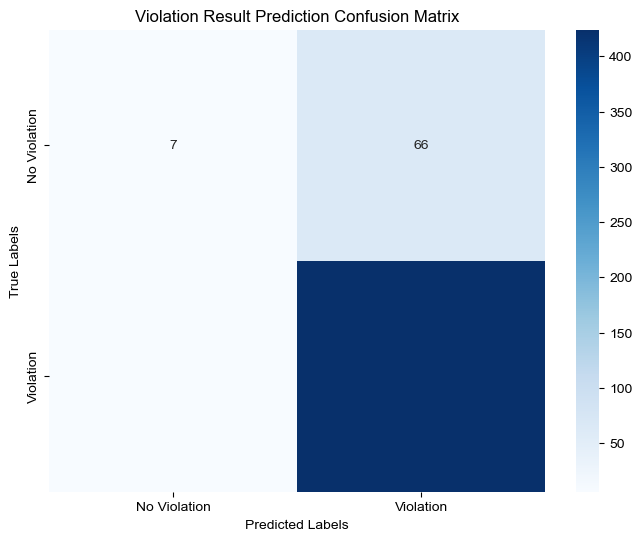

In [203]:
# Confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=['No Violation', 'Violation'],
           yticklabels=['No Violation', 'Violation'])
plt.title('Violation Result Prediction Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Top 10 most important features:
                                             feature  importance
17                             free_speech_exception    0.235081
18                                     gdpr_conflict    0.210660
0                               Affected_data_volume    0.192307
14  data_processing_basis_Performance_of_public_task    0.133931
6                  data_category_Basic_personal_data    0.093054
2                                               Date    0.044618
11                     data_processing_basis_Consent    0.033382
4                                            country    0.030960
13         data_processing_basis_Legitimate_interest    0.015595
3                                   company_industry    0.005470


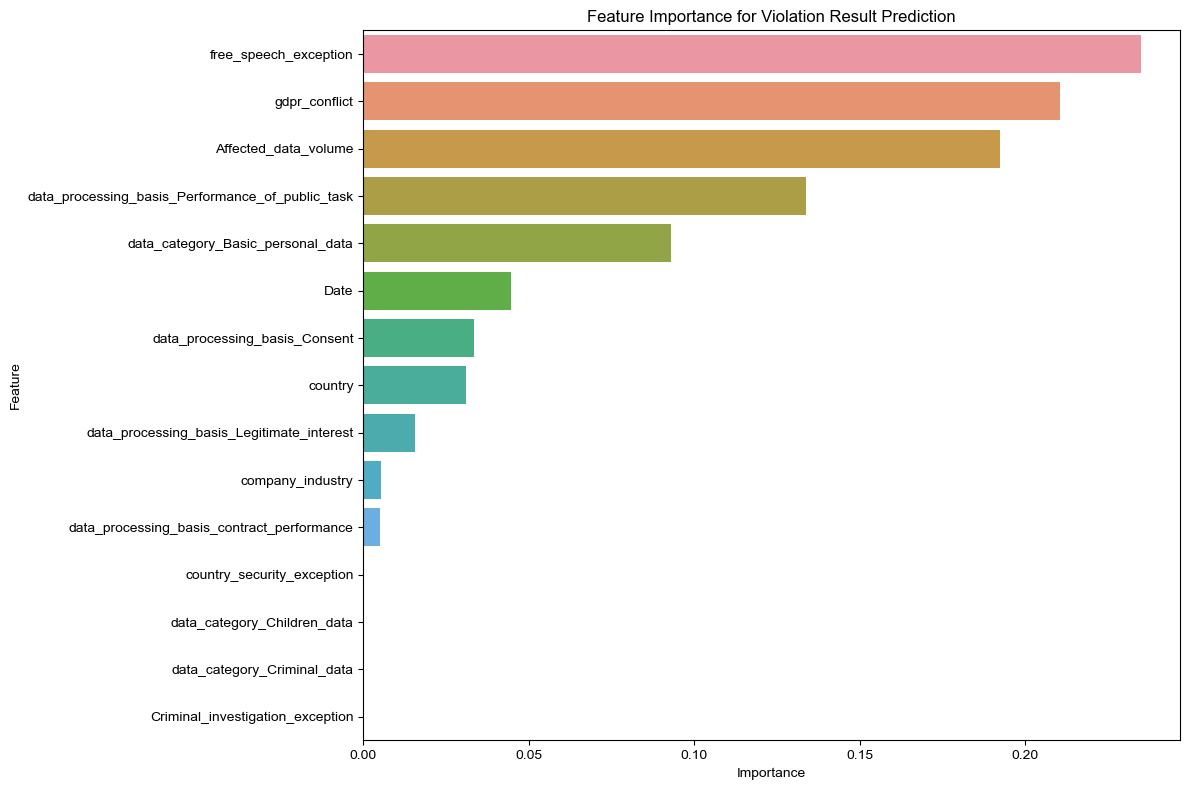

In [204]:
# Feature importance
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': final_violation_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 most important features:")
print(feature_importances.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(15))
plt.title('Feature Importance for Violation Result Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


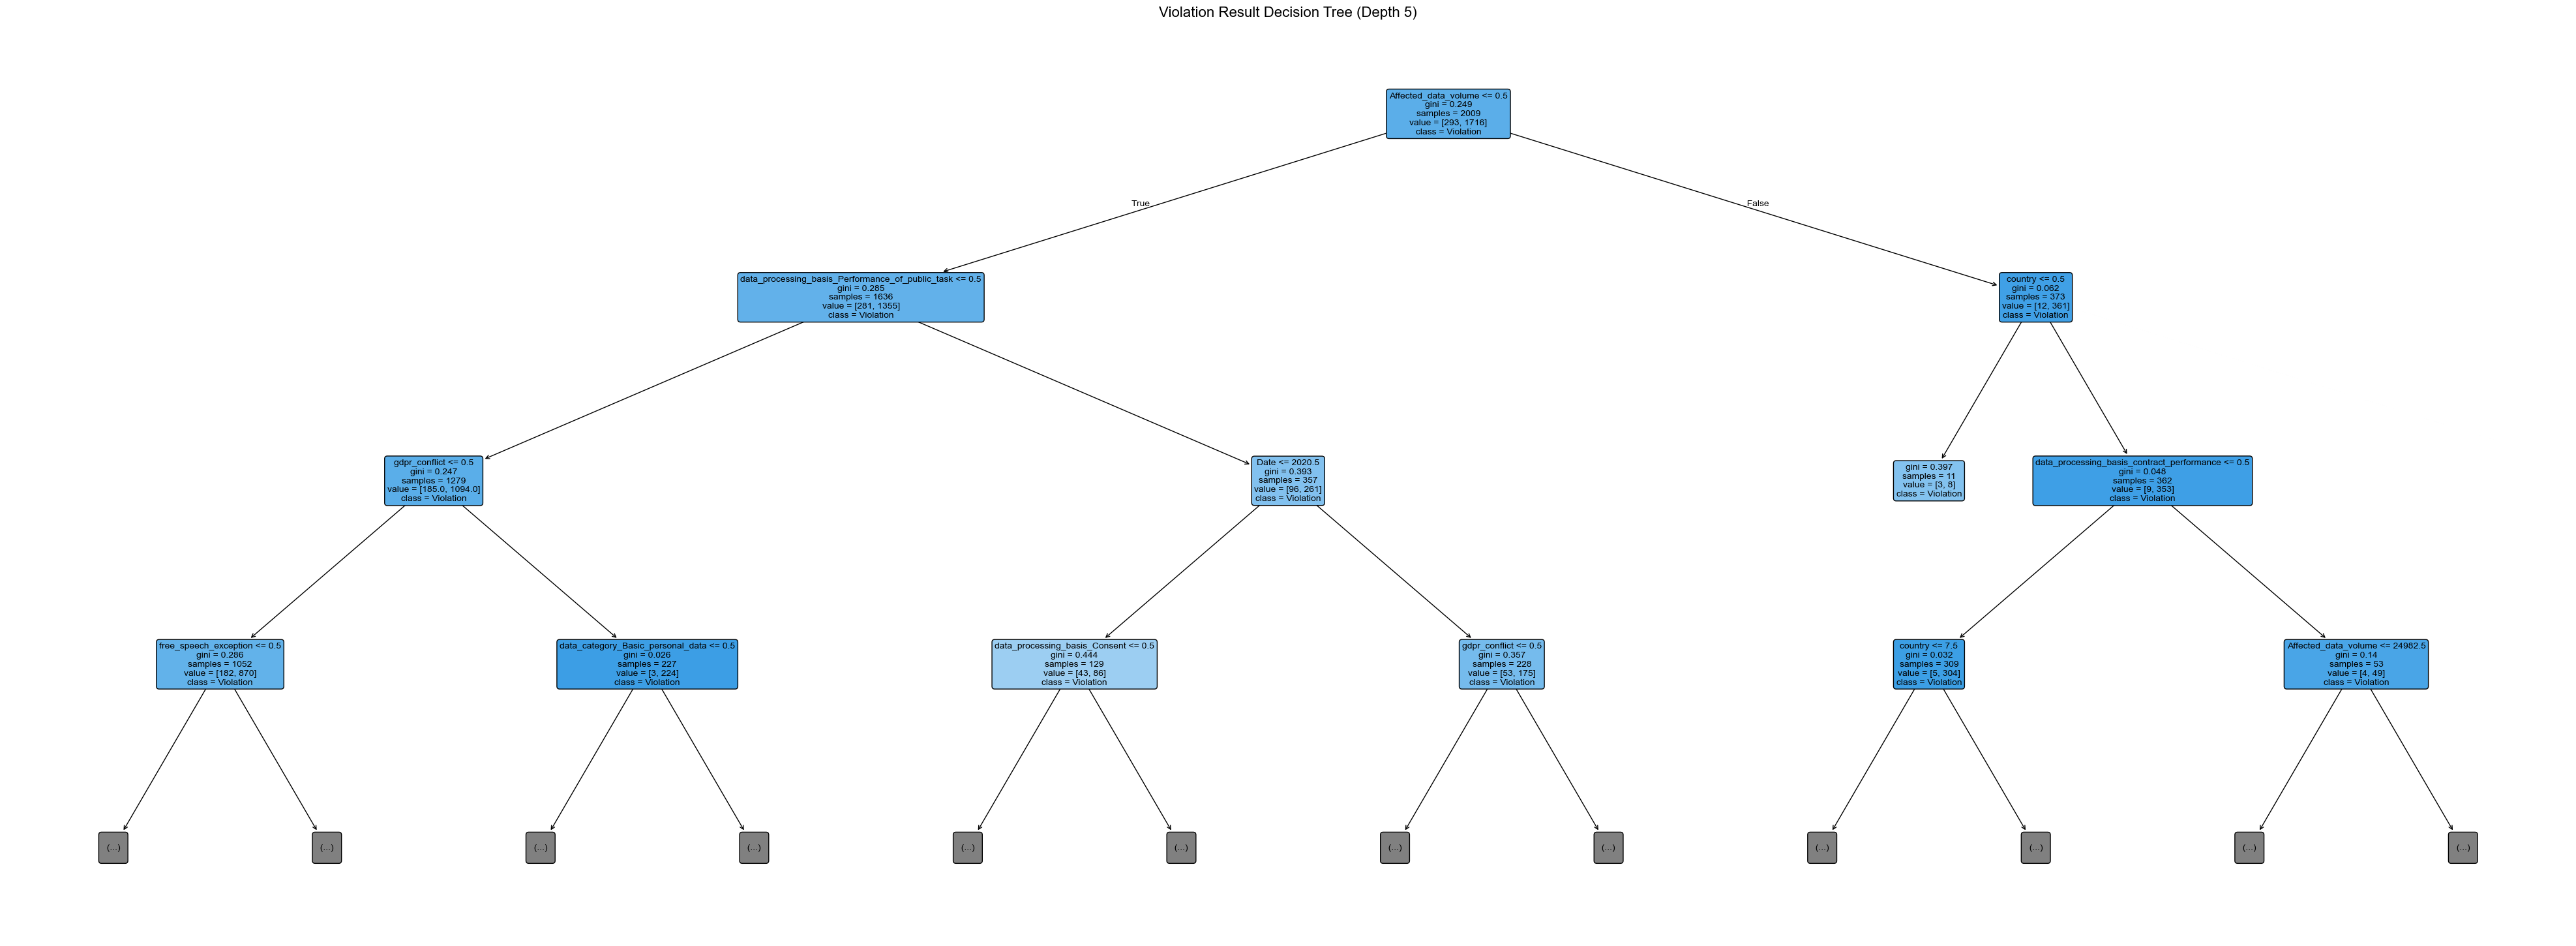

In [205]:
plt.figure(figsize=(40, 15))  # Larger image size to give the tree more space

plot_tree(final_violation_model, 
          feature_names=X.columns, 
          class_names=['No Violation', 'Violation'],
          filled=True, 
          rounded=True, 
          max_depth=3,
          fontsize=10)  # Removed unsupported 'orientation' parameter

plt.title('Violation Result Decision Tree (Depth 5)', fontsize=16)
plt.tight_layout(pad=2.5)  # Added more padding for spacing
plt.savefig('violation_tree_large.png', dpi=300, bbox_inches='tight')
plt.show()


In [206]:
from sklearn.tree import export_text

# Output decision tree rules
print("Violation Result Decision Tree Rules (Max Depth 5):")
tree_rules = export_text(final_violation_model, feature_names=list(X.columns), max_depth=3)
print(tree_rules)


Violation Result Decision Tree Rules (Max Depth 5):
|--- Affected_data_volume <= 0.50
|   |--- data_processing_basis_Performance_of_public_task <= 0.50
|   |   |--- gdpr_conflict <= 0.50
|   |   |   |--- free_speech_exception <= 0.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- free_speech_exception >  0.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- gdpr_conflict >  0.50
|   |   |   |--- data_category_Basic_personal_data <= 0.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- data_category_Basic_personal_data >  0.50
|   |   |   |   |--- class: 1
|   |--- data_processing_basis_Performance_of_public_task >  0.50
|   |   |--- Date <= 2020.50
|   |   |   |--- data_processing_basis_Consent <= 0.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- data_processing_basis_Consent >  0.50
|   |   |   |   |--- class: 0
|   |   |--- Date >  2020.50
|   |   |   |--- gdpr_conflict <= 0.50
|   |   |   |   |--- truncated branch

# Step 5. Training violation nature models

In [318]:
# Part 1: Train Multi-Label Violation Nature Classification Model

from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, jaccard_score
import numpy as np
import joblib

# 1. Prepare multi-label targets and input features
y_multilabel = np.column_stack([y_nature_dict[col] for col in y_nature_dict])
nature_columns = list(y_nature_dict.keys())

# Ensure features do NOT include the target columns
X_clean = X.drop(columns=[col for col in X.columns if col in nature_columns])

# 2. Split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_clean, y_multilabel, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print(f"Training set size: {X_train.shape}, Validation set size: {X_val.shape}, Test set size: {X_test.shape}")

# 3. Train baseline model
baseline_clf = MultiOutputClassifier(DecisionTreeClassifier(random_state=42))
baseline_clf.fit(X_train, y_train)
y_val_pred_baseline = baseline_clf.predict(X_val)

baseline_jaccard = jaccard_score(y_val, y_val_pred_baseline, average='samples', zero_division=1)
baseline_f1_micro = f1_score(y_val, y_val_pred_baseline, average='micro')
baseline_hamming = hamming_loss(y_val, y_val_pred_baseline)
baseline_acc = accuracy_score(y_val, y_val_pred_baseline)

print("\nBaseline Validation Metrics:")
print(f"Hamming Loss:       {baseline_hamming:.4f}")
print(f"Jaccard Score:      {baseline_jaccard:.4f}")
print(f"F1 Score (micro):   {baseline_f1_micro:.4f}")
print(f"Subset Accuracy:    {baseline_acc:.4f}")

# 4. Define best parameters manually
best_params = {
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'criterion': 'gini',
    'splitter': 'best',
    'max_features': None,
    'class_weight': 'balanced'
}

# 5. Train fine-tuned model
best_model = MultiOutputClassifier(DecisionTreeClassifier(**best_params, random_state=42))
best_model.fit(X_train, y_train)
y_val_pred_finetune = best_model.predict(X_val)

finetune_jaccard = jaccard_score(y_val, y_val_pred_finetune, average='samples', zero_division=1)
finetune_f1_micro = f1_score(y_val, y_val_pred_finetune, average='micro')
finetune_hamming = hamming_loss(y_val, y_val_pred_finetune)
finetune_acc = accuracy_score(y_val, y_val_pred_finetune)

# 6. Train final model on combined training and validation set
final_model = MultiOutputClassifier(DecisionTreeClassifier(**best_params, random_state=42))
final_model.fit(X_train_val, y_train_val)
y_pred = final_model.predict(X_test)

# 7. Evaluate final model
test_jaccard = jaccard_score(y_test, y_pred, average='samples')
test_f1_micro = f1_score(y_test, y_pred, average='micro')
test_hamming = hamming_loss(y_test, y_pred)
test_acc = accuracy_score(y_test, y_pred)

print("\nFinal Test Set Metrics:")
print(f"Hamming Loss:       {test_hamming:.4f}")
print(f"Jaccard Score:      {test_jaccard:.4f}")
print(f"F1 Score (micro):   {test_f1_micro:.4f}")
print(f"Subset Accuracy:    {test_acc:.4f}")

# 8. Compare baseline and fine-tuned models
print("\nBaseline vs Fine-Tuned Comparison on Validation Set")
print(f"{'Metric':<20} {'Baseline':<15} {'Fine-Tuned':<15} {'Improvement':<15}")
print("-" * 65)
print(f"{'Jaccard Score':<20} {baseline_jaccard:<15.4f} {finetune_jaccard:<15.4f} {finetune_jaccard - baseline_jaccard:<+15.4f}")
print(f"{'F1 Score (micro)':<20} {baseline_f1_micro:<15.4f} {finetune_f1_micro:<15.4f} {finetune_f1_micro - baseline_f1_micro:<+15.4f}")
print(f"{'Hamming Loss':<20} {baseline_hamming:<15.4f} {finetune_hamming:<15.4f} {baseline_hamming - finetune_hamming:<+15.4f}")
print(f"{'Subset Accuracy':<20} {baseline_acc:<15.4f} {finetune_acc:<15.4f} {finetune_acc - baseline_acc:<+15.4f}")

# 9. Save model
joblib.dump(final_model, 'multilabel_violation_nature_model.pkl')
print("\nModel saved as 'multilabel_violation_nature_model.pkl'")


Training set size: (1506, 21), Validation set size: (503, 21), Test set size: (503, 21)

Baseline Validation Metrics:
Hamming Loss:       0.2798
Jaccard Score:      0.5199
F1 Score (micro):   0.6667
Subset Accuracy:    0.2843

Final Test Set Metrics:
Hamming Loss:       0.3077
Jaccard Score:      0.4548
F1 Score (micro):   0.6597
Subset Accuracy:    0.2565

Baseline vs Fine-Tuned Comparison on Validation Set
Metric               Baseline        Fine-Tuned      Improvement    
-----------------------------------------------------------------
Jaccard Score        0.5199          0.5300          +0.0101        
F1 Score (micro)     0.6667          0.6555          -0.0112        
Hamming Loss         0.2798          0.2957          -0.0159        
Subset Accuracy      0.2843          0.2883          +0.0040        

Model saved as 'multilabel_violation_nature_model.pkl'


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Analyzing label co-occurrence patterns:
                                                    violation_nature_Breach_of_Data_processing_principle  \
violation_nature_Breach_of_Data_processing_prin...                                                  0      
violation_nature_Breach_of_data_security                                                           90      
violation_nature_Violation_of_Data_processing_o...                                                137      
violation_nature_Violation_of_data_subject_rights                                                 173      

                                                    violation_nature_Breach_of_data_security  \
violation_nature_Breach_of_Data_processing_prin...                                        90   
violation_nature_Breach_of_data_security                                                   0   
violation_nature_Violation_of_Data_processing_o...                                        61   
violation_nature_Violation_of_data

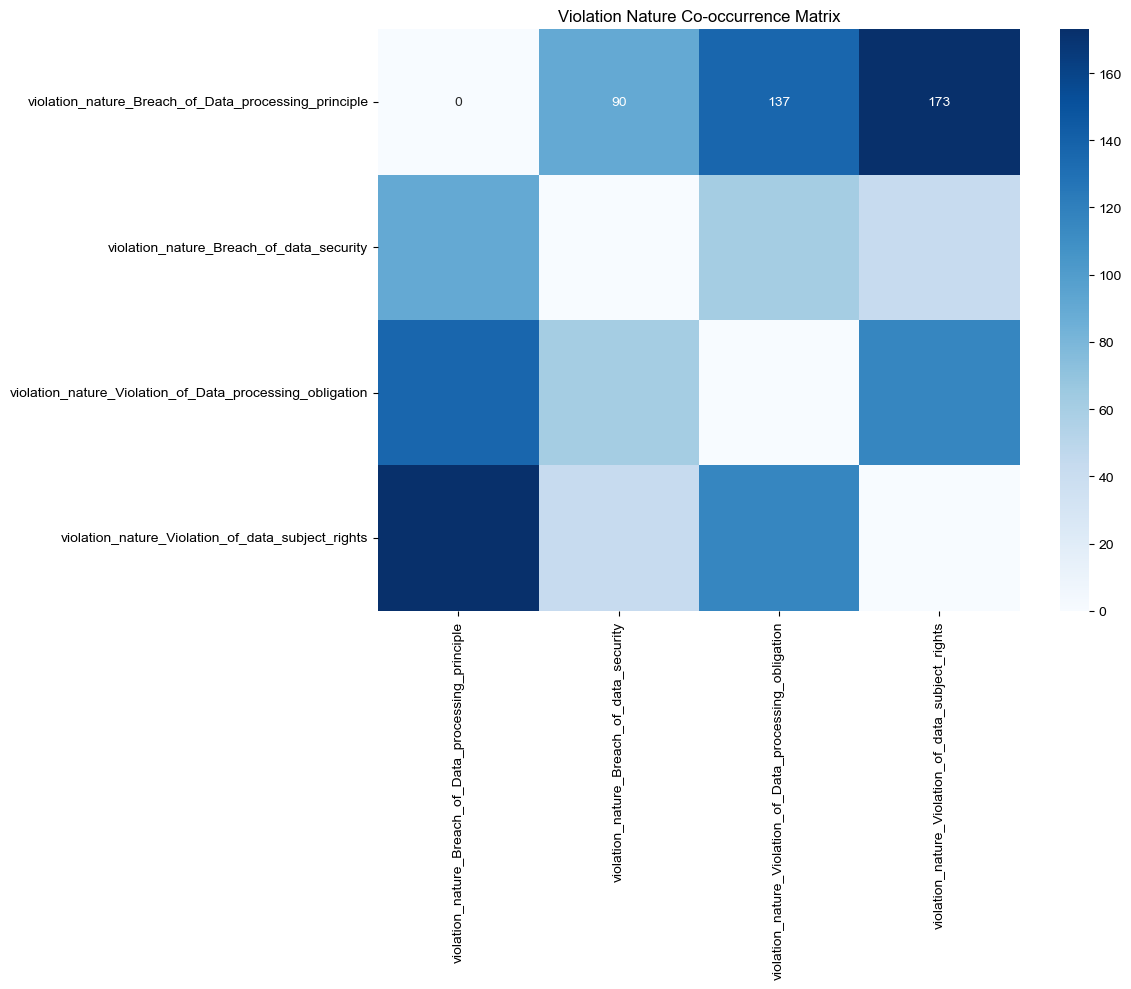


Comparison: Baseline vs Fine-Tuned (Validation Set)
Metric               Baseline        Fine-Tuned      Improvement    
-----------------------------------------------------------------
Jaccard Score        0.5199          0.5305          +0.0106        
F1 Score (micro)     0.6667          0.6647          -0.0020        
Hamming Loss         0.2798          0.1996          +0.0803        
Subset Accuracy      0.2843          0.2087          -0.0755        

Detailed Evaluation for Selected Label: violation_nature_Breach_of_Data_processing_principle
Confusion Matrix:
[[141  71]
 [ 89 202]]


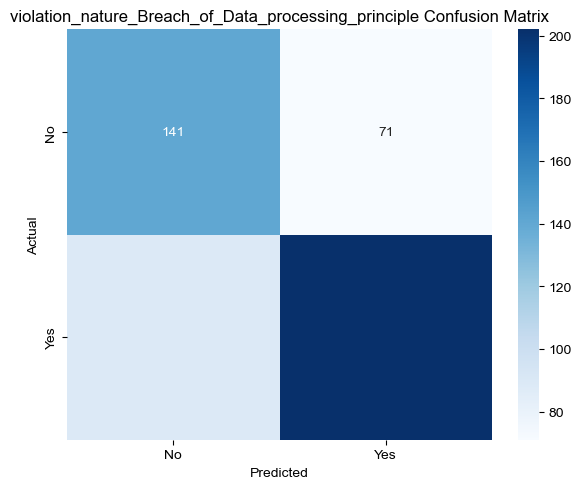

Top 10 Important Features for violation_nature_Breach_of_Data_processing_principle:
                                   feature  importance
20                        violation_result    0.285000
4                                  country    0.131212
17                             fine_amount    0.112868
6        data_category_Basic_personal_data    0.084368
3                         company_industry    0.053098
2                                     Date    0.052475
0                     Affected_data_volume    0.041560
19                           gdpr_conflict    0.040439
10     data_category_Special_category_data    0.040132
12  data_processing_basis_Legal_obligation    0.031351


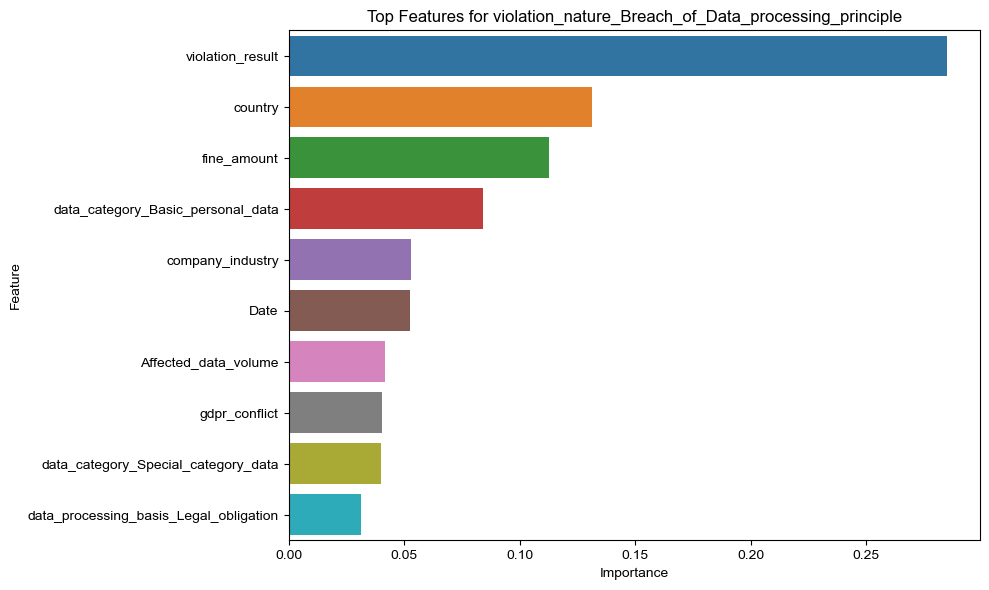

Tree complexity for violation_nature_Breach_of_Data_processing_principle:
Depth: 10, Nodes: 357


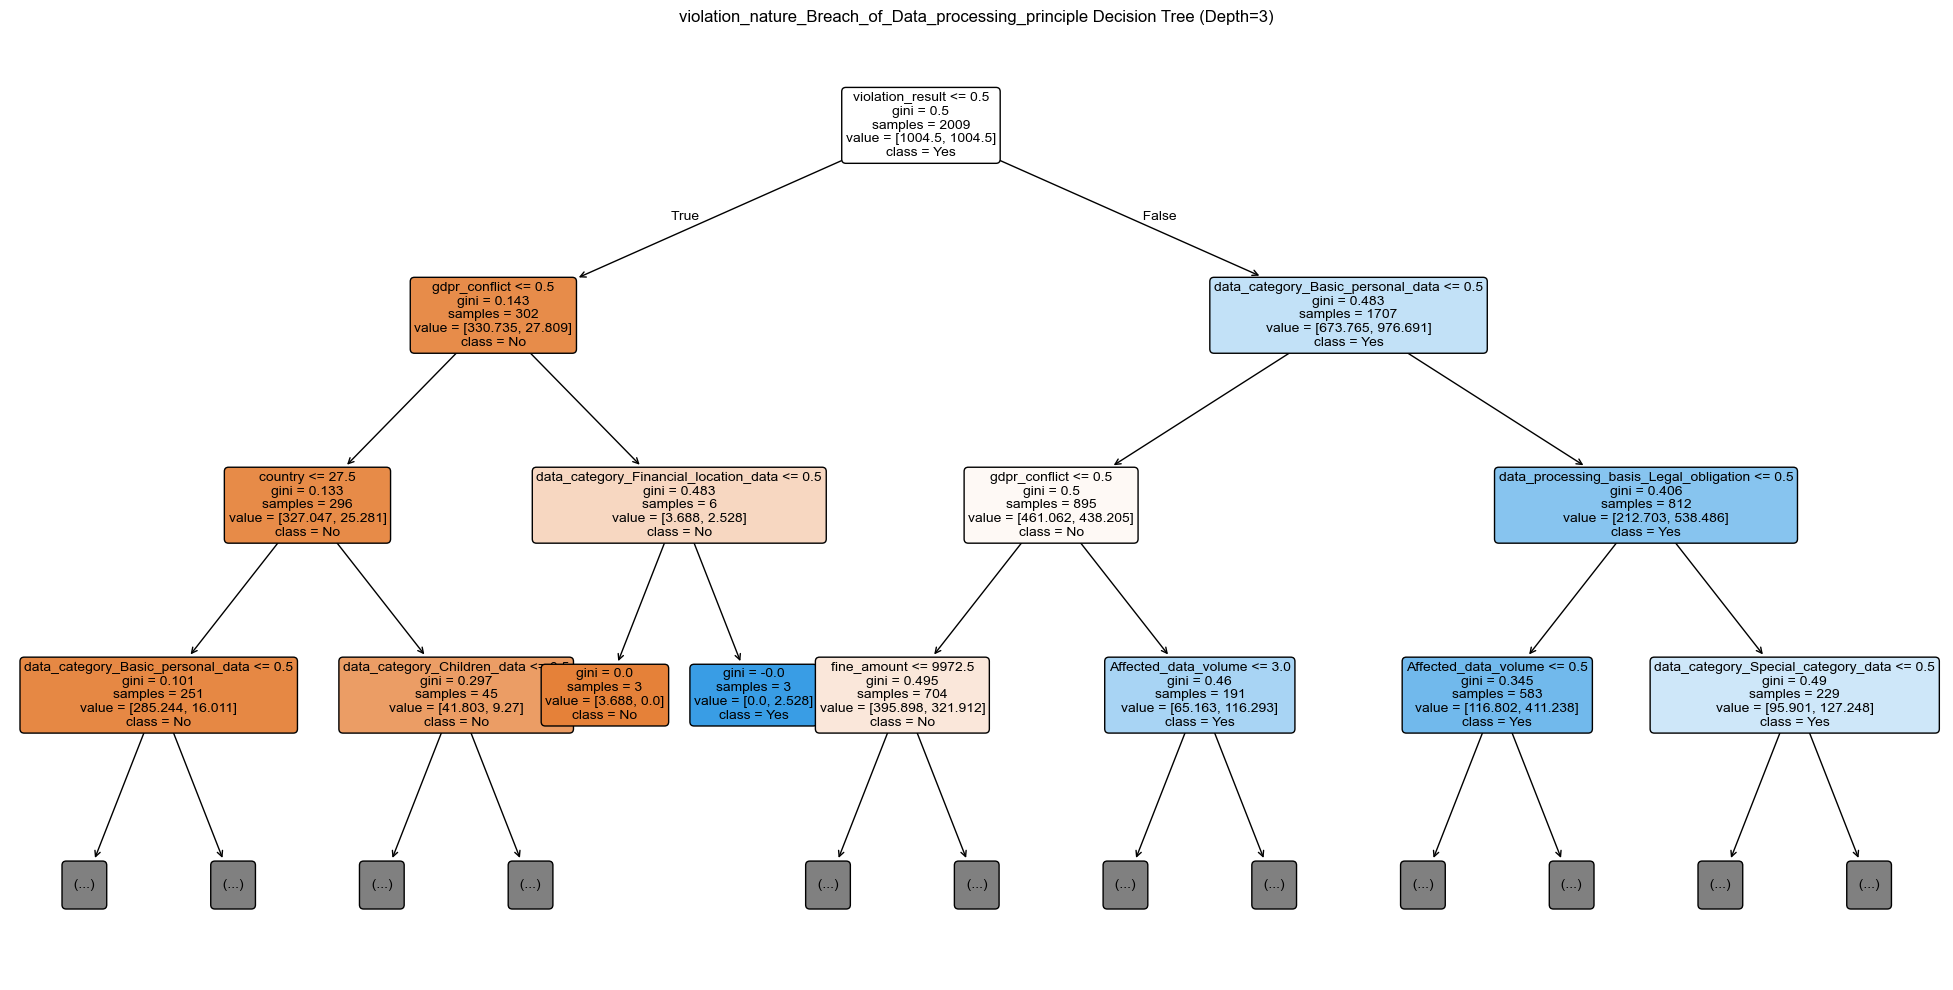


Decision Tree Rules for violation_nature_Breach_of_Data_processing_principle:
|--- violation_result <= 0.50
|   |--- gdpr_conflict <= 0.50
|   |   |--- country <= 27.50
|   |   |   |--- data_category_Basic_personal_data <= 0.50
|   |   |   |   |--- fine_amount <= 550000.00
|   |   |   |   |   |--- country <= 2.00
|   |   |   |   |   |   |--- company_industry <= 9.50
|   |   |   |   |   |   |   |--- data_processing_basis_Legitimate_interest <= 0.50
|   |   |   |   |   |   |   |   |--- fine_amount <= 750.00
|   |   |   |   |   |   |   |   |   |--- country <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- country >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- fine_amount >  750.00
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- data_processing_basis_Legitimate_interest >  0.50
|   |   |   |   |   |   |   |   |--- Date <= 2020.50
|   |   |   |   |   |

In [322]:
# Part 2: Visualization and Reporting for Violation Nature Multi-Label Classification

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# Ensure feature set matches model training input
X_clean = X.drop(columns=[col for col in X.columns if col in nature_columns])

# 1. Co-occurrence matrix of violation nature labels
print("\nAnalyzing label co-occurrence patterns:")
cooccurrence = y_test.T @ y_test
np.fill_diagonal(cooccurrence, 0)

cooccurrence_df = pd.DataFrame(cooccurrence, index=nature_columns, columns=nature_columns)
print(cooccurrence_df)

plt.figure(figsize=(12, 10))
sns.heatmap(cooccurrence_df, annot=True, fmt='d', cmap='Blues')
plt.title('Violation Nature Co-occurrence Matrix')
plt.tight_layout()
plt.show()

# 2. Baseline vs Fine-Tuned model performance on validation set
print("\nComparison: Baseline vs Fine-Tuned (Validation Set)")
print(f"{'Metric':<20} {'Baseline':<15} {'Fine-Tuned':<15} {'Improvement':<15}")
print("-" * 65)
print(f"{'Jaccard Score':<20} {baseline_jaccard:<15.4f} {best_score:<15.4f} {best_score - baseline_jaccard:<+15.4f}")
print(f"{'F1 Score (micro)':<20} {baseline_f1_micro:<15.4f} {f1_micro:<15.4f} {f1_micro - baseline_f1_micro:<+15.4f}")
print(f"{'Hamming Loss':<20} {baseline_hamming:<15.4f} {hamming:<15.4f} {baseline_hamming - hamming:<+15.4f}")
print(f"{'Subset Accuracy':<20} {baseline_acc:<15.4f} {subset_acc:<15.4f} {subset_acc - baseline_acc:<+15.4f}")

# 3. Visualize evaluation for a selected violation nature label
selected_index = 0
selected_label = nature_columns[selected_index]

print(f"\nDetailed Evaluation for Selected Label: {selected_label}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test[:, selected_index], y_pred[:, selected_index])
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title(f'{selected_label} Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Feature importance
estimator = final_model.estimators_[selected_index]
importances_df = pd.DataFrame({
    'feature': X_clean.columns,
    'importance': estimator.feature_importances_
}).sort_values(by='importance', ascending=False)

print(f"Top 10 Important Features for {selected_label}:")
print(importances_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importances_df.head(10))
plt.title(f'Top Features for {selected_label}')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Model complexity
print(f"Tree complexity for {selected_label}:")
print(f"Depth: {estimator.tree_.max_depth}, Nodes: {estimator.tree_.node_count}")

# Decision tree visualization
plt.figure(figsize=(20, 10))
plot_tree(estimator, feature_names=X_clean.columns, class_names=['No', 'Yes'],
          filled=True, rounded=True, max_depth=3, fontsize=10)
plt.title(f'{selected_label} Decision Tree (Depth=3)')
plt.tight_layout()
plt.show()

# Decision tree rules
print(f"\nDecision Tree Rules for {selected_label}:")
print(export_text(estimator, feature_names=list(X_clean.columns)))


In [324]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, jaccard_score

# Drop violation_nature target columns from features to avoid target leakage
target_columns = nature_columns  # this comes from your y_nature_dict keys
X_train_val_clean = X_train_val.drop(columns=[col for col in X_train_val.columns if col in target_columns])
X_test_clean = X_test.drop(columns=[col for col in X_test.columns if col in target_columns])

# Final retrain: baseline model with default parameters
baseline_final = MultiOutputClassifier(DecisionTreeClassifier(random_state=42))
baseline_final.fit(X_train_val_clean, y_train_val)

# Final retrain: fine-tuned model with selected best parameters
best_dt = DecisionTreeClassifier(**best_params, random_state=42)
final_model = MultiOutputClassifier(best_dt)
final_model.fit(X_train_val_clean, y_train_val)

# Predict on test set
y_test_pred_baseline = baseline_final.predict(X_test_clean)
y_test_pred_finetuned = final_model.predict(X_test_clean)

# Define evaluation function
def evaluate_model(y_true, y_pred, name=""):
    hamming = hamming_loss(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average='samples', zero_division=1)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=1)
    subset_acc = accuracy_score(y_true, y_pred)
    
    print(f"\n{name} Model on Test Set:")
    print(f"Hamming Loss:       {hamming:.4f}")
    print(f"Jaccard Score:      {jaccard:.4f}")
    print(f"F1 Score (micro):   {f1_micro:.4f}")
    print(f"Subset Accuracy:    {subset_acc:.4f}")
    
    return jaccard, f1_micro, hamming, subset_acc

# Evaluate and compare
baseline_scores = evaluate_model(y_test, y_test_pred_baseline, "Baseline")
finetuned_scores = evaluate_model(y_test, y_test_pred_finetuned, "Fine-Tuned")

print("\nComparison: Baseline vs Fine-Tuned (Test Set)")
print(f"{'Metric':<20} {'Baseline':<15} {'Fine-Tuned':<15} {'Improvement':<15}")
print("-" * 65)
metrics = ["Jaccard Score", "F1 Score (micro)", "Hamming Loss", "Subset Accuracy"]
for i, metric in enumerate(metrics):
    base = baseline_scores[i]
    fine = finetuned_scores[i]
    improvement = fine - base if metric != "Hamming Loss" else base - fine  # Lower is better for Hamming Loss
    print(f"{metric:<20} {base:<15.4f} {fine:<15.4f} {improvement:<+15.4f}")



Baseline Model on Test Set:
Hamming Loss:       0.2987
Jaccard Score:      0.5302
F1 Score (micro):   0.6564
Subset Accuracy:    0.2485

Fine-Tuned Model on Test Set:
Hamming Loss:       0.3077
Jaccard Score:      0.5323
F1 Score (micro):   0.6597
Subset Accuracy:    0.2565

Comparison: Baseline vs Fine-Tuned (Test Set)
Metric               Baseline        Fine-Tuned      Improvement    
-----------------------------------------------------------------
Jaccard Score        0.5302          0.5323          +0.0022        
F1 Score (micro)     0.6564          0.6597          +0.0033        
Hamming Loss         0.2987          0.3077          -0.0089        
Subset Accuracy      0.2485          0.2565          +0.0080        


# Step 6. Train the fine_amount model

In [224]:
# %%
# 6.1 Create a binary classification problem for whether a fine was imposed
y_fine_binary = (y_fine > 0).astype(int)
print(f"Binary labels for fine or no fine distribution: {y_fine_binary.value_counts().to_dict()}")

# Split the data into training, validation, and test sets
X_fine_train_val, X_fine_test, y_fine_binary_train_val, y_fine_binary_test = train_test_split(
    X, y_fine_binary, test_size=0.2, random_state=42, stratify=y_fine_binary
)
X_fine_train, X_fine_val, y_fine_binary_train, y_fine_binary_val = train_test_split(
    X_fine_train_val, y_fine_binary_train_val, test_size=0.25, random_state=42, stratify=y_fine_binary_train_val
)

print(f"Binary classification - Training set size: {X_fine_train.shape}, Validation set size: {X_fine_val.shape}, Test set size: {X_fine_test.shape}")


Binary labels for fine or no fine distribution: {0: 1391, 1: 1121}
Binary classification - Training set size: (1506, 19), Validation set size: (503, 19), Test set size: (503, 19)


In [225]:
# %%
# Train the binary classification model
print("Training the fine (yes/no) classification model...")

# Define parameter grid
param_grid_binary = {
    'max_depth': [3, 5, 7, 10],
    'criterion': ['gini', 'entropy']
}

# Manually perform parameter search on the validation set
best_binary_score = 0
best_binary_params = {}
best_binary_model = None

for max_depth in param_grid_binary['max_depth']:
    for criterion in param_grid_binary['criterion']:
        # Configure current parameter combination
        dt_binary = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=2,
            min_samples_leaf=1,
            criterion=criterion,
            random_state=42
        )
        
        # Train the model on the training set
        dt_binary.fit(X_fine_train, y_fine_binary_train)
        
        # Evaluate on the validation set
        val_binary_score = accuracy_score(y_fine_binary_val, dt_binary.predict(X_fine_val))
        
        print(f"Parameters: depth={max_depth}, criterion={criterion}, score: {val_binary_score:.4f}")
        
        # Update best parameters if a better model is found
        if val_binary_score > best_binary_score:
            best_binary_score = val_binary_score
            best_binary_params = {
                'max_depth': max_depth,
                'criterion': criterion
            }
            best_binary_model = dt_binary

print(f"Best parameters for fine binary classification: {best_binary_params}")
print(f"Best validation score: {best_binary_score:.4f}")



Training the fine (yes/no) classification model...
Parameters: depth=3, criterion=gini, score: 0.6243
Parameters: depth=3, criterion=entropy, score: 0.6243
Parameters: depth=5, criterion=gini, score: 0.6342
Parameters: depth=5, criterion=entropy, score: 0.6342
Parameters: depth=7, criterion=gini, score: 0.5626
Parameters: depth=7, criterion=entropy, score: 0.5686
Parameters: depth=10, criterion=gini, score: 0.5984
Parameters: depth=10, criterion=entropy, score: 0.5765
Best parameters for fine binary classification: {'max_depth': 5, 'criterion': 'gini'}
Best validation score: 0.6342


Test set accuracy for fine classification: 0.6382
              precision    recall  f1-score   support

           0       0.68      0.67      0.67       279
           1       0.59      0.60      0.60       224

    accuracy                           0.64       503
   macro avg       0.63      0.63      0.63       503
weighted avg       0.64      0.64      0.64       503



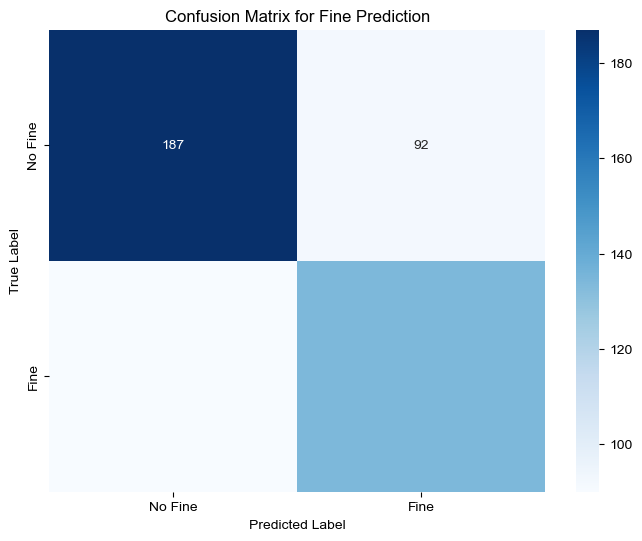

In [226]:
# Retrain the final binary classification model on the full training set
final_binary_model = DecisionTreeClassifier(
    max_depth=best_binary_params['max_depth'],
    min_samples_split=2,
    min_samples_leaf=1,
    criterion=best_binary_params['criterion'],
    random_state=42
)
final_binary_model.fit(X_fine_train_val, y_fine_binary_train_val)

# Evaluate the binary classification model on the test set
y_pred_binary = final_binary_model.predict(X_fine_test)
accuracy_binary = accuracy_score(y_fine_binary_test, y_pred_binary)
print(f"Test set accuracy for fine classification: {accuracy_binary:.4f}")
print(classification_report(y_fine_binary_test, y_pred_binary))

# Confusion matrix
conf_matrix_binary = confusion_matrix(y_fine_binary_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_binary, annot=True, fmt='d', cmap='Blues',
           xticklabels=['No Fine', 'Fine'],
           yticklabels=['No Fine', 'Fine'])
plt.title('Confusion Matrix for Fine Prediction')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



Visualizing the best fine binary decision tree...


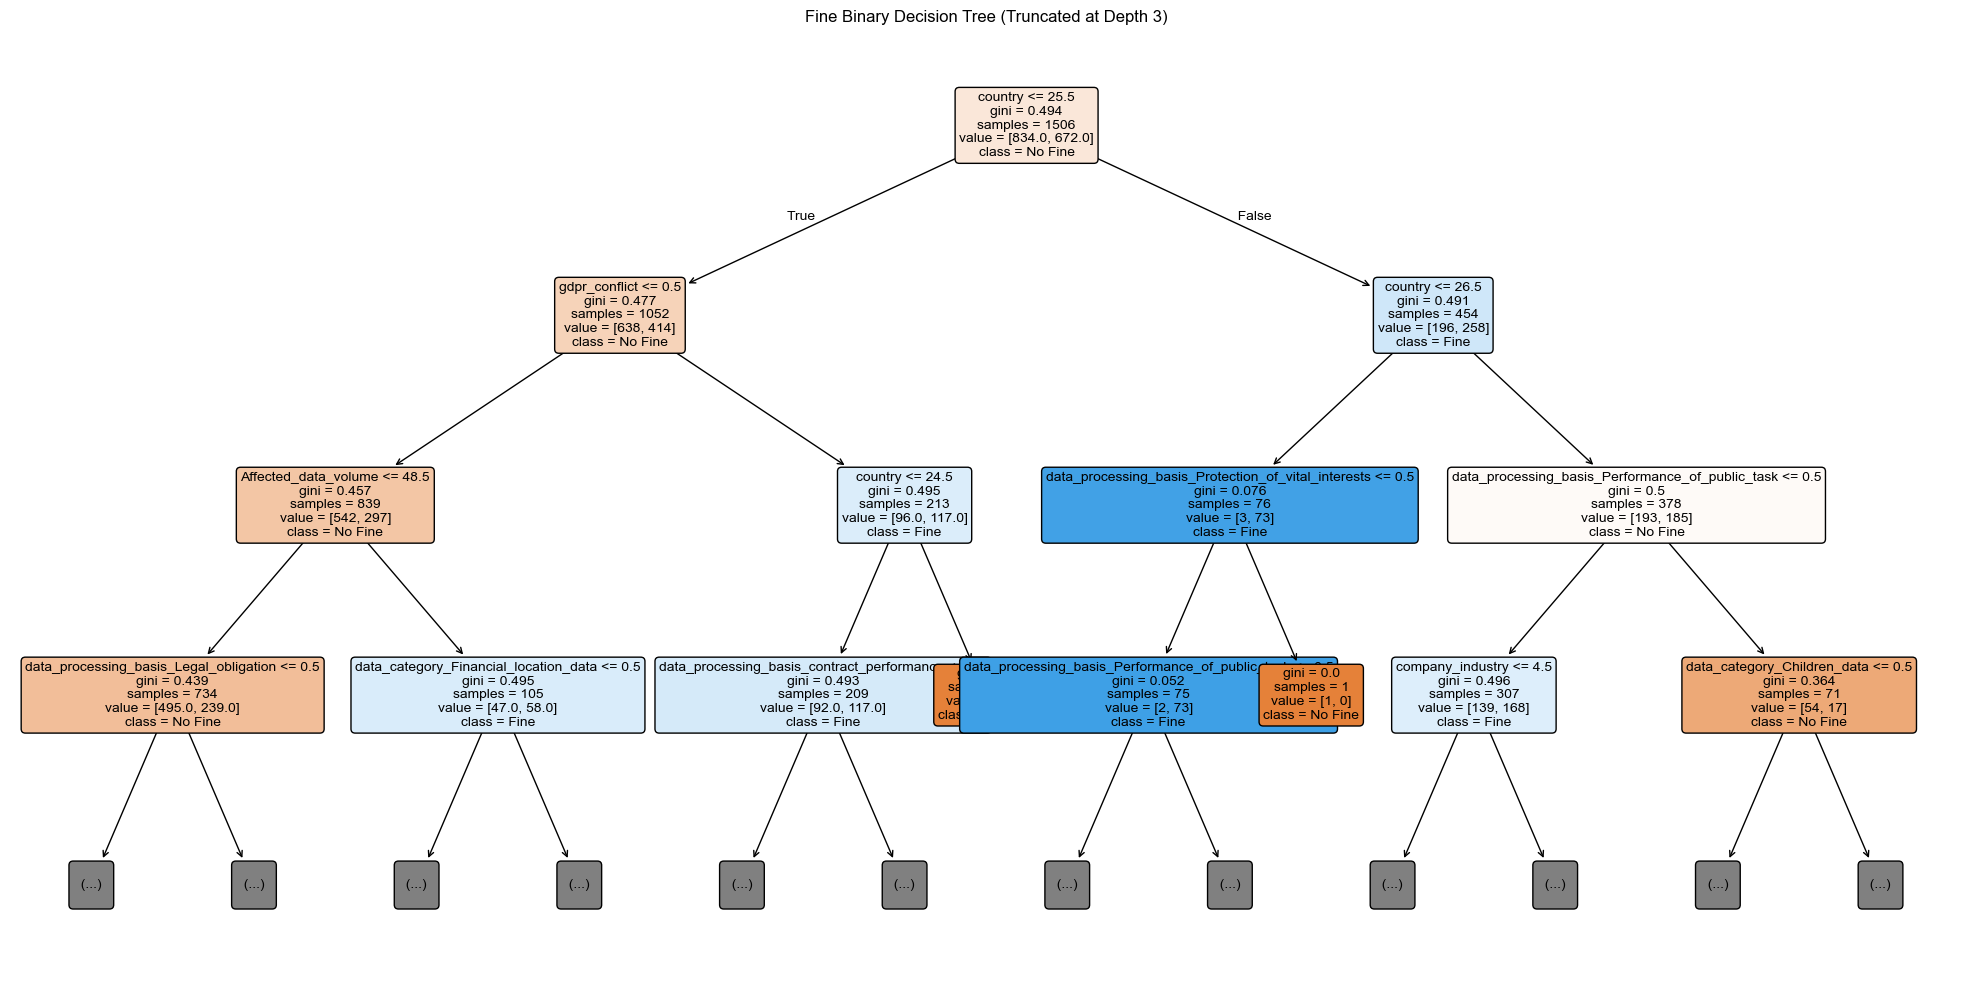


Full Decision Tree Rules:
|--- country <= 25.50
|   |--- gdpr_conflict <= 0.50
|   |   |--- Affected_data_volume <= 48.50
|   |   |   |--- data_processing_basis_Legal_obligation <= 0.50
|   |   |   |   |--- free_speech_exception <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- free_speech_exception >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- data_processing_basis_Legal_obligation >  0.50
|   |   |   |   |--- data_category_Criminal_data <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- data_category_Criminal_data >  0.50
|   |   |   |   |   |--- class: 0
|   |   |--- Affected_data_volume >  48.50
|   |   |   |--- data_category_Financial_location_data <= 0.50
|   |   |   |   |--- country <= 22.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- country >  22.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- data_category_Financial_location_data >  0.50
|   |   |   |   |--- country <= 17.00
|   |   |   |   |   |--- class: 1
|   |   |   

In [325]:
# %%
# Visualize the decision tree structure for the fine (yes/no) classifier
from sklearn.tree import plot_tree, export_text
import matplotlib.pyplot as plt

print("\nVisualizing the best fine binary decision tree...")

# Plot the decision tree structure
plt.figure(figsize=(20, 10))
plot_tree(best_binary_model,
          feature_names=X_fine_train.columns,
          class_names=['No Fine', 'Fine'],
          filled=True,
          rounded=True,
          max_depth=3,  # limit depth for clarity
          fontsize=10)
plt.title("Fine Binary Decision Tree (Truncated at Depth 3)")
plt.tight_layout()
plt.show()

# Export full decision rules as text
print("\nFull Decision Tree Rules:")
tree_rules = export_text(best_binary_model, feature_names=list(X_fine_train.columns))
print(tree_rules)

Number of non-zero fine samples: 1121
Min fine amount: 100.00, Max fine amount: 3525870795.00
Mean fine amount: 17616783.78, Median fine amount: 20000.00


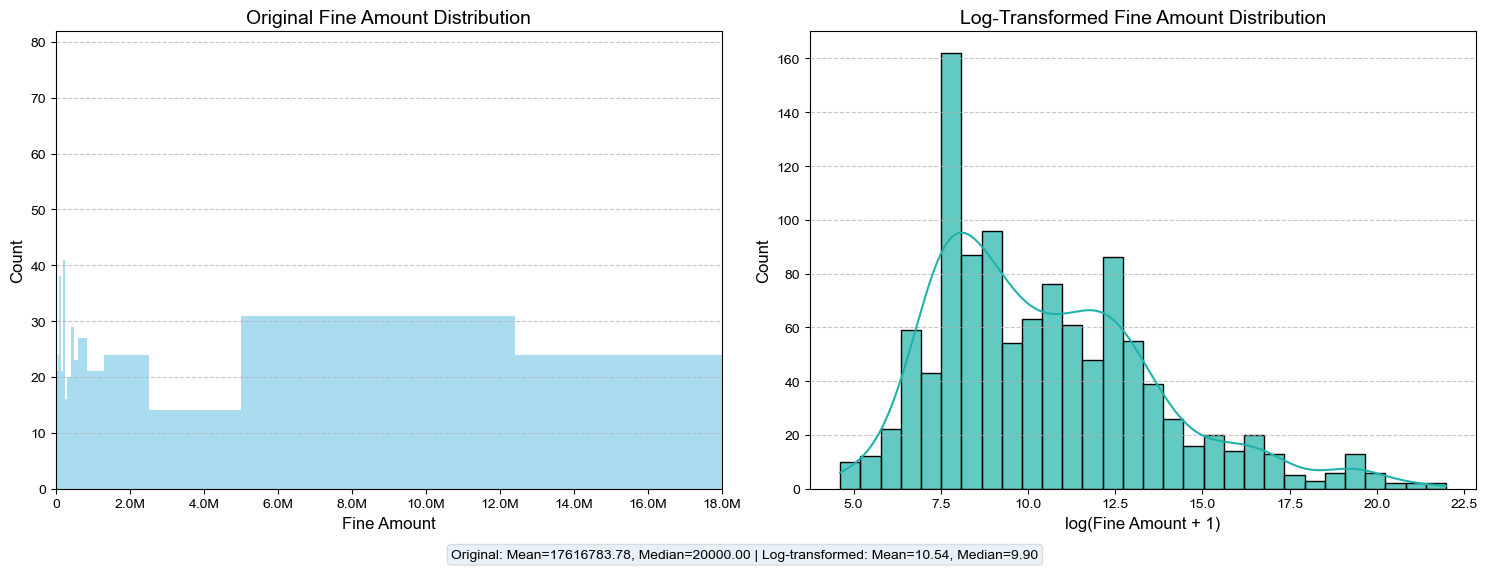

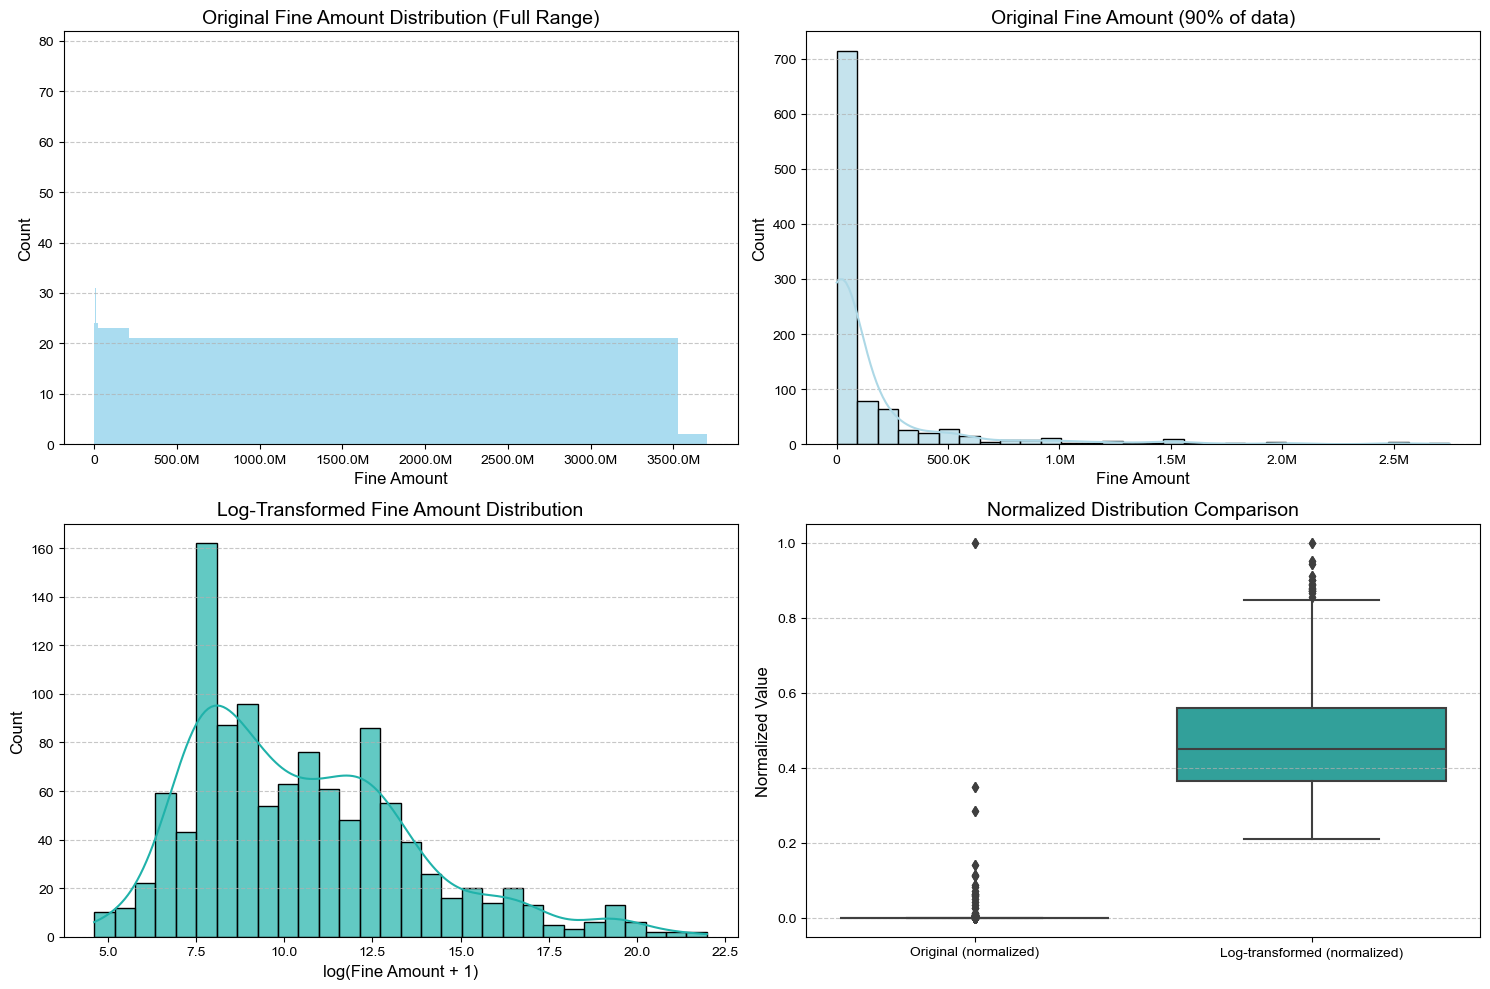

In [227]:
from matplotlib.ticker import FuncFormatter

# 6.2 Regression on non-zero fine amounts
# Filter out non-zero fine data
X_nonzero = X[y_fine > 0]
y_fine_nonzero = y_fine[y_fine > 0]

# Apply logarithmic transformation to fine amounts to handle skewed distribution
y_fine_log = np.log1p(y_fine_nonzero)

print(f"Number of non-zero fine samples: {len(y_fine_nonzero)}")
print(f"Min fine amount: {np.min(y_fine_nonzero):.2f}, Max fine amount: {np.max(y_fine_nonzero):.2f}")
print(f"Mean fine amount: {np.mean(y_fine_nonzero):.2f}, Median fine amount: {np.median(y_fine_nonzero):.2f}")

# Visualize the distribution before and after transformation
plt.figure(figsize=(15, 6))

# Original distribution with better visualization
plt.subplot(1, 2, 1)
# Using bins with percentile-based edges to better show the distribution
percentiles = np.percentile(y_fine_nonzero, np.linspace(0, 100, 50))
# Ensure unique bins
percentiles = np.unique(percentiles)
# Add some padding to the max value
percentiles = np.append(percentiles, percentiles[-1] * 1.05)

sns.histplot(y_fine_nonzero, bins=percentiles, kde=False, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Original Fine Amount Distribution', fontsize=14)
plt.xlabel('Fine Amount', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Format x-axis to show thousands/millions properly
def format_func(x, pos):
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.1f}K'
    else:
        return f'{x:.0f}'

plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))

# Focus on the main part of the distribution (optionally)
# Get the 95th percentile to set a reasonable x-axis limit
upper_limit = np.percentile(y_fine_nonzero, 95)
plt.xlim(0, upper_limit)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Log-transformed distribution
plt.subplot(1, 2, 2)
sns.histplot(y_fine_log, bins=30, kde=True, color='lightseagreen', edgecolor='black', alpha=0.7)
plt.title('Log-Transformed Fine Amount Distribution', fontsize=14)
plt.xlabel('log(Fine Amount + 1)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add statistical information
plt.figtext(0.5, 0.01, 
            f"Original: Mean={np.mean(y_fine_nonzero):.2f}, Median={np.median(y_fine_nonzero):.2f} | " +
            f"Log-transformed: Mean={np.mean(y_fine_log):.2f}, Median={np.median(y_fine_log):.2f}",
            ha='center', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Alternative visualization: Create a zoomed inset for the original distribution
plt.figure(figsize=(15, 10))

# Main distribution plot
plt.subplot(2, 2, 1)
sns.histplot(y_fine_nonzero, bins=percentiles, kde=False, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Original Fine Amount Distribution (Full Range)', fontsize=14)
plt.xlabel('Fine Amount', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Zoomed in view (90% of the data)
plt.subplot(2, 2, 2)
zoom_limit = np.percentile(y_fine_nonzero, 90)
sns.histplot(y_fine_nonzero[y_fine_nonzero <= zoom_limit], 
             bins=30, kde=True, color='lightblue', edgecolor='black', alpha=0.7)
plt.title('Original Fine Amount (90% of data)', fontsize=14)
plt.xlabel('Fine Amount', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Log-transformed distribution
plt.subplot(2, 2, 3)
sns.histplot(y_fine_log, bins=30, kde=True, color='lightseagreen', edgecolor='black', alpha=0.7)
plt.title('Log-Transformed Fine Amount Distribution', fontsize=14)
plt.xlabel('log(Fine Amount + 1)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Boxplot comparison
plt.subplot(2, 2, 4)
# Create a DataFrame for side-by-side boxplots
import pandas as pd
comparison_df = pd.DataFrame({
    'Original (normalized)': y_fine_nonzero / np.max(y_fine_nonzero),
    'Log-transformed (normalized)': y_fine_log / np.max(y_fine_log)
})
sns.boxplot(data=comparison_df, palette=['skyblue', 'lightseagreen'])
plt.title('Normalized Distribution Comparison', fontsize=14)
plt.ylabel('Normalized Value', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [228]:
# Split the training, validation, and test sets
X_reg_train_val, X_reg_test, y_reg_train_val, y_reg_test = train_test_split(
    X_nonzero, y_fine_log, test_size=0.2, random_state=42
)
X_reg_train, X_reg_val, y_reg_train, y_reg_val = train_test_split(
    X_reg_train_val, y_reg_train_val, test_size=0.25, random_state=42
)

print(f"Regression - Training set size: {X_reg_train.shape}, Validation set size: {X_reg_val.shape}, Test set size: {X_reg_test.shape}")


Regression - Training set size: (672, 19), Validation set size: (224, 19), Test set size: (225, 19)


Training models and comparing performance...
Dataset sizes:
  Training set: (672, 19)
  Validation set: (224, 19)
  Test set: (225, 19)
Data is log-transformed, will calculate metrics in both log and original spaces

1. Training baseline decision tree model (default parameters)...
   Baseline model training time: 0.0454 seconds

Baseline decision tree model evaluation results:
   Baseline model default parameters: max_depth=None, min_samples_split=2, min_samples_leaf=1
   Training set MSE (log space): 0.444342
   Validation set MSE (log space): 19.523362
   Test set MSE (log space): 15.360494
   Training set MSE (original space): 1578606355735.28
   Validation set MSE (original space): 4017864551023237.50
   Test set MSE (original space): 8402638116487064.00
   Training set R²: 0.9567
   Validation set R²: -0.8481
   Test set R²: -0.7631

2. Training optimized decision tree model (using grid search)...
Fitting 5 folds for each of 450 candidates, totalling 2250 fits


python(8738) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8739) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8740) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8741) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8742) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8743) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8744) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8745) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


   Optimized model search+training time: 4.0870 seconds
   Best parameters: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 20}
   Best cross-validation score (neg MSE): -9.828175

Optimized decision tree model evaluation results:
   Training set MSE (log space): 8.355290
   Validation set MSE (log space): 10.676856
   Test set MSE (log space): 7.950867
   Training set MSE (original space): 44035061261707696.00
   Validation set MSE (original space): 3182512576270528.00
   Test set MSE (original space): 7277304256004306.00
   Training set R²: 0.1858
   Validation set R²: -0.0107
   Test set R²: 0.0874

3. Performance improvement analysis:
   Performance improvements on validation set:
     MSE improvement (log space): 45.31%
     MSE improvement (original space): 20.79%
     R² improvement: 98.74%

   Performance improvements on test set:
     MSE improvement (log space): 48.24%
     MSE improvement (original space): 13.39%
     R² improvement: 111.45

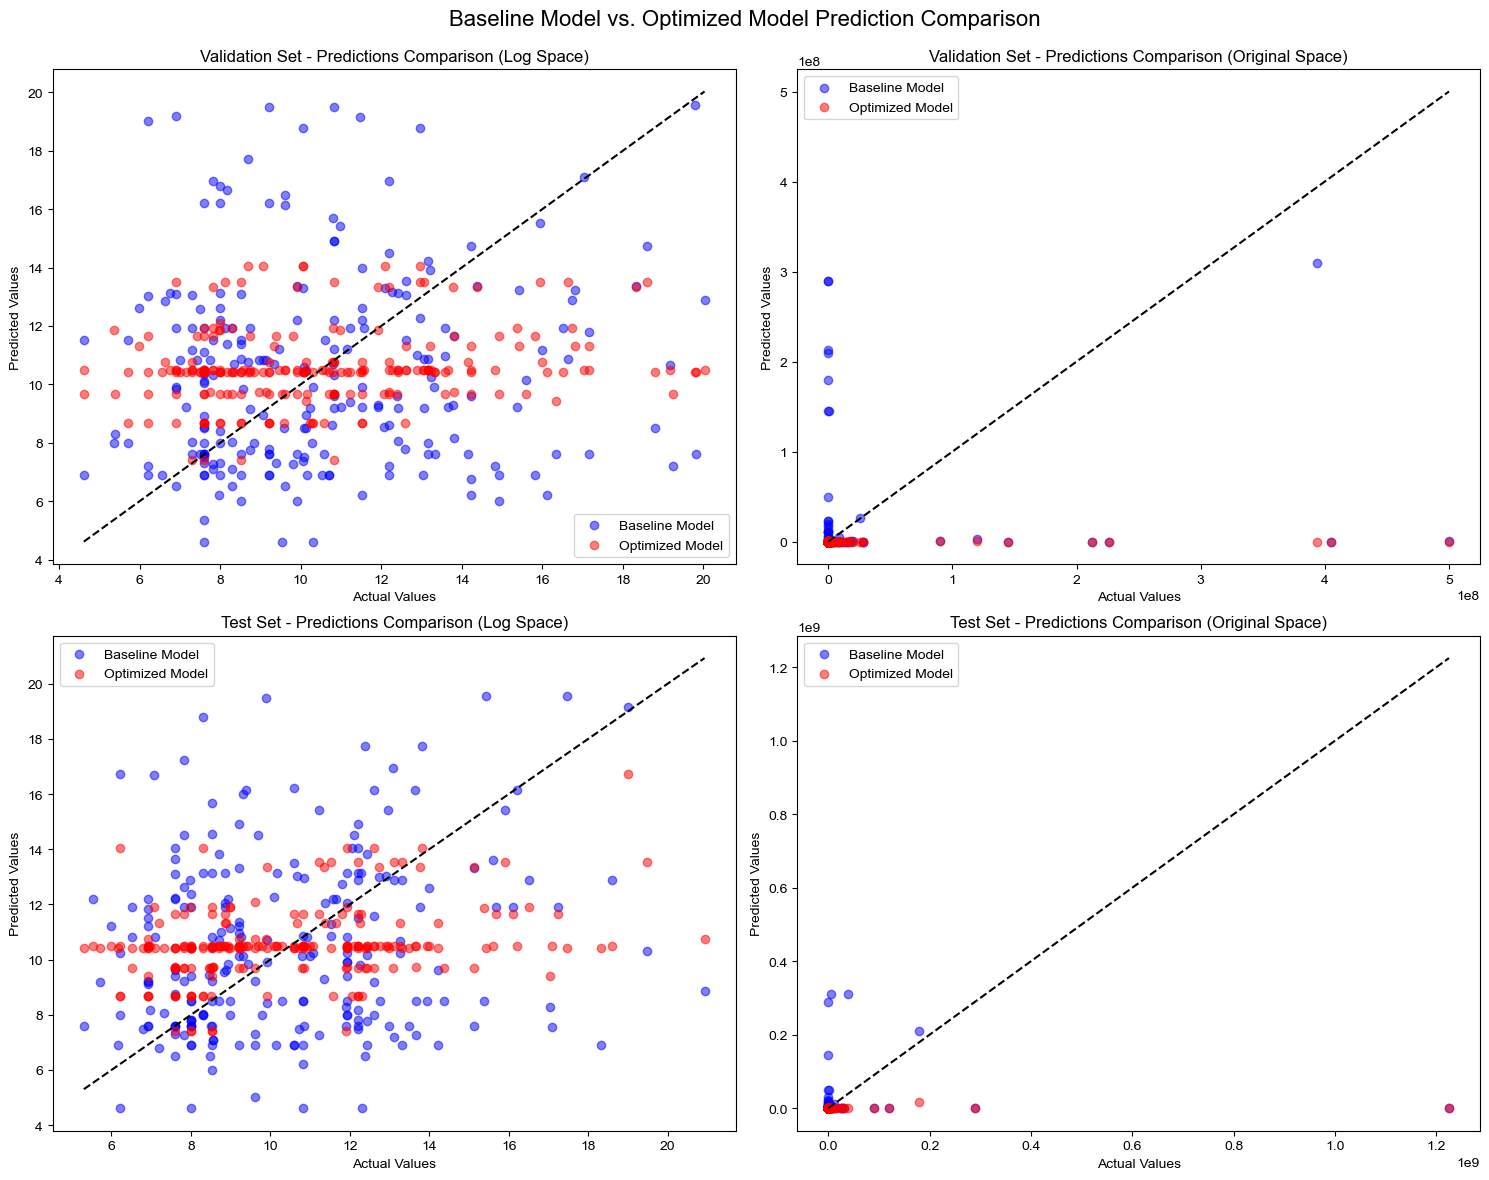

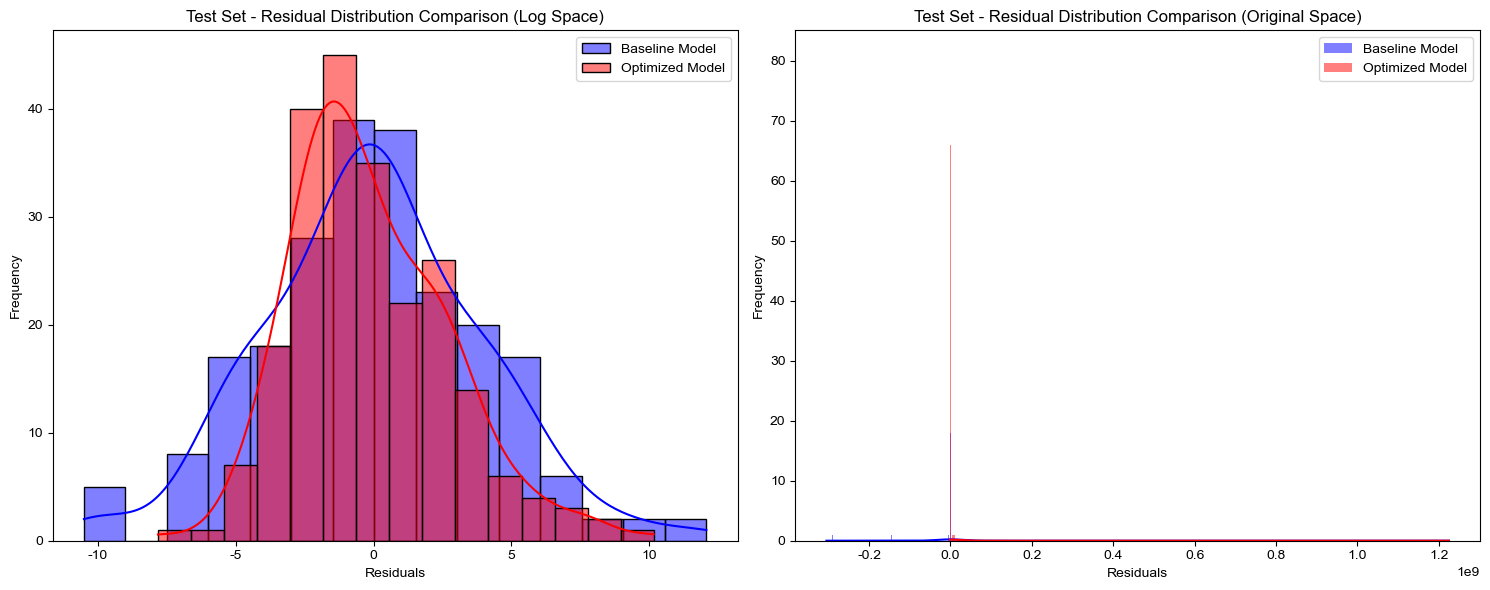

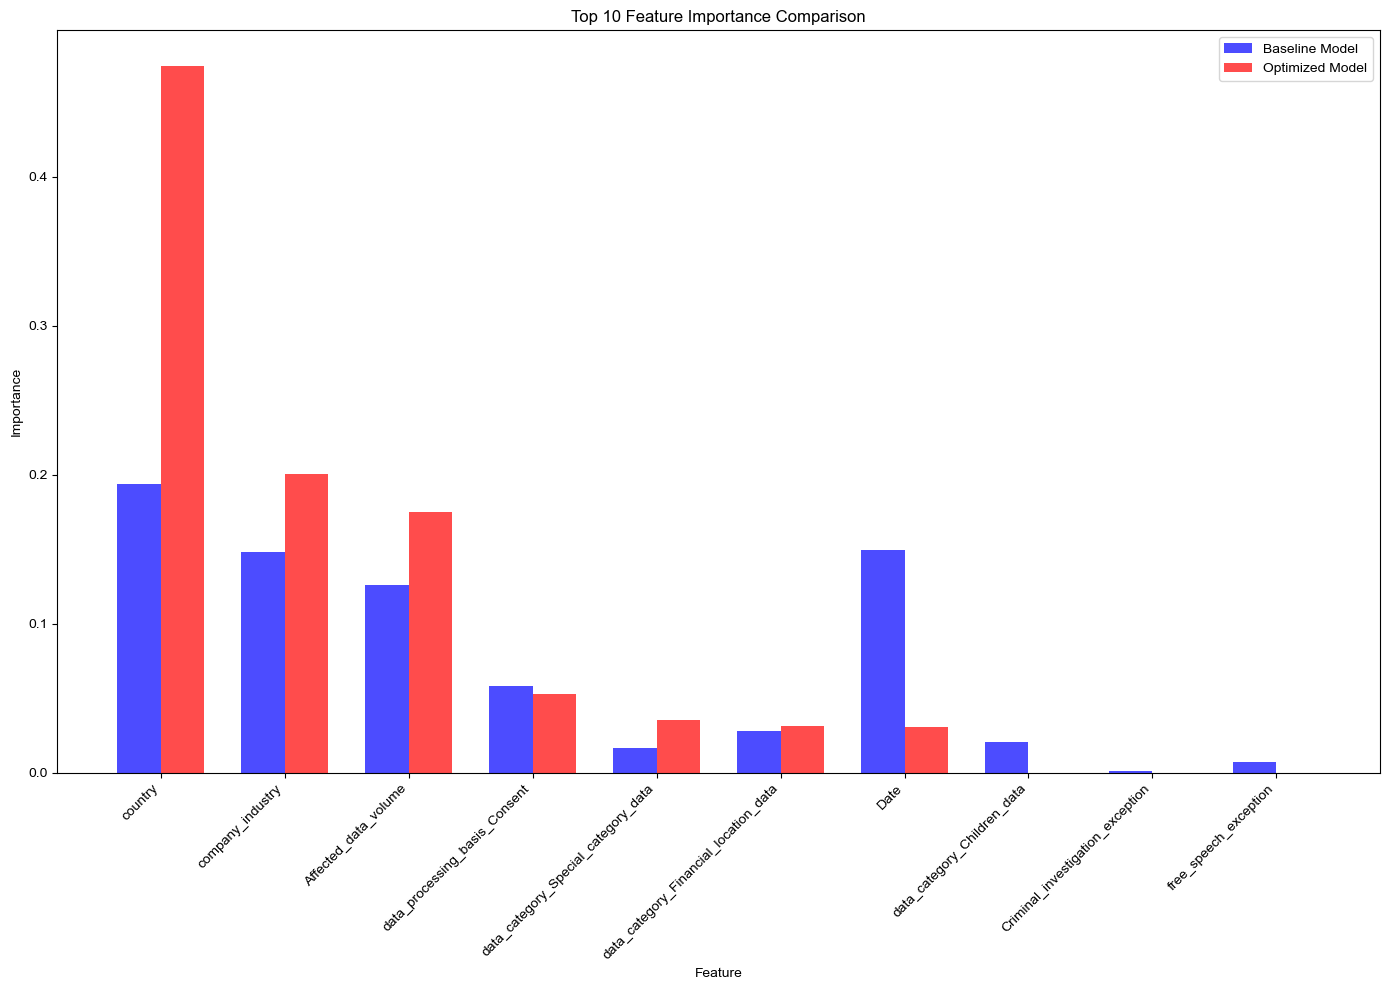

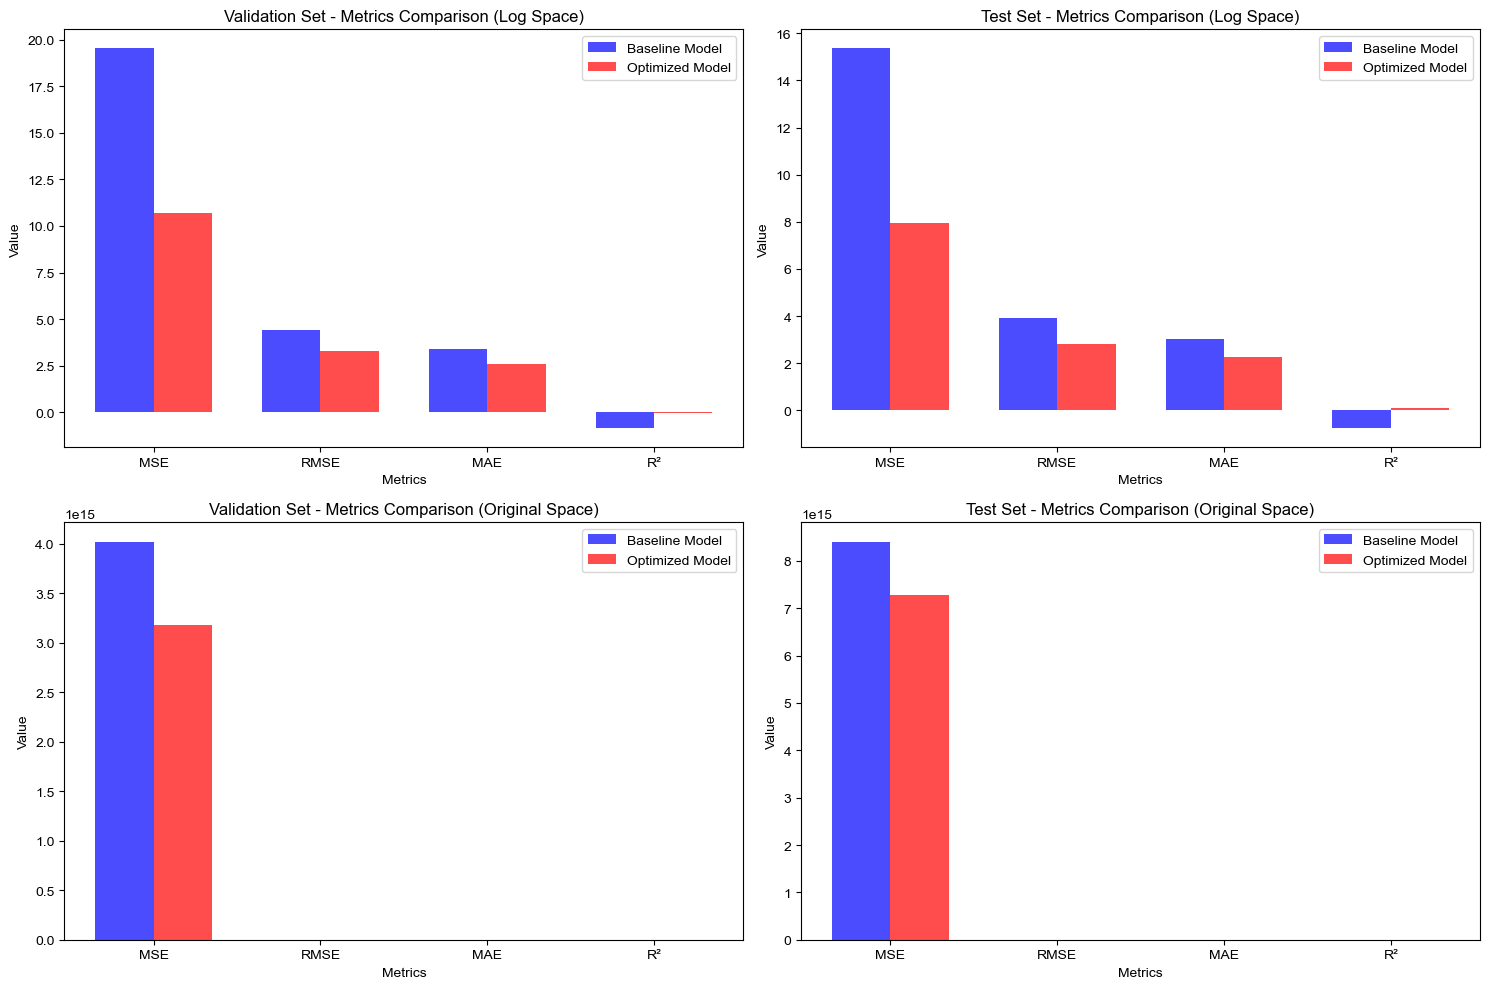

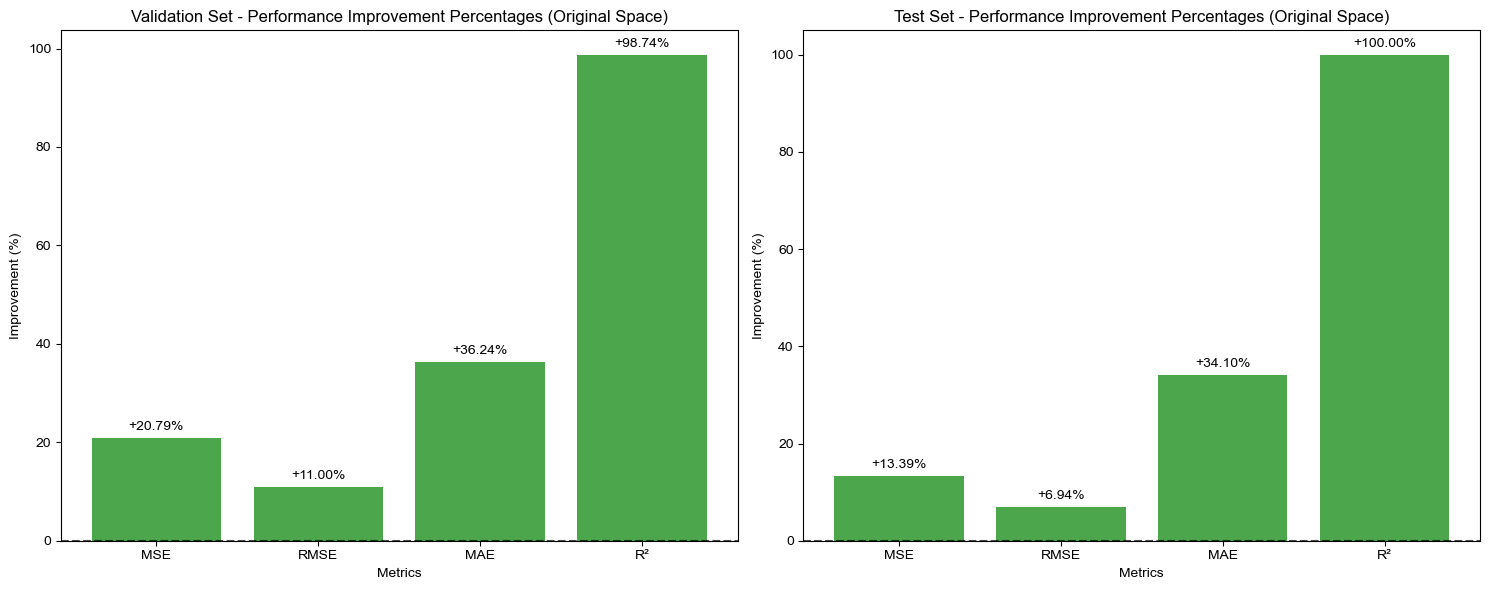

In [294]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import time
import warnings

# Suppress specific warnings related to version inconsistency
warnings.filterwarnings("ignore", category=UserWarning, message=".*InconsistentVersionWarning.*")
warnings.filterwarnings("ignore", message="MallocStackLogging")


# Define a function to calculate and return various evaluation metrics
def calculate_metrics(y_true, y_pred, y_true_orig=None, y_pred_orig=None):
    """
    Calculate regression model evaluation metrics
    """
    metrics = {}
    
    # Metrics in the transformed space
    metrics['mse'] = mean_squared_error(y_true, y_pred)
    metrics['rmse'] = np.sqrt(metrics['mse'])
    metrics['mae'] = mean_absolute_error(y_true, y_pred)
    metrics['r2'] = r2_score(y_true, y_pred)
    
    # If original space values are provided, calculate metrics in the original space
    if y_true_orig is not None and y_pred_orig is not None:
        metrics['mse_orig'] = mean_squared_error(y_true_orig, y_pred_orig)
        metrics['rmse_orig'] = np.sqrt(metrics['mse_orig'])
        metrics['mae_orig'] = mean_absolute_error(y_true_orig, y_pred_orig)
        metrics['r2_orig'] = r2_score(y_true_orig, y_pred_orig)
    
    return metrics

# Train baseline and optimized decision tree models, compare performance improvements
def train_and_compare_decision_trees(X_train, X_val, X_test, y_train, y_val, y_test, is_log_transformed=True, random_state=42):
    """
    Train baseline and optimized decision tree models using existing data splits, compare performance improvements
    
    Parameters:
    X_train: Training set features
    X_val: Validation set features
    X_test: Test set features
    y_train: Training set target
    y_val: Validation set target
    y_test: Test set target
    is_log_transformed: Whether the target variable has been log-transformed
    """
    print("Dataset sizes:")
    print(f"  Training set: {X_train.shape}")
    print(f"  Validation set: {X_val.shape}")
    print(f"  Test set: {X_test.shape}")
    
    # Feature standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrame to retain column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    
    # If log transformation was used, prepare original space values for metric calculation
    if is_log_transformed:
        print("Data is log-transformed, will calculate metrics in both log and original spaces")
        y_train_orig = np.expm1(y_train)
        y_val_orig = np.expm1(y_val)
        y_test_orig = np.expm1(y_test)
    else:
        print("Data is not log-transformed, will calculate metrics in original space only")
        y_train_orig = y_train
        y_val_orig = y_val
        y_test_orig = y_test
    
    # 1. Baseline model - using default parameters
    print("\n1. Training baseline decision tree model (default parameters)...")
    start_time = time.time()
    
    baseline_dt = DecisionTreeRegressor(random_state=random_state)
    baseline_dt.fit(X_train_scaled, y_train)
    
    baseline_train_time = time.time() - start_time
    print(f"   Baseline model training time: {baseline_train_time:.4f} seconds")
    
    # Evaluate baseline model on training, validation, and test sets
    y_train_pred_baseline = baseline_dt.predict(X_train_scaled)
    y_val_pred_baseline = baseline_dt.predict(X_val_scaled)
    y_test_pred_baseline = baseline_dt.predict(X_test_scaled)
    
    # If log transformation was used, convert predictions back to original space
    if is_log_transformed:
        y_train_pred_baseline_orig = np.expm1(y_train_pred_baseline)
        y_val_pred_baseline_orig = np.expm1(y_val_pred_baseline)
        y_test_pred_baseline_orig = np.expm1(y_test_pred_baseline)
    else:
        y_train_pred_baseline_orig = y_train_pred_baseline
        y_val_pred_baseline_orig = y_val_pred_baseline
        y_test_pred_baseline_orig = y_test_pred_baseline
    
    # Calculate baseline model evaluation metrics
    baseline_train_metrics = calculate_metrics(
        y_train, y_train_pred_baseline, 
        y_train_orig, y_train_pred_baseline_orig
    )
    baseline_val_metrics = calculate_metrics(
        y_val, y_val_pred_baseline,
        y_val_orig, y_val_pred_baseline_orig
    )
    baseline_test_metrics = calculate_metrics(
        y_test, y_test_pred_baseline,
        y_test_orig, y_test_pred_baseline_orig
    )
    
    # Get baseline model feature importance
    baseline_feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': baseline_dt.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Print baseline model evaluation results
    print("\nBaseline decision tree model evaluation results:")
    print(f"   Baseline model default parameters: max_depth={baseline_dt.max_depth}, "
          f"min_samples_split={baseline_dt.min_samples_split}, "
          f"min_samples_leaf={baseline_dt.min_samples_leaf}")
    
    if is_log_transformed:
        print(f"   Training set MSE (log space): {baseline_train_metrics['mse']:.6f}")
        print(f"   Validation set MSE (log space): {baseline_val_metrics['mse']:.6f}")
        print(f"   Test set MSE (log space): {baseline_test_metrics['mse']:.6f}")
    
    print(f"   Training set MSE (original space): {baseline_train_metrics['mse_orig']:.2f}")
    print(f"   Validation set MSE (original space): {baseline_val_metrics['mse_orig']:.2f}")
    print(f"   Test set MSE (original space): {baseline_test_metrics['mse_orig']:.2f}")
    print(f"   Training set R²: {baseline_train_metrics['r2']:.4f}")
    print(f"   Validation set R²: {baseline_val_metrics['r2']:.4f}")
    print(f"   Test set R²: {baseline_test_metrics['r2']:.4f}")
    
    # 2. Optimized model - using grid search to find the best parameters
    print("\n2. Training optimized decision tree model (using grid search)...")
    start_time = time.time()
    
    # Define parameter grid
    param_grid = {
        'max_depth': [5, 10, 15, 20, 25, None],
        'min_samples_split': [2, 5, 10, 15, 20],
        'min_samples_leaf': [1, 2, 4, 6, 8],
        'max_features': ['sqrt', 'log2', None]
    }
    
    # Create grid search object
    dt_reg = DecisionTreeRegressor(random_state=random_state)
    grid_search = GridSearchCV(
        dt_reg, 
        param_grid, 
        cv=5,  # Perform cross-validation within the training set
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Perform grid search (only on the training set)
    grid_search.fit(X_train_scaled, y_train)
    
    # Get the optimized model
    tuned_dt = grid_search.best_estimator_
    
    tuned_train_time = time.time() - start_time
    print(f"   Optimized model search+training time: {tuned_train_time:.4f} seconds")
    print(f"   Best parameters: {grid_search.best_params_}")
    print(f"   Best cross-validation score (neg MSE): {grid_search.best_score_:.6f}")
    
    # Evaluate optimized model on training, validation, and test sets
    y_train_pred_tuned = tuned_dt.predict(X_train_scaled)
    y_val_pred_tuned = tuned_dt.predict(X_val_scaled)
    y_test_pred_tuned = tuned_dt.predict(X_test_scaled)
    
    # If log transformation was used, convert predictions back to original space
    if is_log_transformed:
        y_train_pred_tuned_orig = np.expm1(y_train_pred_tuned)
        y_val_pred_tuned_orig = np.expm1(y_val_pred_tuned)
        y_test_pred_tuned_orig = np.expm1(y_test_pred_tuned)
    else:
        y_train_pred_tuned_orig = y_train_pred_tuned
        y_val_pred_tuned_orig = y_val_pred_tuned
        y_test_pred_tuned_orig = y_test_pred_tuned
    
    # Calculate optimized model evaluation metrics
    tuned_train_metrics = calculate_metrics(
        y_train, y_train_pred_tuned, 
        y_train_orig, y_train_pred_tuned_orig
    )
    tuned_val_metrics = calculate_metrics(
        y_val, y_val_pred_tuned,
        y_val_orig, y_val_pred_tuned_orig
    )
    tuned_test_metrics = calculate_metrics(
        y_test, y_test_pred_tuned,
        y_test_orig, y_test_pred_tuned_orig
    )
    
    # Get optimized model feature importance
    tuned_feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': tuned_dt.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Print optimized model evaluation results
    print("\nOptimized decision tree model evaluation results:")
    
    if is_log_transformed:
        print(f"   Training set MSE (log space): {tuned_train_metrics['mse']:.6f}")
        print(f"   Validation set MSE (log space): {tuned_val_metrics['mse']:.6f}")
        print(f"   Test set MSE (log space): {tuned_test_metrics['mse']:.6f}")
    
    print(f"   Training set MSE (original space): {tuned_train_metrics['mse_orig']:.2f}")
    print(f"   Validation set MSE (original space): {tuned_val_metrics['mse_orig']:.2f}")
    print(f"   Test set MSE (original space): {tuned_test_metrics['mse_orig']:.2f}")
    print(f"   Training set R²: {tuned_train_metrics['r2']:.4f}")
    print(f"   Validation set R²: {tuned_val_metrics['r2']:.4f}")
    print(f"   Test set R²: {tuned_test_metrics['r2']:.4f}")
    
    # 3. Calculate performance improvements
    print("\n3. Performance improvement analysis:")
    
    # Calculate improvement percentages on validation and test sets
    if is_log_transformed:
        val_mse_improvement = (baseline_val_metrics['mse'] - tuned_val_metrics['mse']) / baseline_val_metrics['mse'] * 100
        test_mse_improvement = (baseline_test_metrics['mse'] - tuned_test_metrics['mse']) / baseline_test_metrics['mse'] * 100
    else:
        val_mse_improvement = 0
        test_mse_improvement = 0
    
    val_mse_orig_improvement = (baseline_val_metrics['mse_orig'] - tuned_val_metrics['mse_orig']) / baseline_val_metrics['mse_orig'] * 100
    test_mse_orig_improvement = (baseline_test_metrics['mse_orig'] - tuned_test_metrics['mse_orig']) / baseline_test_metrics['mse_orig'] * 100
    
    val_r2_improvement = (tuned_val_metrics['r2'] - baseline_val_metrics['r2']) / abs(baseline_val_metrics['r2']) * 100 if baseline_val_metrics['r2'] != 0 else float('inf')
    test_r2_improvement = (tuned_test_metrics['r2'] - baseline_test_metrics['r2']) / abs(baseline_test_metrics['r2']) * 100 if baseline_test_metrics['r2'] != 0 else float('inf')
    
    # Print performance improvements on validation set
    print("   Performance improvements on validation set:")
    if is_log_transformed:
        print(f"     MSE improvement (log space): {val_mse_improvement:.2f}%")
    print(f"     MSE improvement (original space): {val_mse_orig_improvement:.2f}%")
    print(f"     R² improvement: {val_r2_improvement:.2f}%")
    
    # Print performance improvements on test set
    print("\n   Performance improvements on test set:")
    if is_log_transformed:
        print(f"     MSE improvement (log space): {test_mse_improvement:.2f}%")
    print(f"     MSE improvement (original space): {test_mse_orig_improvement:.2f}%")
    print(f"     R² improvement: {test_r2_improvement:.2f}%")
    
    print(f"\n   Training time increase: {(tuned_train_time / baseline_train_time - 1) * 100:.2f}%")
    
    # 4. Print feature importance
    print("\n4. Feature importance analysis:")
    
    # Print top 10 important features of baseline model
    print("   Top 10 important features for baseline model:")
    for i, (feature, importance) in enumerate(zip(baseline_feature_importance['Feature'][:10], 
                                                baseline_feature_importance['Importance'][:10])):
        print(f"     {i+1}. {feature}: {importance:.4f}")
    
    # Print top 10 important features of optimized model
    print("\n   Top 10 important features for optimized model:")
    for i, (feature, importance) in enumerate(zip(tuned_feature_importance['Feature'][:10], 
                                               tuned_feature_importance['Importance'][:10])):
        print(f"     {i+1}. {feature}: {importance:.4f}")
    
    # Return results
    return {
        'baseline_model': baseline_dt,
        'tuned_model': tuned_dt,
        'best_params': grid_search.best_params_,
        'scaler': scaler,
        'is_log_transformed': is_log_transformed,
        'baseline_metrics': {
            'train': baseline_train_metrics,
            'val': baseline_val_metrics,
            'test': baseline_test_metrics
        },
        'tuned_metrics': {
            'train': tuned_train_metrics,
            'val': tuned_val_metrics,
            'test': tuned_test_metrics
        },
        'improvements': {
            'val_mse': val_mse_improvement if is_log_transformed else 0,
            'test_mse': test_mse_improvement if is_log_transformed else 0,
            'val_mse_orig': val_mse_orig_improvement,
            'test_mse_orig': test_mse_orig_improvement,
            'val_r2': val_r2_improvement,
            'test_r2': test_r2_improvement,
            'train_time': (tuned_train_time / baseline_train_time - 1) * 100
        },
        'baseline_feature_importance': baseline_feature_importance,
        'tuned_feature_importance': tuned_feature_importance,
        'data': {
            'X_train': X_train,
            'X_val': X_val,
            'X_test': X_test,
            'y_train': y_train,
            'y_val': y_val,
            'y_test': y_test,
            'X_train_scaled': X_train_scaled,
            'X_val_scaled': X_val_scaled,
            'X_test_scaled': X_test_scaled,
            'y_train_orig': y_train_orig,
            'y_val_orig': y_val_orig,
            'y_test_orig': y_test_orig
        },
        'predictions': {
            'baseline': {
                'y_train_pred': y_train_pred_baseline,
                'y_val_pred': y_val_pred_baseline,
                'y_test_pred': y_test_pred_baseline,
                'y_train_pred_orig': y_train_pred_baseline_orig,
                'y_val_pred_orig': y_val_pred_baseline_orig,
                'y_test_pred_orig': y_test_pred_baseline_orig
            },
            'tuned': {
                'y_train_pred': y_train_pred_tuned,
                'y_val_pred': y_val_pred_tuned,
                'y_test_pred': y_test_pred_tuned,
                'y_train_pred_orig': y_train_pred_tuned_orig,
                'y_val_pred_orig': y_val_pred_tuned_orig,
                'y_test_pred_orig': y_test_pred_tuned_orig
            }
        }
    }

# Plot comparison results between baseline and optimized models
def plot_model_comparison(results):
    """
    Plot comparison results between baseline and optimized models
    """
    is_log_transformed = results['is_log_transformed']
    
    # Prepare data
    y_val = results['data']['y_val']
    y_test = results['data']['y_test']
    y_val_orig = results['data']['y_val_orig']
    y_test_orig = results['data']['y_test_orig']
    
    y_val_pred_baseline = results['predictions']['baseline']['y_val_pred']
    y_test_pred_baseline = results['predictions']['baseline']['y_test_pred']
    y_val_pred_tuned = results['predictions']['tuned']['y_val_pred']
    y_test_pred_tuned = results['predictions']['tuned']['y_test_pred']
    
    y_val_pred_baseline_orig = results['predictions']['baseline']['y_val_pred_orig']
    y_test_pred_baseline_orig = results['predictions']['baseline']['y_test_pred_orig']
    y_val_pred_tuned_orig = results['predictions']['tuned']['y_val_pred_orig']
    y_test_pred_tuned_orig = results['predictions']['tuned']['y_test_pred_orig']
    
    # 1. Prediction comparison scatter plots (validation set)
    plt.figure(figsize=(15, 12))
    
    # Baseline vs. optimized models in transformed space (validation set)
    plt.subplot(2, 2, 1)
    plt.scatter(y_val, y_val_pred_baseline, alpha=0.5, label='Baseline Model', color='blue')
    plt.scatter(y_val, y_val_pred_tuned, alpha=0.5, label='Optimized Model', color='red')
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    if is_log_transformed:
        plt.title('Validation Set - Predictions Comparison (Log Space)')
    else:
        plt.title('Validation Set - Predictions Comparison')
    plt.legend()
    
    # Baseline vs. optimized models in original space (validation set)
    plt.subplot(2, 2, 2)
    plt.scatter(y_val_orig, y_val_pred_baseline_orig, alpha=0.5, label='Baseline Model', color='blue')
    plt.scatter(y_val_orig, y_val_pred_tuned_orig, alpha=0.5, label='Optimized Model', color='red')
    plt.plot([y_val_orig.min(), y_val_orig.max()], [y_val_orig.min(), y_val_orig.max()], 'k--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Validation Set - Predictions Comparison (Original Space)')
    plt.legend()
    
    # Baseline vs. optimized models in transformed space (test set)
    plt.subplot(2, 2, 3)
    plt.scatter(y_test, y_test_pred_baseline, alpha=0.5, label='Baseline Model', color='blue')
    plt.scatter(y_test, y_test_pred_tuned, alpha=0.5, label='Optimized Model', color='red')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    if is_log_transformed:
        plt.title('Test Set - Predictions Comparison (Log Space)')
    else:
        plt.title('Test Set - Predictions Comparison')
    plt.legend()
    
    # Baseline vs. optimized models in original space (test set)
    plt.subplot(2, 2, 4)
    plt.scatter(y_test_orig, y_test_pred_baseline_orig, alpha=0.5, label='Baseline Model', color='blue')
    plt.scatter(y_test_orig, y_test_pred_tuned_orig, alpha=0.5, label='Optimized Model', color='red')
    plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'k--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Test Set - Predictions Comparison (Original Space)')
    plt.legend()
    
    plt.tight_layout()
    plt.suptitle('Baseline Model vs. Optimized Model Prediction Comparison', fontsize=16)
    plt.subplots_adjust(top=0.93)
    
    # 2. Residual distribution histogram comparison (test set)
    plt.figure(figsize=(15, 6))
    
    residuals_baseline_test = y_test - y_test_pred_baseline
    residuals_tuned_test = y_test - y_test_pred_tuned
    residuals_baseline_test_orig = y_test_orig - y_test_pred_baseline_orig
    residuals_tuned_test_orig = y_test_orig - y_test_pred_tuned_orig
    
    plt.subplot(1, 2, 1)
    sns.histplot(residuals_baseline_test, kde=True, color='blue', alpha=0.5, label='Baseline Model')
    sns.histplot(residuals_tuned_test, kde=True, color='red', alpha=0.5, label='Optimized Model')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    if is_log_transformed:
        plt.title('Test Set - Residual Distribution Comparison (Log Space)')
    else:
        plt.title('Test Set - Residual Distribution Comparison')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.histplot(residuals_baseline_test_orig, kde=True, color='blue', alpha=0.5, label='Baseline Model')
    sns.histplot(residuals_tuned_test_orig, kde=True, color='red', alpha=0.5, label='Optimized Model')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Test Set - Residual Distribution Comparison (Original Space)')
    plt.legend()
    
    plt.tight_layout()
    
    # 3. Feature importance comparison
    baseline_feature_importance = results['baseline_feature_importance']
    tuned_feature_importance = results['tuned_feature_importance']
    
    # Merge two feature importance DataFrames for comparison
    feature_importance_comparison = pd.merge(
        baseline_feature_importance, 
        tuned_feature_importance,
        on='Feature',
        suffixes=('_baseline', '_tuned')
    )
    feature_importance_comparison = feature_importance_comparison.sort_values('Importance_tuned', ascending=False)
    
    plt.figure(figsize=(14, 10))
    
    # Plot top 10 features importance comparison
    top_features = feature_importance_comparison.head(10)
    x = np.arange(len(top_features))
    width = 0.35
    
    plt.bar(x - width/2, top_features['Importance_baseline'], width, label='Baseline Model', color='blue', alpha=0.7)
    plt.bar(x + width/2, top_features['Importance_tuned'], width, label='Optimized Model', color='red', alpha=0.7)
    
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Top 10 Feature Importance Comparison')
    plt.xticks(x, top_features['Feature'], rotation=45, ha='right')
    plt.legend()
    
    plt.tight_layout()
    
    # 4. Performance metrics comparison bar charts
    plt.figure(figsize=(15, 10))
    
    # Prepare validation and test set performance metrics data
    metrics = ['MSE', 'RMSE', 'MAE', 'R²']
    
    if is_log_transformed:
        val_baseline_values = [
            results['baseline_metrics']['val']['mse'],
            results['baseline_metrics']['val']['rmse'],
            results['baseline_metrics']['val']['mae'],
            results['baseline_metrics']['val']['r2']
        ]
        val_tuned_values = [
            results['tuned_metrics']['val']['mse'],
            results['tuned_metrics']['val']['rmse'],
            results['tuned_metrics']['val']['mae'],
            results['tuned_metrics']['val']['r2']
        ]
        
        test_baseline_values = [
            results['baseline_metrics']['test']['mse'],
            results['baseline_metrics']['test']['rmse'],
            results['baseline_metrics']['test']['mae'],
            results['baseline_metrics']['test']['r2']
        ]
        test_tuned_values = [
            results['tuned_metrics']['test']['mse'],
            results['tuned_metrics']['test']['rmse'],
            results['tuned_metrics']['test']['mae'],
            results['tuned_metrics']['test']['r2']
        ]
        
    val_baseline_values_orig = [
        results['baseline_metrics']['val']['mse_orig'],
        results['baseline_metrics']['val']['rmse_orig'],
        results['baseline_metrics']['val']['mae_orig'],
        results['baseline_metrics']['val']['r2']
    ]
    val_tuned_values_orig = [
        results['tuned_metrics']['val']['mse_orig'],
        results['tuned_metrics']['val']['rmse_orig'],
        results['tuned_metrics']['val']['mae_orig'],
        results['tuned_metrics']['val']['r2']
    ]
    
    test_baseline_values_orig = [
        results['baseline_metrics']['test']['mse_orig'],
        results['baseline_metrics']['test']['rmse_orig'],
        results['baseline_metrics']['test']['mae_orig'],
        results['baseline_metrics']['test']['r2']
    ]
    test_tuned_values_orig = [
        results['tuned_metrics']['test']['mse_orig'],
        results['tuned_metrics']['test']['rmse_orig'],
        results['tuned_metrics']['test']['mae_orig'],
        results['tuned_metrics']['test']['r2']
    ]
    
    # If log transformation was used, plot log space metrics comparison
    if is_log_transformed:
        plt.subplot(2, 2, 1)
        x = np.arange(len(metrics))
        width = 0.35
        
        plt.bar(x - width/2, val_baseline_values, width, label='Baseline Model', color='blue', alpha=0.7)
        plt.bar(x + width/2, val_tuned_values, width, label='Optimized Model', color='red', alpha=0.7)
        
        plt.xlabel('Metrics')
        plt.ylabel('Value')
        plt.title('Validation Set - Metrics Comparison (Log Space)')
        plt.xticks(x, metrics)
        plt.legend()
        
        plt.subplot(2, 2, 2)
        plt.bar(x - width/2, test_baseline_values, width, label='Baseline Model', color='blue', alpha=0.7)
        plt.bar(x + width/2, test_tuned_values, width, label='Optimized Model', color='red', alpha=0.7)
        
        plt.xlabel('Metrics')
        plt.ylabel('Value')
        plt.title('Test Set - Metrics Comparison (Log Space)')
        plt.xticks(x, metrics)
        plt.legend()
        
        # Plot original space metrics comparison
        plt.subplot(2, 2, 3)
    else:
        plt.subplot(1, 2, 1)
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, val_baseline_values_orig, width, label='Baseline Model', color='blue', alpha=0.7)
    plt.bar(x + width/2, val_tuned_values_orig, width, label='Optimized Model', color='red', alpha=0.7)
    
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title('Validation Set - Metrics Comparison (Original Space)')
    plt.xticks(x, metrics)
    plt.legend()
    
    if is_log_transformed:
        plt.subplot(2, 2, 4)
    else:
        plt.subplot(1, 2, 2)
    
    plt.bar(x - width/2, test_baseline_values_orig, width, label='Baseline Model', color='blue', alpha=0.7)
    plt.bar(x + width/2, test_tuned_values_orig, width, label='Optimized Model', color='red', alpha=0.7)
    
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title('Test Set - Metrics Comparison (Original Space)')
    plt.xticks(x, metrics)
    plt.legend()
    
    plt.tight_layout()
    
    # 5. Performance improvement percentage bar charts
    plt.figure(figsize=(15, 6))
    
    # Prepare improvement percentage data
    metrics = ['MSE', 'RMSE', 'MAE', 'R²']
    
    # Validation set improvements
    if is_log_transformed:
        val_improvements = [
            results['improvements']['val_mse'],
            (results['baseline_metrics']['val']['rmse'] - results['tuned_metrics']['val']['rmse']) / results['baseline_metrics']['val']['rmse'] * 100,
            (results['baseline_metrics']['val']['mae'] - results['tuned_metrics']['val']['mae']) / results['baseline_metrics']['val']['mae'] * 100,
            results['improvements']['val_r2']
        ]
    
    val_improvements_orig = [
        results['improvements']['val_mse_orig'],
        (results['baseline_metrics']['val']['rmse_orig'] - results['tuned_metrics']['val']['rmse_orig']) / results['baseline_metrics']['val']['rmse_orig'] * 100,
        (results['baseline_metrics']['val']['mae_orig'] - results['tuned_metrics']['val']['mae_orig']) / results['baseline_metrics']['val']['mae_orig'] * 100,
        results['improvements']['val_r2']
    ]
    
    # Test set improvements
    if is_log_transformed:
        test_improvements = [
            results['improvements']['test_mse'],
            (results['baseline_metrics']['test']['rmse'] - results['tuned_metrics']['test']['rmse']) / results['baseline_metrics']['test']['rmse'] * 100,
            (results['baseline_metrics']['test']['mae'] - results['tuned_metrics']['test']['mae']) / results['baseline_metrics']['test']['mae'] * 100,
            results['improvements']['test_r2']
        ]
    
    test_improvements_orig = [
        results['improvements']['test_mse_orig'],
        (results['baseline_metrics']['test']['rmse_orig'] - results['tuned_metrics']['test']['rmse_orig']) / results['baseline_metrics']['test']['rmse_orig'] * 100,
        (results['baseline_metrics']['test']['mae_orig'] - results['tuned_metrics']['test']['mae_orig']) / results['baseline_metrics']['test']['mae_orig'] * 100,
        results['improvements']['test_r2']
    ]
    
    # Original space improvement percentages
    plt.subplot(1, 2, 1)
    
    # Handle R² improvement, avoid chart imbalance
    if abs(val_improvements_orig[3]) > 100:
        val_improvements_orig[3] = 100 if val_improvements_orig[3] > 0 else -100
    
    plt.bar(metrics, val_improvements_orig, color='green', alpha=0.7)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.7)
    plt.xlabel('Metrics')
    plt.ylabel('Improvement (%)')
    plt.title('Validation Set - Performance Improvement Percentages (Original Space)')
    
    # Add value labels
    for i, v in enumerate(val_improvements_orig):
        plt.text(i, v + 1 if v >= 0 else v - 1, 
                 f'+{v:.2f}%' if v >= 0 else f'{v:.2f}%', 
                 ha='center', va='bottom' if v >= 0 else 'top', fontsize=10)
    
    plt.subplot(1, 2, 2)
    
    # Handle R² improvement, avoid chart imbalance
    if abs(test_improvements_orig[3]) > 100:
        test_improvements_orig[3] = 100 if test_improvements_orig[3] > 0 else -100
    
    plt.bar(metrics, test_improvements_orig, color='green', alpha=0.7)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.7)
    plt.xlabel('Metrics')
    plt.ylabel('Improvement (%)')
    plt.title('Test Set - Performance Improvement Percentages (Original Space)')
    
    # Add value labels
    for i, v in enumerate(test_improvements_orig):
        plt.text(i, v + 1 if v >= 0 else v - 1, 
                 f'+{v:.2f}%' if v >= 0 else f'{v:.2f}%', 
                 ha='center', va='bottom' if v >= 0 else 'top', fontsize=10)
    
    plt.tight_layout()

# Main function: Use existing data sets to perform training and comparison
def main(X_train, X_val, X_test, y_train, y_val, y_test, is_log_transformed=True):
    """
    Use existing data sets to perform model training and comparison
    """
    # Train models and compare performance
    print("Training models and comparing performance...")
    results = train_and_compare_decision_trees(
        X_train, X_val, X_test, y_train, y_val, y_test, 
        is_log_transformed=is_log_transformed
    )
    
    # Plot comparison results
    print("\nPlotting comparison results...")
    plot_model_comparison(results)
    
    # Save results
    print("\nSaving results...")
    joblib.dump({
        'baseline_model': results['baseline_model'],
        'tuned_model': results['tuned_model'],
        'best_params': results['best_params'],
        'scaler': results['scaler'],
        'is_log_transformed': results['is_log_transformed'],
        'metrics': {
            'baseline': {
                'train': results['baseline_metrics']['train'],
                'val': results['baseline_metrics']['val'],
                'test': results['baseline_metrics']['test']
            },
            'tuned': {
                'train': results['tuned_metrics']['train'],
                'val': results['tuned_metrics']['val'],
                'test': results['tuned_metrics']['test']
            }
        },
        'improvements': results['improvements']
    }, 'decision_tree_comparison.pkl')
    print("Results saved as 'decision_tree_comparison.pkl'")
    
    # Return results
    return results


# Assuming you already have the following datasets:
X_reg_train, X_reg_val, X_reg_test, y_reg_train, y_reg_val, y_reg_test

# Call the main function
results = main(
    X_reg_train, X_reg_val, X_reg_test, 
    y_reg_train, y_reg_val, y_reg_test,
    is_log_transformed=True  # Assuming your target variable has been log-transformed
)

## Fine Brasket

Training set fine bracket distribution:
  0: Low fine - 364 samples (40.62%)
  1: Medium fine - 149 samples (16.63%)
  2: High fine - 383 samples (42.75%)

Training fine bracket classification model...

Training baseline Decision Tree model...

Baseline model - Validation set accuracy: 0.4278
Baseline model - Validation set weighted F1 score: 0.4328

Baseline model - Validation set classification report:
              precision    recall  f1-score   support

    Low fine       0.49      0.52      0.51        73
 Medium fine       0.16      0.20      0.18        30
   High fine       0.50      0.43      0.46        77

    accuracy                           0.43       180
   macro avg       0.39      0.38      0.38       180
weighted avg       0.44      0.43      0.43       180

Using Decision Tree classifier with GridSearchCV...
Performing grid search to find the best parameters...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': None, 'min_s

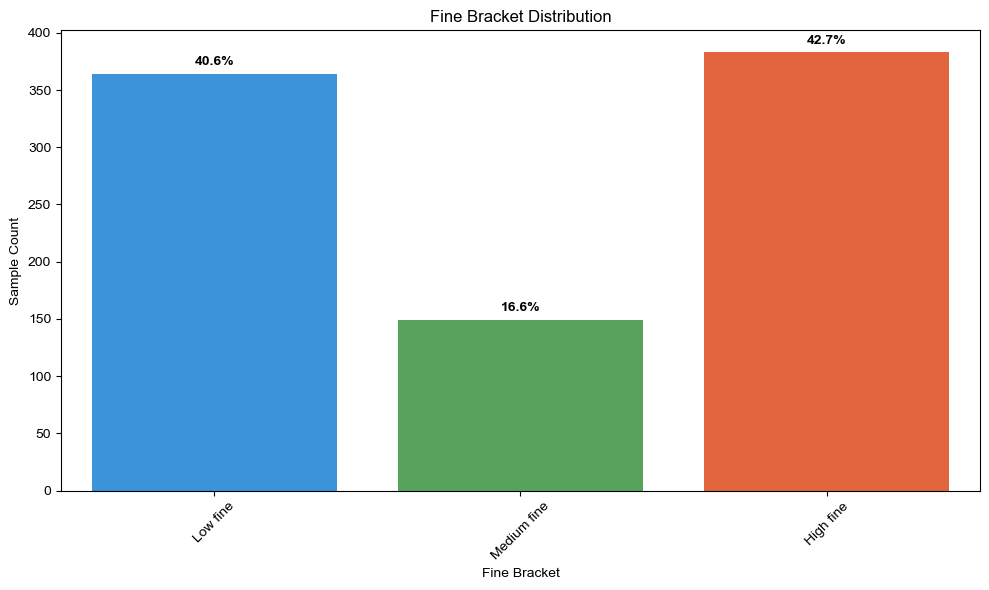

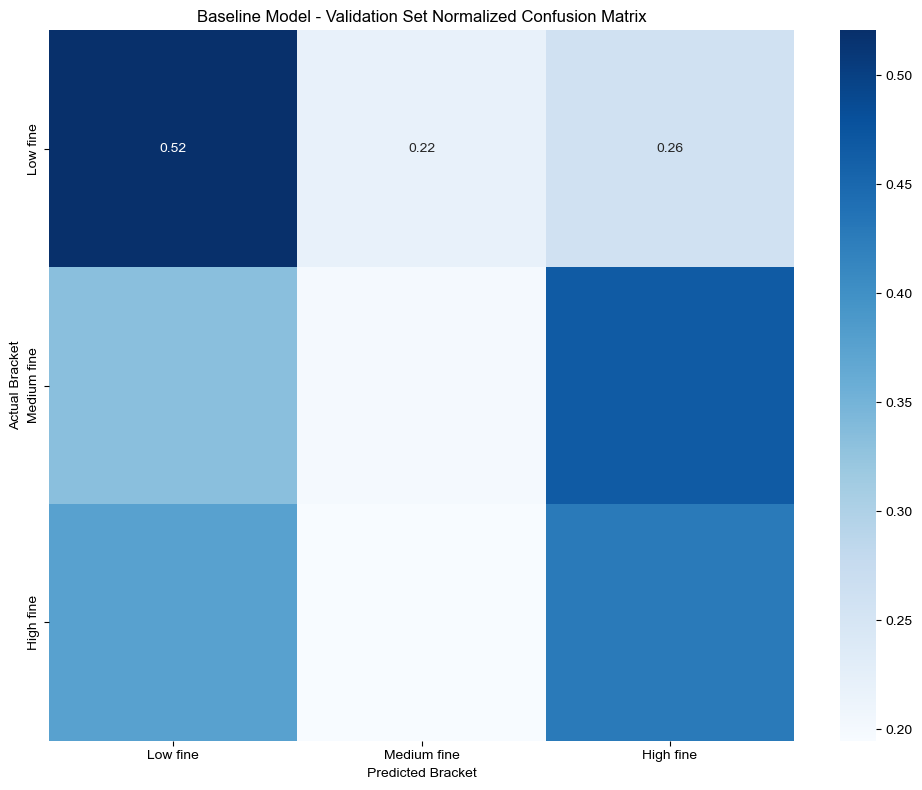

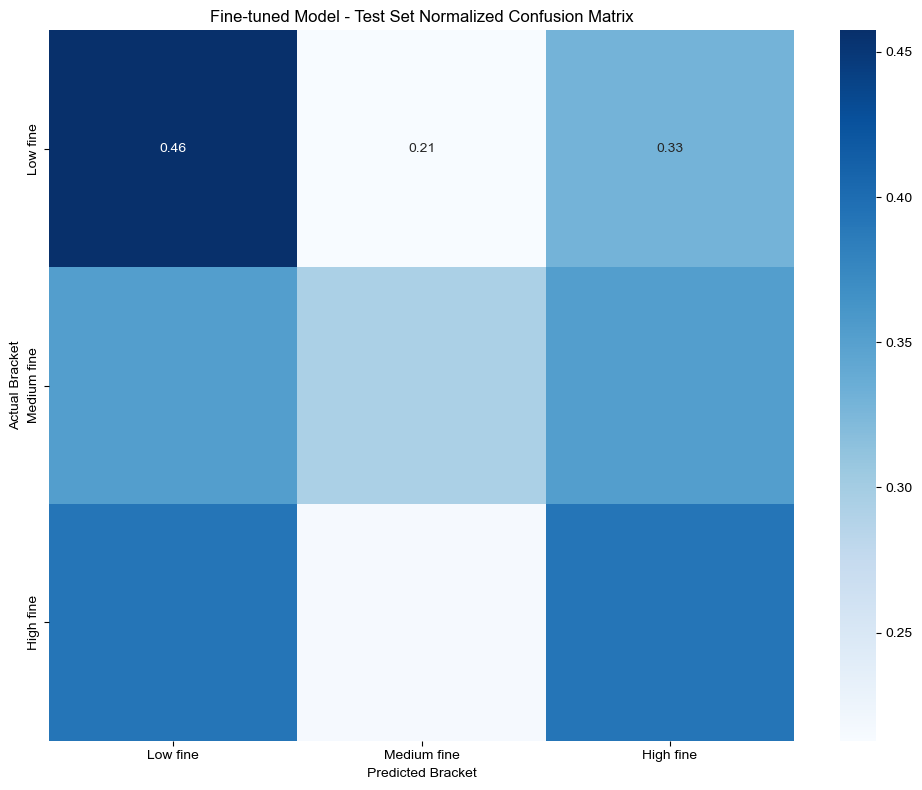

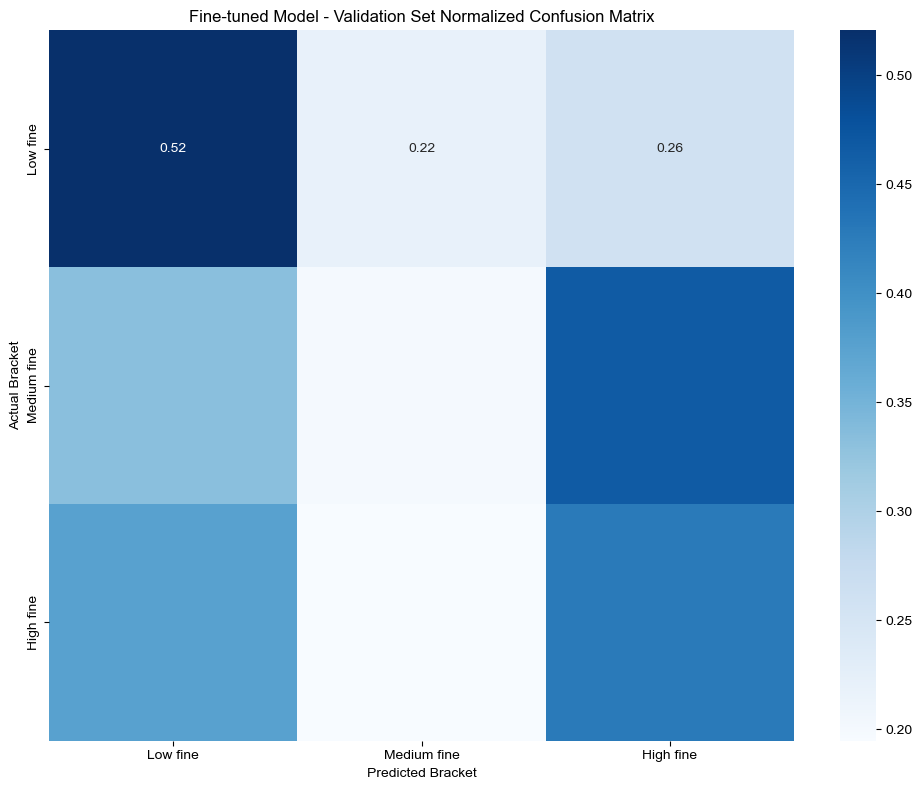

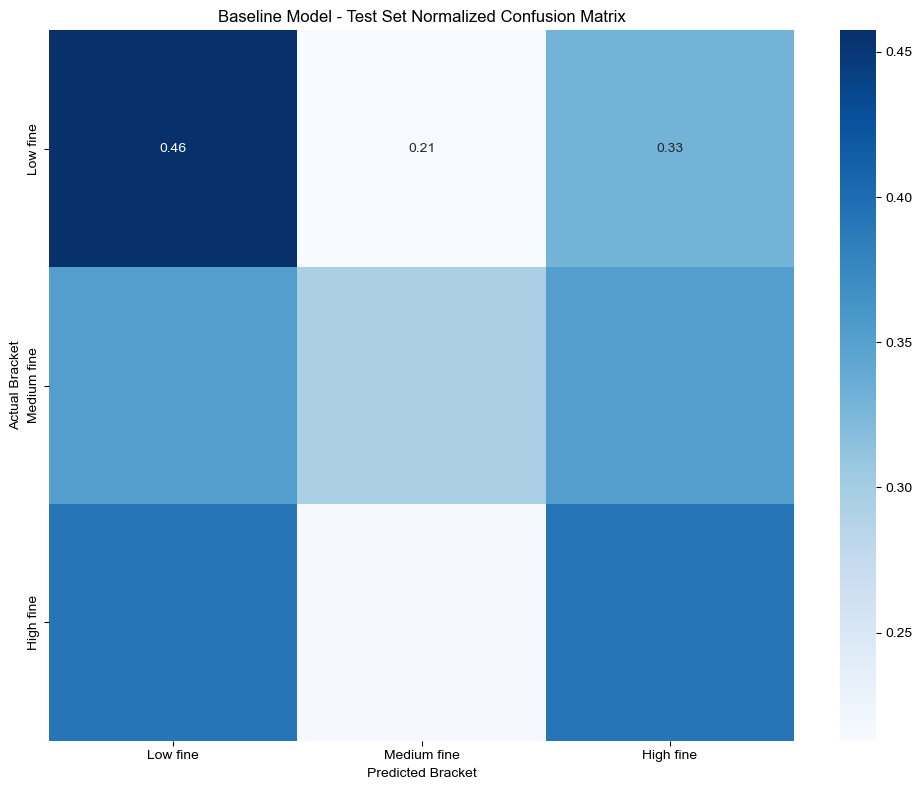

In [265]:
# Import necessary modules
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress specific warnings related to version inconsistency
warnings.filterwarnings("ignore", category=UserWarning, message=".*InconsistentVersionWarning.*")

# Function to convert fine amounts into brackets (3 levels)
def convert_to_bracket(fine_amount):
    """
    Converts fine amount into brackets
    Bracket definitions:
    0: Low fine (1 - 10,000)
    1: Medium fine (10001-50000)
    2: High fine (50001+)
    """
    if fine_amount <= 10000:
        return 0  # Low fine
    elif fine_amount <= 50000:
        return 1  # Medium fine
    else:
        return 2  # High fine

# Convert log-transformed fine amounts back to the original scale
y_train_val_orig = np.expm1(y_reg_train_val)
y_test_orig = np.expm1(y_reg_test)

# Convert fine amounts to brackets
y_bracket_train_val = y_train_val_orig.apply(convert_to_bracket)
y_bracket_test = y_test_orig.apply(convert_to_bracket)

# Print the distribution of fine brackets
bracket_counts_train = y_bracket_train_val.value_counts().sort_index()
bracket_percentage_train = bracket_counts_train / len(y_bracket_train_val) * 100

print("Training set fine bracket distribution:")
for bracket, count in bracket_counts_train.items():
    bracket_name = ["Low fine", "Medium fine", "High fine"][bracket]
    percentage = bracket_percentage_train[bracket]
    print(f"  {bracket}: {bracket_name} - {count} samples ({percentage:.2f}%)")

# Visualize the bracket distribution
plt.figure(figsize=(10, 6))
bracket_names = ["Low fine", "Medium fine", "High fine"]  # 3 brackets
colors = ['#2196F3', '#4CAF50', '#FF5722']  # 3 colors

ax = sns.barplot(x=bracket_counts_train.index, y=bracket_counts_train.values, palette=colors)
plt.xlabel("Fine Bracket")
plt.ylabel("Sample Count")
plt.title("Fine Bracket Distribution")
plt.xticks(range(len(bracket_names)), bracket_names, rotation=45)

# Add percentage labels on top of the bars
for i, v in enumerate(bracket_counts_train.values):
    ax.text(i, v + 5, f"{bracket_percentage_train.iloc[i]:.1f}%", 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()

# Train the fine bracket classification model using Decision Tree
print("\nTraining fine bracket classification model...")

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_reg_train_val, y_bracket_train_val, 
    test_size=0.2, random_state=42, stratify=y_bracket_train_val
)

# Baseline model: Decision Tree classifier with default parameters
print("\nTraining baseline Decision Tree model...")

# Train the baseline model using default settings
baseline_dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Train the baseline model on the training data
baseline_dt.fit(X_train, y_train)

# Evaluate the baseline model on the validation set
y_val_pred_baseline = baseline_dt.predict(X_val)
val_accuracy_baseline = accuracy_score(y_val, y_val_pred_baseline)
val_f1_baseline = f1_score(y_val, y_val_pred_baseline, average='weighted')

print(f"\nBaseline model - Validation set accuracy: {val_accuracy_baseline:.4f}")
print(f"Baseline model - Validation set weighted F1 score: {val_f1_baseline:.4f}")

# Print classification report for the baseline model
print("\nBaseline model - Validation set classification report:")
print(classification_report(y_val, y_val_pred_baseline, 
                          target_names=target_names_present,
                          labels=unique_classes))

# Plot confusion matrix for the baseline model on the validation set
plt.figure(figsize=(10, 8))
cm_baseline = confusion_matrix(y_val, y_val_pred_baseline)
cm_baseline_normalized = cm_baseline.astype('float') / cm_baseline.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_baseline_normalized, annot=True, cmap="Blues", fmt='.2f',
            xticklabels=bracket_names, yticklabels=bracket_names)
plt.ylabel('Actual Bracket')
plt.xlabel('Predicted Bracket')
plt.title('Baseline Model - Validation Set Normalized Confusion Matrix')
plt.tight_layout()

# Perform hyperparameter tuning with GridSearchCV
print("Using Decision Tree classifier with GridSearchCV...")
dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Define parameter grid for GridSearchCV
param_grid = {
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}


# Perform GridSearchCV to find the best parameters
print("Performing grid search to find the best parameters...")
grid_search = GridSearchCV(
    estimator=dt_classifier,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',  # Use weighted F1 score due to class imbalance
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

# Use the best model found from GridSearchCV
best_dt = grid_search.best_estimator_

# Evaluate the fine-tuned model on the validation set
y_val_pred = best_dt.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"\nFine-tuned model - Validation set accuracy: {val_accuracy:.4f}")
print(f"Fine-tuned model - Validation set weighted F1 score: {val_f1:.4f}")

# Print classification report for the fine-tuned model
print("\nFine-tuned model - Validation set classification report:")
print(classification_report(y_val, y_val_pred, 
                          target_names=target_names_present,
                          labels=unique_classes))

# Evaluate the fine-tuned model on the test set
y_test_pred_finetuned = best_dt.predict(X_reg_test)
test_accuracy_finetuned = accuracy_score(y_bracket_test, y_test_pred_finetuned)
test_f1_finetuned = f1_score(y_bracket_test, y_test_pred_finetuned, average='weighted')

print(f"\nFine-tuned model - Test set accuracy: {test_accuracy_finetuned:.4f}")
print(f"Fine-tuned model - Test set weighted F1 score: {test_f1_finetuned:.4f}")

# Print classification report for the fine-tuned model on the test set
print("\nFine-tuned model - Test set classification report:")
print(classification_report(y_bracket_test, y_test_pred_finetuned, 
                          target_names=target_names_present,
                          labels=unique_classes_test))

# Plot confusion matrix for the fine-tuned model on the test set
plt.figure(figsize=(10, 8))
cm_test_finetuned = confusion_matrix(y_bracket_test, y_test_pred_finetuned, labels=unique_classes_test)
cm_test_finetuned_normalized = cm_test_finetuned.astype('float') / cm_test_finetuned.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_test_finetuned_normalized, annot=True, cmap="Blues", fmt='.2f',
            xticklabels=target_names_present, yticklabels=target_names_present)
plt.ylabel('Actual Bracket')
plt.xlabel('Predicted Bracket')
plt.title('Fine-tuned Model - Test Set Normalized Confusion Matrix')
plt.tight_layout()
# Plot confusion matrix for the fine-tuned model on the validation set
plt.figure(figsize=(10, 8))
cm_finetuned = confusion_matrix(y_val, y_val_pred)
cm_finetuned_normalized = cm_finetuned.astype('float') / cm_finetuned.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_finetuned_normalized, annot=True, cmap="Blues", fmt='.2f',
            xticklabels=bracket_names, yticklabels=bracket_names)
plt.ylabel('Actual Bracket')
plt.xlabel('Predicted Bracket')
plt.title('Fine-tuned Model - Validation Set Normalized Confusion Matrix')
plt.tight_layout()

# Compare the baseline model's performance with the fine-tuned model
print("\nComparing performance between baseline and fine-tuned model:")

print(f"Validation Accuracy Improvement: {val_accuracy - val_accuracy_baseline:.4f}")
print(f"Validation Weighted F1 Score Improvement: {val_f1 - val_f1_baseline:.4f}")

# Evaluate the baseline model on the test set
y_test_pred_baseline = baseline_dt.predict(X_reg_test)
test_accuracy_baseline = accuracy_score(y_bracket_test, y_test_pred_baseline)
test_f1_baseline = f1_score(y_bracket_test, y_test_pred_baseline, average='weighted')

print(f"\nBaseline model - Test set accuracy: {test_accuracy_baseline:.4f}")
print(f"Baseline model - Test set weighted F1 score: {test_f1_baseline:.4f}")

print("\nBaseline model - Test set classification report:")
print(classification_report(y_bracket_test, y_test_pred_baseline, 
                          target_names=target_names_present,
                          labels=unique_classes_test))

# Plot confusion matrix for the baseline model on the test set
plt.figure(figsize=(10, 8))
cm_test_baseline = confusion_matrix(y_bracket_test, y_test_pred_baseline, labels=unique_classes_test)
cm_test_baseline_normalized = cm_test_baseline.astype('float') / cm_test_baseline.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_test_baseline_normalized, annot=True, cmap="Blues", fmt='.2f',
            xticklabels=target_names_present, yticklabels=target_names_present)
plt.ylabel('Actual Bracket')
plt.xlabel('Predicted Bracket')
plt.title('Baseline Model - Test Set Normalized Confusion Matrix')
plt.tight_layout()

# Save the baseline model for later comparison
print("\nSaving the baseline Decision Tree model...")
joblib.dump({
    'model': baseline_dt,
    'metrics': {
        'val_accuracy': val_accuracy_baseline,
        'val_f1': val_f1_baseline,
        'test_accuracy': test_accuracy_baseline,
        'test_f1': test_f1_baseline
    }
}, 'baseline_fine_amount_bracket_model_decision_tree.pkl')
print("Baseline model saved as 'baseline_fine_amount_bracket_model_decision_tree.pkl'")



In [262]:
from sklearn.tree import export_text

# Output the decision tree rules for the best model
print("\nDecision Tree Rules for the Fine-Tuned Model:")
tree_rules = export_text(best_dt, feature_names=list(X_train.columns))
print(tree_rules)

# Optionally, save the rules to a text file
with open('decision_tree_rules.txt', 'w') as f:
    f.write(tree_rules)
    print("\nDecision tree rules saved to 'decision_tree_rules.txt'")



Decision Tree Rules for the Fine-Tuned Model:
|--- country <= 24.50
|   |--- company_industry <= 3.50
|   |   |--- Date <= 2020.50
|   |   |   |--- class: 0
|   |   |--- Date >  2020.50
|   |   |   |--- data_category_Basic_personal_data <= 0.50
|   |   |   |   |--- class: 2
|   |   |   |--- data_category_Basic_personal_data >  0.50
|   |   |   |   |--- class: 0
|   |--- company_industry >  3.50
|   |   |--- Affected_data_volume <= 950.00
|   |   |   |--- country <= 0.50
|   |   |   |   |--- data_processing_basis_Legal_obligation <= 0.50
|   |   |   |   |   |--- company_industry <= 8.50
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- company_industry >  8.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- data_processing_basis_Legal_obligation >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- country >  0.50
|   |   |   |   |--- country <= 21.50
|   |   |   |   |   |--- country <= 16.50
|   |   |   |   |   |   |--- country <= 14.50
|   |   |   |   |  


Feature Importance for the Fine-Tuned Decision Tree Model:
                                              Feature  Importance
4                                             country    0.402894
3                                    company_industry    0.190237
0                                Affected_data_volume    0.146758
2                                                Date    0.089056
12             data_processing_basis_Legal_obligation    0.037190
11                      data_processing_basis_Consent    0.036473
9               data_category_Financial_location_data    0.034504
6                   data_category_Basic_personal_data    0.033488
16         data_processing_basis_contract_performance    0.019250
13          data_processing_basis_Legitimate_interest    0.010151
7                         data_category_Children_data    0.000000
8                         data_category_Criminal_data    0.000000
1                    Criminal_investigation_exception    0.000000
10              

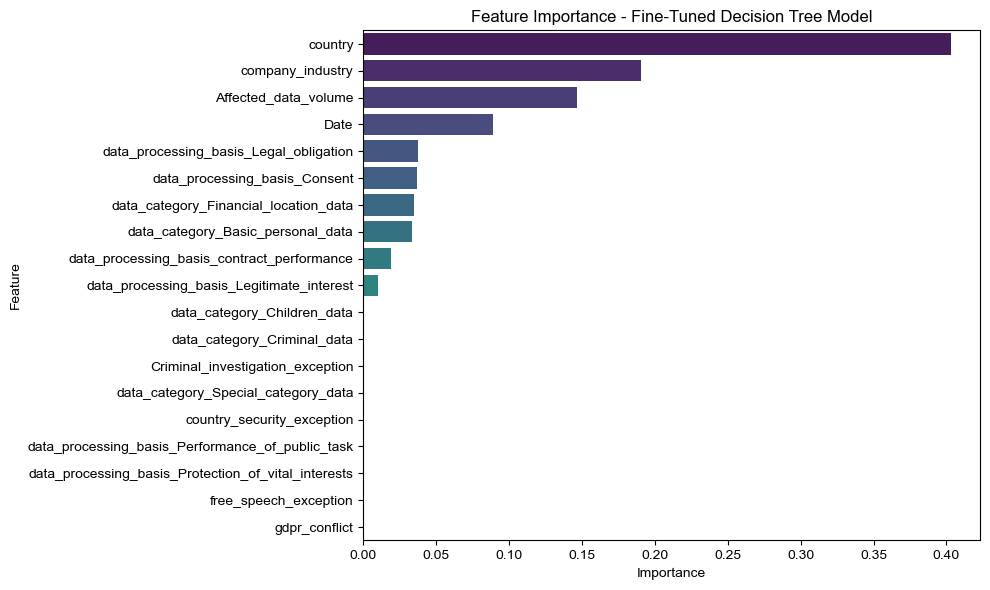

In [263]:
# Output the feature importances for the fine-tuned model
print("\nFeature Importance for the Fine-Tuned Decision Tree Model:")

# Get feature importances from the model
importances = best_dt.feature_importances_

# Create a DataFrame to display feature importances in a readable format
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the DataFrame by importance values in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importances)

# Optionally, save the feature importances to a text file
feature_importances.to_csv('feature_importances.csv', index=False)
print("\nFeature importances saved to 'feature_importances.csv'")

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title("Feature Importance - Fine-Tuned Decision Tree Model")
plt.tight_layout()
plt.show()

### Log Transformation

In [266]:
# Manually set class weights to adjust for class imbalance
class_weights = {0: 1.5, 1: 1, 2: 1}  # Adjust these weights based on the class distribution

# Initialize the DecisionTreeClassifier with class weights
dt_classifier = DecisionTreeClassifier(
    random_state=42,
    class_weight=class_weights
)

# Train the DecisionTreeClassifier model with the manually set class weights
dt_classifier.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred = dt_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"Validation set accuracy: {val_accuracy:.4f}")
print(f"Validation set weighted F1 score: {val_f1:.4f}")

# Evaluate on the test set
y_test_pred = dt_classifier.predict(X_reg_test)
test_accuracy = accuracy_score(y_bracket_test, y_test_pred)
test_f1 = f1_score(y_bracket_test, y_test_pred, average='weighted')

print(f"Test set accuracy: {test_accuracy:.4f}")
print(f"Test set weighted F1 score: {test_f1:.4f}")


Validation set accuracy: 0.4389
Validation set weighted F1 score: 0.4457
Test set accuracy: 0.4400
Test set weighted F1 score: 0.4458


## Feature Engineering

In [257]:
from sklearn.preprocessing import StandardScaler

# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_reg_test)

In [258]:
from sklearn.decomposition import PCA

# 设置要保留的主成分数目（可以设置为 95% 的方差解释比例）
pca = PCA(n_components=0.95)  # 保留 95% 的方差
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 输出PCA后的特征数量
print(f"Original number of features: {X_train.shape[1]}")
print(f"Number of features after PCA: {X_train_pca.shape[1]}")


Original number of features: 19
Number of features after PCA: 18


In [259]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# 使用递归特征消除选择重要特征
dt_classifier = DecisionTreeClassifier(random_state=42)
selector = RFE(dt_classifier, n_features_to_select=10, step=1)  # 选择 10 个最重要的特征
X_train_rfe = selector.fit_transform(X_train_scaled, y_train)
X_val_rfe = selector.transform(X_val_scaled)
X_test_rfe = selector.transform(X_test_scaled)

# 输出保留特征的数量
print(f"Number of features selected by RFE: {X_train_rfe.shape[1]}")


Number of features selected by RFE: 10


In [260]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# 训练模型（以决策树为例）
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_pca, y_train)  # 这里使用PCA后的数据

# 预测和评估
y_val_pred = model.predict(X_val_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

y_test_pred = model.predict(X_test_pca)
test_accuracy = accuracy_score(y_bracket_test, y_test_pred)
test_f1 = f1_score(y_bracket_test, y_test_pred, average='weighted')

print(f"Validation accuracy: {val_accuracy:.4f}")
print(f"Validation weighted F1 score: {val_f1:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test weighted F1 score: {test_f1:.4f}")


Validation accuracy: 0.3167
Validation weighted F1 score: 0.3220
Test accuracy: 0.3467
Test weighted F1 score: 0.3508


## Random Forest

In [267]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# 使用SMOTE处理类别不平衡问题
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 初始化随机森林分类器，设置 class_weight='balanced' 自动平衡类权重
rf_classifier = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',  # 处理类别不平衡
    n_jobs=-1  # 启用所有核心来加速训练
)

# 训练随机森林模型
rf_classifier.fit(X_train_resampled, y_train_resampled)

# 在验证集上进行预测
y_val_pred_rf = rf_classifier.predict(X_val)
val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
val_f1_rf = f1_score(y_val, y_val_pred_rf, average='weighted')

# 在测试集上进行预测
y_test_pred_rf = rf_classifier.predict(X_reg_test)
test_accuracy_rf = accuracy_score(y_bracket_test, y_test_pred_rf)
test_f1_rf = f1_score(y_bracket_test, y_test_pred_rf, average='weighted')

# 打印验证集和测试集的评估结果
print(f"Random Forest - Validation accuracy: {val_accuracy_rf:.4f}")
print(f"Random Forest - Validation weighted F1 score: {val_f1_rf:.4f}")
print(f"Random Forest - Test accuracy: {test_accuracy_rf:.4f}")
print(f"Random Forest - Test weighted F1 score: {test_f1_rf:.4f}")

# 打印分类报告
print("\nRandom Forest - Validation set classification report:")
print(classification_report(y_val, y_val_pred_rf))

print("\nRandom Forest - Test set classification report:")
print(classification_report(y_bracket_test, y_test_pred_rf))


Random Forest - Validation accuracy: 0.4389
Random Forest - Validation weighted F1 score: 0.4490
Random Forest - Test accuracy: 0.4400
Random Forest - Test weighted F1 score: 0.4551

Random Forest - Validation set classification report:
              precision    recall  f1-score   support

           0       0.52      0.49      0.51        73
           1       0.17      0.23      0.19        30
           2       0.52      0.47      0.49        77

    accuracy                           0.44       180
   macro avg       0.40      0.40      0.40       180
weighted avg       0.46      0.44      0.45       180


Random Forest - Test set classification report:
              precision    recall  f1-score   support

           0       0.51      0.46      0.48        94
           1       0.17      0.29      0.22        34
           2       0.56      0.47      0.51        97

    accuracy                           0.44       225
   macro avg       0.41      0.41      0.40       225
weighte

# Step 7 GDPR Clause

In [268]:
def extract_articles(text):
    """
    Extract article numbers from GDPR clause text.
    Supports formats:
    - Art. X
    - Art X
    - Article X
    - Article X(Y)
    """
    if pd.isna(text):
        return []
    
    import re
    # Extract all article numbers
    # Match Art. X, Art X, Article X formats
    pattern1 = r'(?:Art(?:\.|icle))\s*(\d+(?:\.\d+)?)'
    articles1 = re.findall(pattern1, str(text))
    
    # Match Article X(Y) format, extract the X part
    pattern2 = r'Article\s*(\d+)(?:\(\d+\))?'
    articles2 = re.findall(pattern2, str(text))
    
    # Combine the results and remove duplicates
    all_articles = list(set(articles1 + articles2))
    
    return all_articles

# Test the extraction function
test_texts = [
    "Article 21(1) GDPR",
    "Article 6(1)(a) GDPR",
    "Art. 5 GDPR",
    "Art 13 and Art. 14 GDPR",
    "Articles 5, 6, and 7 GDPR",
    "GDPR Article 32"
]

print("Article Extraction Test:")
for text in test_texts:
    extracted = extract_articles(text)
    print(f"Original text: {text}")
    print(f"Extracted articles: {extracted}")
    print("-" * 40)

# Apply to the dataset
df['extracted_articles'] = df['gdpr_clause'].apply(extract_articles)

# Check the extraction results
print("\nSample extracted articles in the dataset:")
for i in range(min(5, len(df))):
    print(f"Original text: {df['gdpr_clause'].iloc[i]}")
    print(f"Extracted articles: {df['extracted_articles'].iloc[i]}")
    print("-" * 40)

# Calculate the success rate of extractions
non_empty_extractions = df['extracted_articles'].apply(lambda x: len(x) > 0).sum()
total_rows = len(df)
print(f"Article extraction success rate: {non_empty_extractions}/{total_rows} ({non_empty_extractions/total_rows*100:.2f}%)")


Article Extraction Test:
Original text: Article 21(1) GDPR
Extracted articles: ['21']
----------------------------------------
Original text: Article 6(1)(a) GDPR
Extracted articles: ['6']
----------------------------------------
Original text: Art. 5 GDPR
Extracted articles: ['5']
----------------------------------------
Original text: Art 13 and Art. 14 GDPR
Extracted articles: ['14']
----------------------------------------
Original text: Articles 5, 6, and 7 GDPR
Extracted articles: []
----------------------------------------
Original text: GDPR Article 32
Extracted articles: ['32']
----------------------------------------

Sample extracted articles in the dataset:
Original text: Article 21(1) GDPR
Extracted articles: ['21']
----------------------------------------
Original text: Article 21(1) GDPR
Extracted articles: ['21']
----------------------------------------
Original text: Article 21(1) GDPR
Extracted articles: ['21']
----------------------------------------
Original text: A

In [269]:
# Use MultiLabelBinarizer to convert article list into a binary matrix
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
article_matrix = mlb.fit_transform(df['extracted_articles'])
article_df = pd.DataFrame(article_matrix, columns=[f'Art_{c}' for c in mlb.classes_])

# View the most common articles
article_counts = article_df.sum().sort_values(ascending=False)
print("\nMost common violated articles:")
print(article_counts.head(10))


Most common violated articles:
Art_6      732
Art_5      657
Art_32     352
Art_15     311
Art_12     265
Art_13     245
Art_9      226
Art_17     224
Art_5.1    156
Art_58     131
dtype: int64


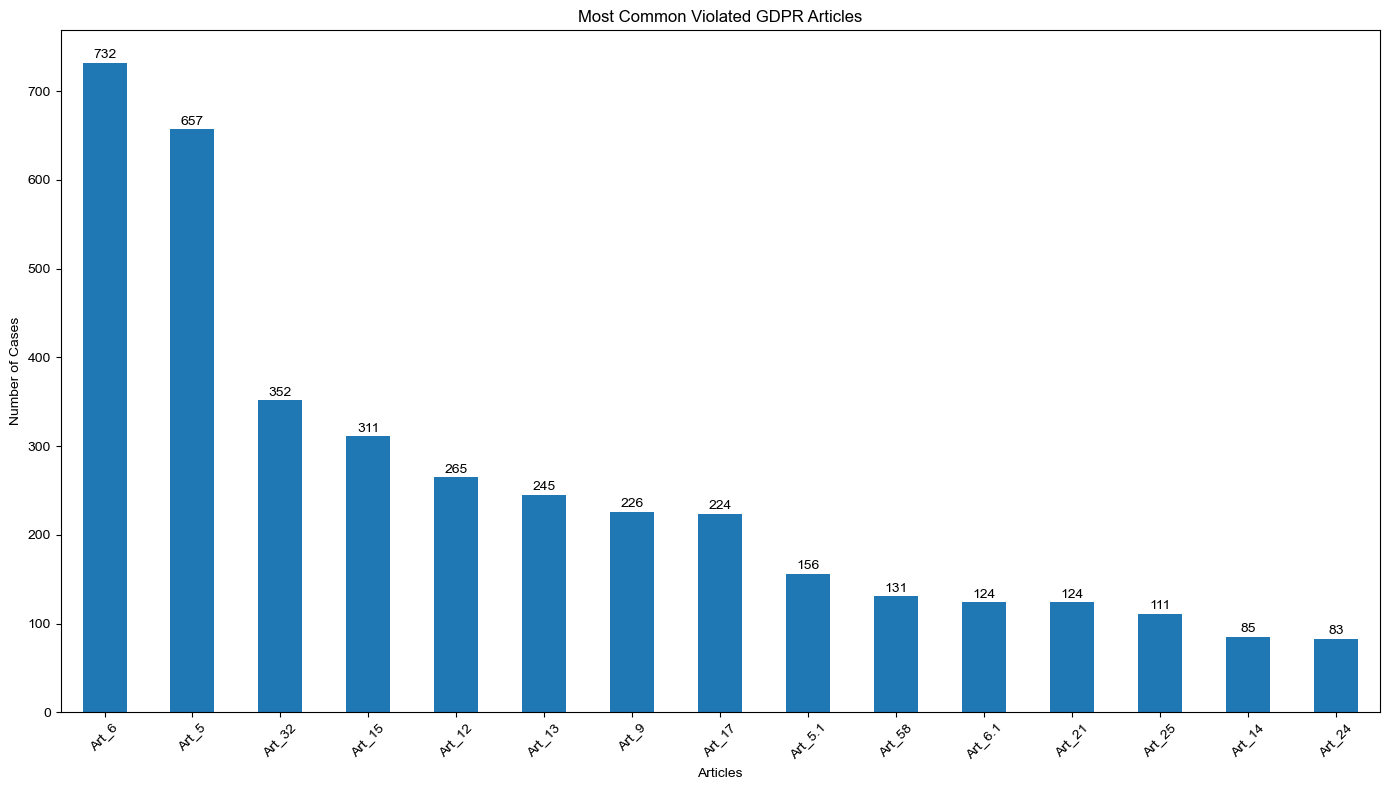

In [270]:
# Visualize the distribution of articles
plt.figure(figsize=(14, 8))
article_counts.head(15).plot(kind='bar')
plt.title('Most Common Violated GDPR Articles')
plt.xlabel('Articles')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
for i, v in enumerate(article_counts.head(15)):
    plt.text(i, v + 5, str(v), ha='center')
plt.tight_layout()
plt.show()


In [298]:
# 2. Build a multi-label decision tree model
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier  # Use Decision Tree instead of Random Forest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, hamming_loss, f1_score

top_articles = article_counts.head(8).index
article_targets = article_df[top_articles]

df_clean = df.copy()
df_clean = df_clean.drop(columns=['gdpr_clause', 'extracted_articles'])

# Use the same data splitting as the original code
X = df_clean.drop(columns=[col for col in article_df.columns if col in df_clean.columns])
y_article = article_targets

# Use the same splitting parameters
X_train_val_art, X_test_art, y_train_val_art, y_test_art = train_test_split(
    X_article, y_article, test_size=0.2, random_state=42, stratify=y_violation
)
X_train_art, X_val_art, y_train_art, y_val_art = train_test_split(
    X_train_val_art, y_train_val_art, test_size=0.25, random_state=42, stratify=y_train_val
)

print("\nDataset sizes with the original split method:")
print(f"Training set: X_train_art {X_train_art.shape}, y_train_art {y_train_art.shape}")
print(f"Validation set: X_val_art {X_val_art.shape}, y_val_art {y_val_art.shape}")
print(f"Test set: X_test_art {X_test_art.shape}, y_test_art {y_test_art.shape}")
print(f"Number of target articles: {len(top_articles)}")



Dataset sizes with the original split method:
Training set: X_train_art (1506, 19), y_train_art (1506, 8)
Validation set: X_val_art (503, 19), y_val_art (503, 8)
Test set: X_test_art (503, 19), y_test_art (503, 8)
Number of target articles: 8


In [305]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, hamming_loss, f1_score, accuracy_score, jaccard_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Baseline 模型（默认参数）
baseline_model = MultiOutputClassifier(DecisionTreeClassifier(random_state=42))
baseline_model.fit(X_train_art, y_train_art)
y_pred_baseline = baseline_model.predict(X_test_art)

# 2. Fine-tuned 模型（统一 grid search，调 max_depth 和 min_samples_leaf）
param_grid = {
    'estimator__max_depth': [3, 5, 10, 15],
    'estimator__min_samples_leaf': [1, 2, 4]
}
base_estimator = DecisionTreeClassifier(random_state=42)
fine_tuned_model = GridSearchCV(
    estimator=MultiOutputClassifier(base_estimator),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=1
)
fine_tuned_model.fit(X_train_art, y_train_art)
y_pred_finetune = fine_tuned_model.predict(X_test_art)

# 3. 评估指标函数
def evaluate_multi(y_true, y_pred, label_names=None):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    df_report = pd.DataFrame(report).transpose()

    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    hamming = hamming_loss(y_true, y_pred)
    subset_acc = accuracy_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average='samples', zero_division=0)

    print(df_report)
    print("\nMetrics:")
    print(f"F1 Macro:        {f1_macro:.4f}")
    print(f"Hamming Loss:    {hamming:.4f}")
    print(f"Subset Accuracy: {subset_acc:.4f}")
    print(f"Jaccard Similarity: {jaccard:.4f}")
    
    return {
        'f1_macro': f1_macro,
        'hamming': hamming,
        'subset_acc': subset_acc,
        'jaccard': jaccard,
        'report': df_report
    }

# 4. 输出评估
print("\n=== Baseline Model Evaluation ===")
baseline_metrics = evaluate_multi(y_test_art, y_pred_baseline)

print("\n=== Fine-tuned Model Evaluation ===")
finetuned_metrics = evaluate_multi(y_test_art, y_pred_finetune)

# 5. 比较性能提升
def print_improvement(m1, m2, metric_name):
    diff = (m2 - m1) / (m1 + 1e-6) * 100
    print(f"{metric_name}: {m1:.4f} → {m2:.4f} (▲ {diff:.2f}%)")

print("\n=== Performance Improvement (Fine-tuned vs Baseline) ===")
print_improvement(baseline_metrics['f1_macro'], finetuned_metrics['f1_macro'], "F1 Macro")
print_improvement(baseline_metrics['subset_acc'], finetuned_metrics['subset_acc'], "Subset Accuracy")
print_improvement(baseline_metrics['jaccard'], finetuned_metrics['jaccard'], "Jaccard Similarity")
print_improvement(baseline_metrics['hamming'], finetuned_metrics['hamming'], "Hamming Loss")

# 6. 保存模型（与原逻辑对应）
article_dt_models = {
    'baseline_model': baseline_model,
    'fine_tuned_model': fine_tuned_model.best_estimator_,
    'best_params': fine_tuned_model.best_params_,
    'metrics': {
        'baseline': baseline_metrics,
        'fine_tuned': finetuned_metrics
    }
}

Fitting 3 folds for each of 12 candidates, totalling 36 fits

=== Baseline Model Evaluation ===
              precision    recall  f1-score  support
0              0.488235  0.549669  0.517134    151.0
1              0.341880  0.303030  0.321285    132.0
2              0.350000  0.373333  0.361290     75.0
3              0.287879  0.327586  0.306452     58.0
4              0.215686  0.207547  0.211538     53.0
5              0.153846  0.163265  0.158416     49.0
6              0.511111  0.410714  0.455446     56.0
7              0.204082  0.232558  0.217391     43.0
micro avg      0.352381  0.359806  0.356055    617.0
macro avg      0.319090  0.320963  0.318619    617.0
weighted avg   0.353592  0.359806  0.355259    617.0
samples avg    0.275182  0.304771  0.270625    617.0

Metrics:
F1 Macro:        0.3186
Hamming Loss:    0.1996
Subset Accuracy: 0.2087
Jaccard Similarity: 0.2313

=== Fine-tuned Model Evaluation ===
              precision    recall  f1-score  support
0              0


Rules for Art_6:
|--- data_processing_basis_Legitimate_interest <= 0.50
|   |--- data_processing_basis_Consent <= 0.50
|   |   |--- data_processing_basis_Legal_obligation <= 0.50
|   |   |   |--- country <= 27.50
|   |   |   |   |--- company_industry <= 4.50
|   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |--- company_industry >  4.50
|   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |--- country >  27.50
|   |   |   |   |--- country <= 29.50
|   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |--- country >  29.50
|   |   |   |   |   |--- class: 0
|   |   |--- data_processing_basis_Legal_obligation >  0.50
|   |   |   |--- country <= 20.00
|   |   |   |   |--- country <= 14.50
|   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |--- country >  14.50
|   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- country >  20.00
|   |   |   |   |--- data_category_Financial_location_data <= 0.50
|   |   | 

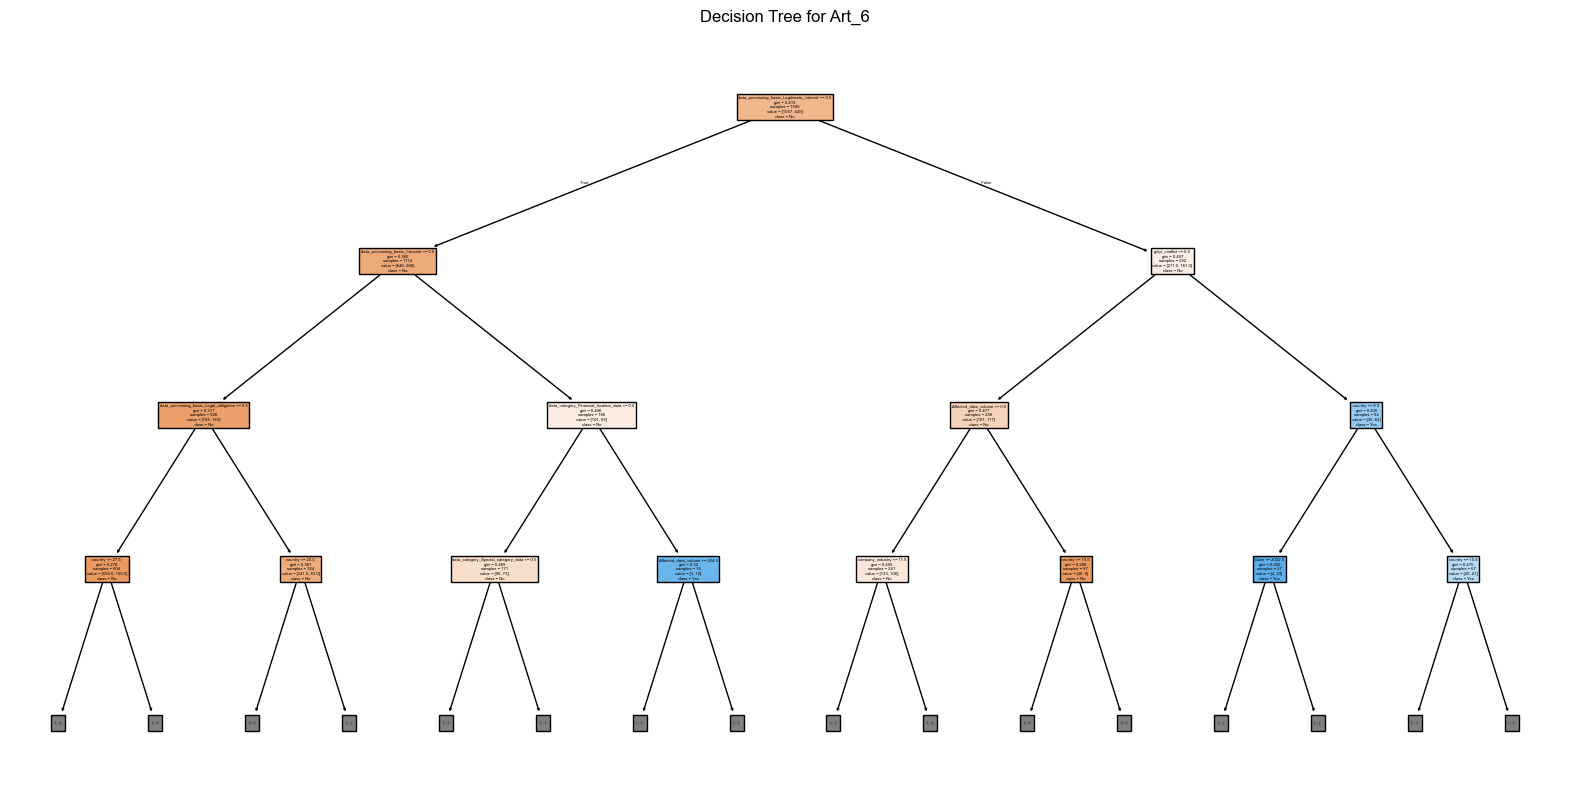

In [311]:
for i, article in enumerate(top_articles[:1]):
    tree = article_dt_models['fine_tuned_model'].estimators_[i]
    
    print(f"\nRules for {article}:")
    print(export_text(tree, feature_names=list(X_train_art.columns), max_depth=4))

    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=list(X_train_art.columns), class_names=["No", "Yes"],
              filled=True, max_depth=3)
    plt.title(f"Decision Tree for {article}")
    plt.show()


In [310]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("\nTest set performance evaluation for first 2 articles (multi-label model):")
article_performances = {}

# 使用 fine-tuned 多标签模型预测
fine_tuned_model = article_dt_models['fine_tuned_model']
y_pred_all = fine_tuned_model.predict(X_test_art)

# 仅评估前两条法条
for i, article in enumerate(top_articles[:2]):
    y_true = y_test_art.iloc[:, i]
    y_pred = y_pred_all[:, i]

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    article_performances[article] = {
        'accuracy': accuracy,
        'f1': f1
    }

    print(f"\n{article} test set performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_true, y_pred, zero_division=0))



Test set performance evaluation for first 2 articles (multi-label model):

Art_6 test set performance:
Accuracy: 0.6998
F1 Score: 0.5145
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       352
           1       0.50      0.53      0.51       151

    accuracy                           0.70       503
   macro avg       0.65      0.65      0.65       503
weighted avg       0.71      0.70      0.70       503


Art_5 test set performance:
Accuracy: 0.6779
F1 Score: 0.3193
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       371
           1       0.36      0.29      0.32       132

    accuracy                           0.68       503
   macro avg       0.56      0.55      0.55       503
weighted avg       0.66      0.68      0.67       503



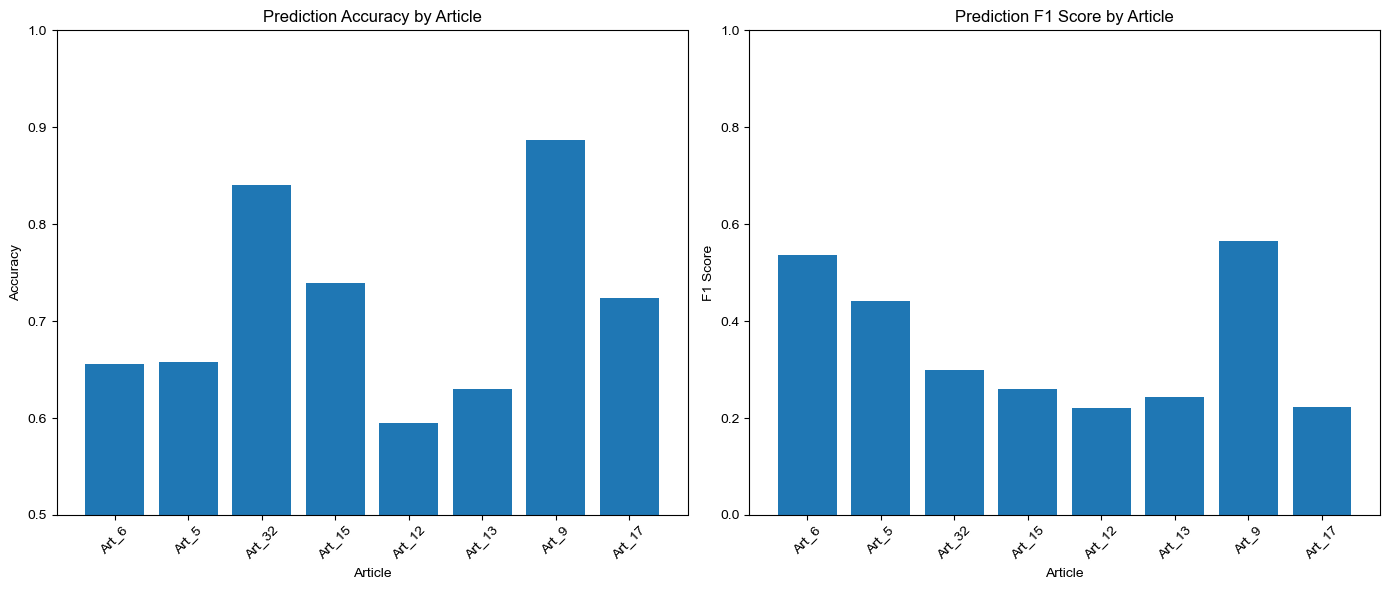

In [274]:
# Visualize the prediction performance for each article
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar([art for art in article_performances.keys()], 
        [perf['accuracy'] for perf in article_performances.values()])
plt.title('Prediction Accuracy by Article')
plt.xlabel('Article')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar([art for art in article_performances.keys()], 
        [perf['f1'] for perf in article_performances.values()])
plt.title('Prediction F1 Score by Article')
plt.xlabel('Article')
plt.ylabel('F1 Score')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Step 8. Model Visualization and Interpretation

In [275]:
print("Violation Result Decision Tree Rules:")
violation_tree_rules = export_text(final_violation_model, feature_names=list(X.columns))
print(violation_tree_rules)

Violation Result Decision Tree Rules:
|--- Affected_data_volume <= 0.50
|   |--- data_processing_basis_Performance_of_public_task <= 0.50
|   |   |--- gdpr_conflict <= 0.50
|   |   |   |--- free_speech_exception <= 0.50
|   |   |   |   |--- data_category_Basic_personal_data <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- data_category_Basic_personal_data >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- free_speech_exception >  0.50
|   |   |   |   |--- country <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- country >  0.50
|   |   |   |   |   |--- class: 0
|   |   |--- gdpr_conflict >  0.50
|   |   |   |--- data_category_Basic_personal_data <= 0.50
|   |   |   |   |--- free_speech_exception <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- free_speech_exception >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- data_category_Basic_personal_data >  0.50
|   |   |   |   |--- class: 1
|   |--- data_processing_basis_Performance_o

In [282]:
# 7.2 Explanation of prediction for a single sample

from sklearn.tree import export_text
# Randomly select a sample from the test set
sample_idx = np.random.randint(0, len(X_test))
sample_X = X_test.iloc[sample_idx:sample_idx+1]
sample_y = y_test[sample_idx]  # Use numpy indexing here

# Handle multi-label case (if sample_y is an array)
actual_label = 'Violation' if sample_y[0] == 1 else 'No Violation'  # Adjust indexing based on your use case
print(f"Example: Explanation of prediction process for sample #{sample_idx}")
print(f"Actual label: {sample_y} ({actual_label})")

# Make the prediction
pred_prob = final_violation_model.predict_proba(sample_X)[0]
pred_class = final_violation_model.predict(sample_X)[0]
pred_label = 'Violation' if pred_class == 1 else 'No Violation'

print(f"Predicted label: {pred_class} ({pred_label})")
print(f"Prediction probabilities: [No Violation: {pred_prob[0]:.4f}, Violation: {pred_prob[1]:.4f}]")

# Extract the decision tree rules for the model
tree_rules = export_text(final_violation_model, feature_names=list(X.columns))

# Print decision tree rules
print("\nDecision tree rules for this prediction:")
print(tree_rules)

# You can use model decision path to see which nodes the sample passed through.
decision_path = final_violation_model.decision_path(sample_X)
print(f"Decision path for sample #{sample_idx}:")
print(decision_path)


Example: Explanation of prediction process for sample #188
Actual label: [0 0 0 1] (No Violation)
Predicted label: 1 (Violation)
Prediction probabilities: [No Violation: 0.2934, Violation: 0.7066]

Decision tree rules for this prediction:
|--- Affected_data_volume <= 0.50
|   |--- data_processing_basis_Performance_of_public_task <= 0.50
|   |   |--- gdpr_conflict <= 0.50
|   |   |   |--- free_speech_exception <= 0.50
|   |   |   |   |--- data_category_Basic_personal_data <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- data_category_Basic_personal_data >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- free_speech_exception >  0.50
|   |   |   |   |--- country <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- country >  0.50
|   |   |   |   |   |--- class: 0
|   |   |--- gdpr_conflict >  0.50
|   |   |   |--- data_category_Basic_personal_data <= 0.50
|   |   |   |   |--- free_speech_exception <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |

In [307]:

node_indicator = final_violation_model.decision_path(sample_X)
leaf_id = final_violation_model.apply(sample_X)

# Get the decision path
node_index = node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]

print("\nDecision Path:")
for node_id in node_index:
    # If it's not a leaf node
    if node_id != leaf_id[0]:
        # Decision condition
        feature_id = final_violation_model.tree_.feature[node_id]
        threshold = final_violation_model.tree_.threshold[node_id]
        feature_name = X.columns[feature_id]
        feature_value = sample_X.iloc[0, feature_id]
        
        if feature_value <= threshold:
            threshold_sign = "<="
            direction = "Yes"
        else:
            threshold_sign = ">"
            direction = "No"
        
        print(f"Decision {node_id}: Feature '{feature_name}' = {feature_value} {threshold_sign} {threshold:.4f}? {direction}")
    else:
        # Leaf node
        class_probabilities = final_violation_model.tree_.value[node_id][0] / final_violation_model.tree_.value[node_id][0].sum()
        predicted_class = np.argmax(class_probabilities)
        print(f"Prediction: Class {predicted_class} ({'Violation' if predicted_class == 1 else 'No Violation'}), Probability: {class_probabilities[predicted_class]:.4f}")



Decision Path:
Decision 0: Feature 'Affected_data_volume' = 0 <= 0.5000? Yes
Decision 1: Feature 'data_processing_basis_Performance_of_public_task' = 1 > 0.5000? No
Decision 15: Feature 'Date' = 2021 > 2020.5000? No
Decision 21: Feature 'free_speech_exception' = 0 <= 0.5000? Yes
Decision 22: Feature 'Date' = 2021 <= 2023.5000? Yes
Prediction: Class 1 (Violation), Probability: 0.7066


In [286]:
# 7.4 Compare predictions from different models on the same sample
print("Predictions from different models on the same sample:")

# Violation result prediction
violation_pred = final_violation_model.predict(sample_X)[0]
violation_prob = final_violation_model.predict_proba(sample_X)[0][1]
print(f"Violation prediction: {'Violation' if violation_pred == 1 else 'No Violation'} (probability: {violation_prob:.4f})")

# Selected violation nature predictions
for nature_name, nature_model in nature_models.items():
    nature_pred = nature_model.predict(sample_X)[0]
    nature_prob = nature_model.predict_proba(sample_X)[0][1]
    print(f"{nature_name} prediction: {'Yes' if nature_pred == 1 else 'No'} (probability: {nature_prob:.4f})")

# Fine prediction
fine_binary_pred = final_binary_model.predict(sample_X)[0]
fine_binary_prob = final_binary_model.predict_proba(sample_X)[0][1]
print(f"Fine prediction: {'Fine imposed' if fine_binary_pred == 1 else 'No fine'} (probability: {fine_binary_prob:.4f})")

# If fine is predicted, predict the fine amount bracket
if fine_binary_pred == 1:
    try:
        # Fine bracket classification prediction
        fine_bracket_pred = final_bracket_model.predict(sample_X)[0]
        
        # Map fine brackets
        bracket_mapping = {
            0: "Low fine (1-10,000)",
            1: "Medium fine (10,001-50,000)",
            2: "High fine (50,001+)"
        }
        fine_bracket_desc = bracket_mapping.get(fine_bracket_pred, "Unknown bracket")
        
        print(f"Predicted fine amount bracket: {fine_bracket_desc}")
    except Exception as e:
        print(f"Unable to predict fine amount bracket, error: {str(e)}")

# GDPR Article prediction
print("\nPredicted GDPR Articles violated:")
article_violations_found = False

# Iterate through each article model and make predictions
for article, model in article_dt_models.items():
    try:
        # Make binary prediction
        article_pred = model.predict(sample_X)[0]
        
        # If the model can provide probabilities, get them
        article_prob = 0
        if hasattr(model, 'predict_proba'):
            article_probs = model.predict_proba(sample_X)[0]
            article_prob = article_probs[1] if len(article_probs) > 1 else article_probs[0]
        
        # Only display articles predicted as violated
        if article_pred == 1:
            article_violations_found = True
            if hasattr(model, 'predict_proba'):
                print(f"Article {article}: Violated (probability: {article_prob:.4f})")
            else:
                print(f"Article {article}: Violated")
    except Exception as e:
        print(f"Error predicting Article {article}: {str(e)}")

if not article_violations_found:
    print("No specific GDPR articles predicted to be violated")

# Optional: Display top 3 most likely articles if no violations were found
if not article_violations_found and all(hasattr(model, 'predict_proba') for _, model in article_dt_models.items()):
    print("\nTop 3 most likely articles (even if not predicted as violated):")
    article_probs = []
    
    for article, model in article_dt_models.items():
        probs = model.predict_proba(sample_X)[0]
        violation_prob = probs[1] if len(probs) > 1 else 0
        article_probs.append((article, violation_prob))
    
    # Sort by probability and get top 3
    article_probs.sort(key=lambda x: x[1], reverse=True)
    for article, prob in article_probs[:3]:
        print(f"Article {article}: {prob:.4f} probability")


Predictions from different models on the same sample:
Violation prediction: Violation (probability: 0.7066)
violation_nature_Breach_of_Data_processing_principle prediction: Yes (probability: 0.5433)
violation_nature_Breach_of_data_security prediction: No (probability: 0.1488)
violation_nature_Violation_of_Data_processing_obligation prediction: No (probability: 0.0000)
violation_nature_Violation_of_data_subject_rights prediction: No (probability: 0.4444)
Fine prediction: No fine (probability: 0.4375)

Predicted GDPR Articles violated:
Article Art_15: Violated (probability: 0.6982)
Article Art_13: Violated (probability: 0.5144)


In [287]:
# Compare feature importance across all models
print("Comparing feature importance across all models:")

# Create comprehensive feature importance dataframe
all_importances = pd.DataFrame({'feature': X.columns})

# Add violation_result model feature importance
all_importances['violation_result'] = final_violation_model.feature_importances_

# Add selected violation nature models feature importance
for nature_name, nature_model in nature_models.items():
    short_name = nature_name.replace('violation_nature_', '')
    all_importances[short_name] = nature_model.feature_importances_

# Add fine models feature importance
all_importances['fine_binary'] = final_binary_model.feature_importances_

# Add GDPR article models feature importance
for article, model in article_dt_models.items():
    article_col = f'article_{article}'
    all_importances[article_col] = model.feature_importances_

# Calculate average importance
all_importances['avg_importance'] = all_importances.iloc[:, 1:].mean(axis=1)

# Sort by average importance
top_features = all_importances.sort_values('avg_importance', ascending=False).head(10)
print("Top 10 features by average importance across all models:")
print(top_features[['feature', 'avg_importance']])

Comparing feature importance across all models:
Top 10 features by average importance across all models:
                                             feature  avg_importance
4                                            country        0.247584
0                               Affected_data_volume        0.147530
18                                     gdpr_conflict        0.083922
3                                   company_industry        0.078730
2                                               Date        0.066951
11                     data_processing_basis_Consent        0.066657
13         data_processing_basis_Legitimate_interest        0.062309
6                  data_category_Basic_personal_data        0.053456
10               data_category_Special_category_data        0.048846
14  data_processing_basis_Performance_of_public_task        0.031045


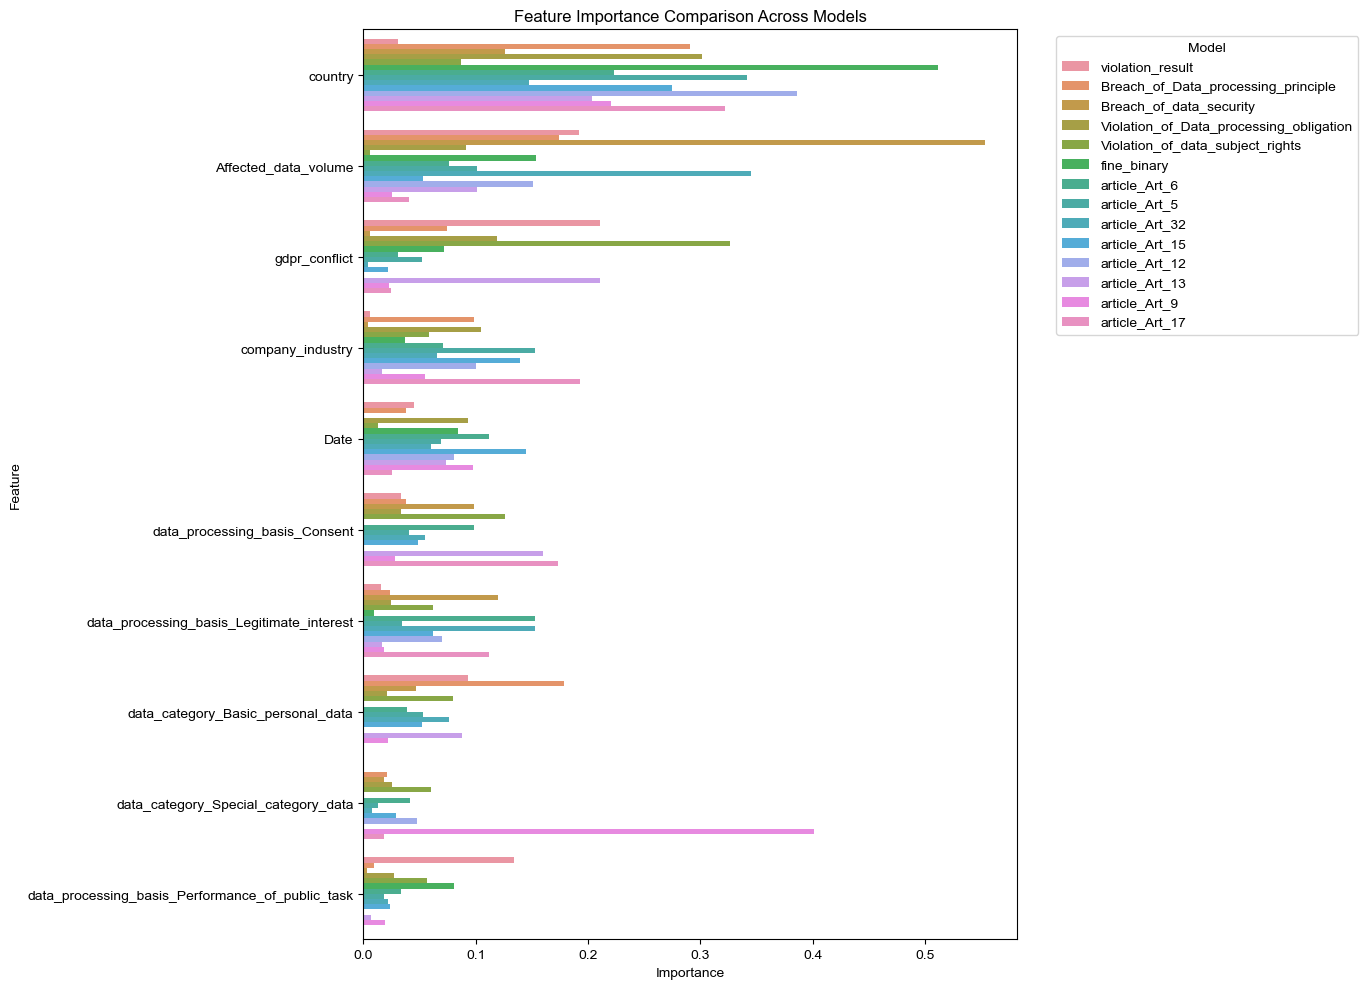

In [288]:
# Visualize feature importance comparison across all models
# Convert to long format for plotting
top_features_melted = pd.melt(top_features, 
                             id_vars=['feature', 'avg_importance'],
                             var_name='model',
                             value_name='importance')

plt.figure(figsize=(14, 10))
sns.barplot(x='importance', y='feature', hue='model', data=top_features_melted)
plt.title('Feature Importance Comparison Across Models')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


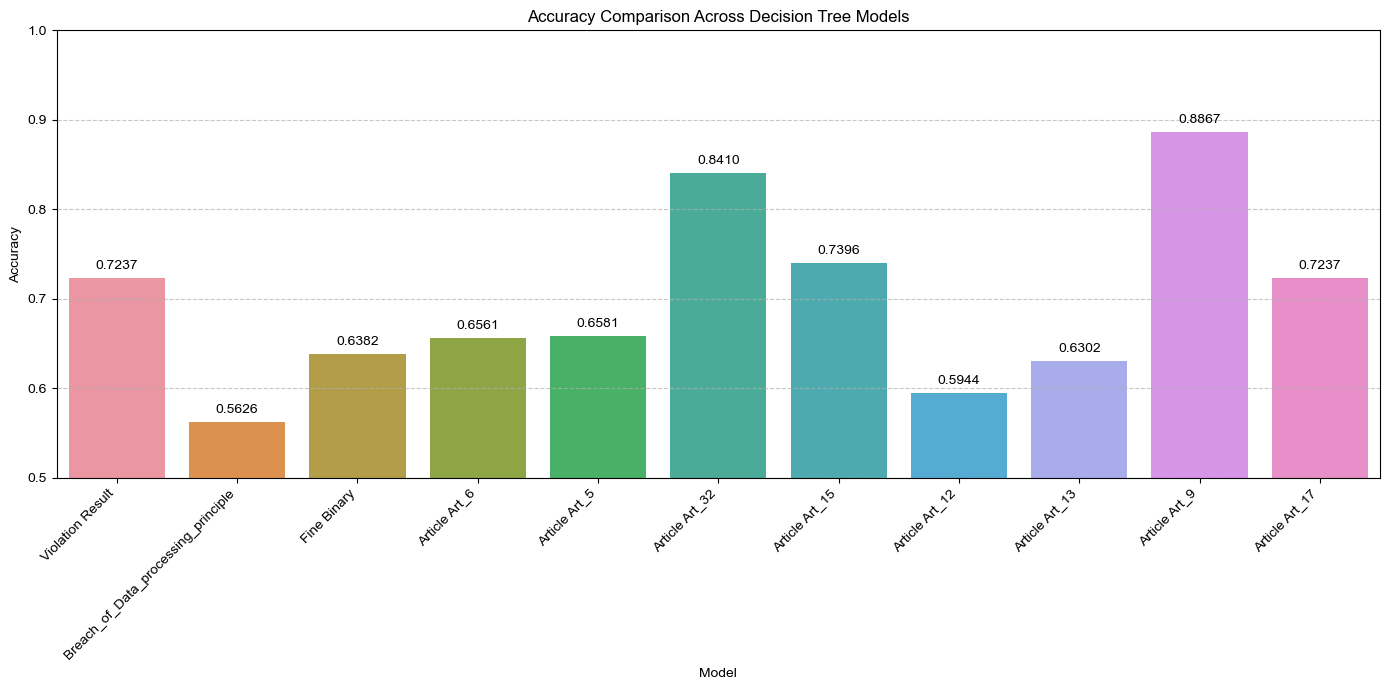

Accuracy summary for all models:
                                  Model  Accuracy
9                         Article Art_9  0.886680
5                        Article Art_32  0.840954
6                        Article Art_15  0.739563
0                      Violation Result  0.723658
10                       Article Art_17  0.723658
4                         Article Art_5  0.658052
3                         Article Art_6  0.656064
2                           Fine Binary  0.638171
8                        Article Art_13  0.630219
7                        Article Art_12  0.594433
1   Breach_of_Data_processing_principle  0.562624

Average accuracy for article prediction models: 0.7162


In [289]:
# Summary of prediction effectiveness for decision tree models
# First create the base summary for original models
models_summary = pd.DataFrame({
    'Model': ['Violation Result', 
              next(iter(nature_models.keys())).replace('violation_nature_', ''), 
              'Fine Binary'],
    'Accuracy': [accuracy, 
                 accuracy_score(y_nature_test, nature_models[next(iter(nature_models.keys()))].predict(X_nature_test)),
                 accuracy_binary]
})

# Create a summary for article prediction models
article_accuracies = []
for article in article_dt_models:
    article_acc = accuracy_score(y_test_art[article], article_dt_models[article].predict(X_test_art))
    article_accuracies.append({
        'Model': f'Article {article}',
        'Accuracy': article_acc
    })

# Combine the original models with article models
if article_accuracies:
    article_summary = pd.DataFrame(article_accuracies)
    models_summary = pd.concat([models_summary, article_summary], ignore_index=True)

# Visualize the model comparison
plt.figure(figsize=(14, 7))
sns.barplot(x='Model', y='Accuracy', data=models_summary)
plt.title('Accuracy Comparison Across Decision Tree Models')
plt.ylim(0.5, 1.0)  # Set y-axis range from 0.5 to 1.0 to better show differences
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability with more models
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy values as text on the bars
for i, row in enumerate(models_summary.itertuples()):
    plt.text(i, row.Accuracy + 0.01, f'{row.Accuracy:.4f}', ha='center')

plt.tight_layout()
plt.show()

# Print summary table
print("Accuracy summary for all models:")
print(models_summary.sort_values('Accuracy', ascending=False))

# Calculate and display average accuracy for article models
if article_accuracies:
    article_models = [model for model in models_summary['Model'] if 'Article' in model]
    article_avg_accuracy = models_summary[models_summary['Model'].isin(article_models)]['Accuracy'].mean()
    print(f"\nAverage accuracy for article prediction models: {article_avg_accuracy:.4f}")

In [290]:
fine_reg_bracket_model = best_dt

In [292]:
import os
import pickle

# Create models directory (if it doesn't exist)
os.makedirs('models', exist_ok=True)

# Package all models into a dictionary
all_models = {
    'violation_model': final_violation_model,
    'nature_models': nature_models,
    'fine_binary_model': final_binary_model,
    'fine_bracket_model': fine_reg_bracket_model,  # Note this is the bracket classification model
    'article_dt_models': article_dt_models,  # Include article prediction models
    'article_mlb': mlb  # Include the multilabel binarizer for articles
}

# Save the models
with open('models/gdpr_decision_tree_models.pkl', 'wb') as f:
    pickle.dump(all_models, f)

print("All models have been saved to models/gdpr_decision_tree_models.pkl")

All models have been saved to models/gdpr_decision_tree_models.pkl
